# Machine Learning Engineer Nanodegree 

## Steganalysis of LSB Matching in Greyscale Images - Capstone Project
<hr>

Sourish Banerjee<br>
May 1st, 2018

## I. Definition
<hr>

### Project Overview
Steganography is the art of hiding messages in images by altering the least significant bits of the pixels in images with that of the message bits. The result is an image with a message hidden in it. However, the change is imperceptible to the human eye. This is because on changing the least significant bits in the pixels of an image, the pixel values are only altered by a small amount, resulting in a visually similar altered or steg image obtained from the original or cover image. Steganography has been widely used because of its potential capability to hide the existence of sensitive data. In situations where this kind of data hiding is illegal, potentially dangerous or inherently unethical, it becomes necessary to detect the presence of steganography in images.

Steganalysis is the art of detection of steganography in an image. There are two major types of steganography, and the preferred steganalysis methods for them are also different [1]. The naïve method is called LSB embedding. In this method, the LSB bit remains unchanged if the message bit is the same as the LSB bit, otherwise, the bit is altered. Hence, the odd pixels are reduced by 1 in intensity, whereas the even pixel values are incremented by 1. However, this causes an imbalance in the image histogram, which can be easily exploited by statistical methods for steganalysis. The second method of LSB steganography, LSB matching solves this issue by randomly incrementing or decrementing the pixel values by 1 in case of an LSB bit mismatch. This avoids the issue of histogram imbalance and makes it difficult to perform steganalysis by statistical methods alone. 

In this project, I have implemented a detector for presence of LSB matching in greyscale images using classification techniques. Over the years, several feature sets have been proposed for the purpose of training, including HCFHOM [2], A.HCFCOM, C.A.HCFCOM [3] and HOMMS [4]. In my project, I have used the CF feature set proposed in [1] on the BOSSbase dataset. The implementation involves feature extraction from 20000 images (10000 cover and 10000 steg images with a payload of 0.4), training of classifiers on the resultant feature dataset, persisting of the models having the best performance, and building of a detector using a voting ensemble of these classifiers. The code for the feature extraction is available in the 'Image Preprocessing.ipynb' notebook. The original BOSSbase dataset has 10,000 greyscale images, each of size 512 x 512. All the images in the dataset are treated as the cover images. From this dataset, I have generated 10,000 corresponding images corrupted with LSB matching steganography with a payload of 0.40 (payload refers to the fraction of pixels in the original image that has been corrupted due to the steganography process). For this purpose, I have used the tool available in [2]. The tool to generate the steg images is as follows:

*\$ python aletheia.py lsbm-sim bossbase 0.40 bossbase_lsb*

### Problem Statement
My main goal is to classify greyscale images based on whether they are corrupted with LSB matching or not. I have used a labelled dataset of greyscale images, both with and without LSB matching and have developed a supervised learning workflow to solve this problem. The final result of the project is a tool that takes as input any grayscale image and gives a prediction as to whether the image is corrupted with LSB matching or not. The project workflow is detailed in brief under the project overview.

### Metrics
I have used the F-Score as an evaluation metric for my benchmark and solution model. The F-Score is defined as the harmonic mean over precision and recall for a given test. Precision is the number of correct positive results (True Positives) divided by the number of all positive results returned by the classifier (True Positives + False Positives), and recall is the number of correct positive results True Positives) divided by the number of all samples that should have been identified as positive (True Positives + False Negatives). The above metrics are formalized as follows:

Precision = TP / (TP + FP)<br>
Recall = TP / (TP + FN)<br>
F-Score = (2 \* Precision \* Recall) / (Precision + Recall)

The F-Score is a good metric for the problem as applications of steganalysis require both good precision and recall. For example, in a naive use case where all detected cases of steganography are penalized, we would like to detect as many true cases as possible (high recall) while at the same time trying to prevent false positives and hence unjust penalties (high precision). 

## 2. Analysis
<hr>

### Data Exploration
Unlike that in LSB embedding, the imbalances caused by LSB matching in the spatial domain are not obvious enough to be exploited by statistical techniques alone. The CF feature set [1] comprises of 41 features and is based on the premise that given enough spatial information to train on, learners will eventually be able to pick up these subtler imbalances. Because LSB matching primarily alters the spatial data in the Least Significant Bit Plane (LSBP) and the Second Least Significant Bit Plane (LSBP2), the feature set mostly focuses the spatial information in these bit planes. Quantifying the correlation between bit planes and auto correlation within a bit plane are good ways of capturing such spatial information. This is the primary technique used in the CF feature set. It also captures the correlation between various slices of the image histogram in its density form, as well as the autocorrelations between the noise in the LSBP, which is obtained by subtracting the original image from various denoised images. These denoised image are in turn obtained via the removal of low complexity features from the Haar transform of the image using several different thresholding values.

Following are the formal expressions for each of the 41 features in the CF feature set:

M1 (1: m, 1: n) denotes the binary bits of LSBP and M2 (1: m, 1: n) denotes the binary bits of LSBP2.

C1 = cor (M1, M2)<br>

The autocorrelation of LSBP, C (k, l), is defined as:

C (k, l) = cor (Xk, Xl)<br>

where,

Xk = M1(1: m – k, 1: n – l) and Xl = M1 (k + 1: m, l + 1: n)

Different values are set to k and l, and C2 to C15 is defined as:

C2 = C (1, 0); C3 = C (2, 0); C4 = C (3, 0);<br>
C5 = C (4, 0); C6 = C (0, 1); C7 = C (0, 2);<br>
C8 = C (0, 3); C9 = C (0, 4); C10 = C (1, 1);<br>
C11 = C (2, 2); C12 = C (3, 3); C13 = C (4, 4);<br>
C14 = C (1, 2); C15 = C (2, 1).<br>

The histogram probability density, H, is denoted as (ρ0, ρ1, ρ2 …ρN-1). The histogram probability densities, He, Ho, Hl1, and Hl2 are denoted as follows:

He = (ρ0, ρ2, ρ4 …ρN-2), Ho = (ρ1, ρ3, ρ5 …ρN-1);<br>
Hl1 = (ρ0, ρ1, ρ2 …ρN-1-l), Hl2 = (ρl, ρl+1, ρl+2 …ρN-1).<br>

The autocorrelation coefficients C16 and CH(l) are defined as follows:

C16 = cor (He, Ho)<br>
CH (l) = cor (Hl1, Hl2)<br>

The features from C17 to C20 are defined as follows:

C17 = CH (1), C18 = CH (2),
C19 = CH (3), C20=CH (4).

Besides the features mentioned above, we consider the difference between test image and the denoised version. Firstly, the test image is decomposed by Haar wavelet. Zero is set to the coefficients in HL, LH and HH subbands, whose absolute value are smaller than some threshold value, t.  The image is reconstructed according to the inverse wavelet transform. The reconstructed image is treated as denoised image. The difference between test image and reconstructed version is Et (t is the threshold value).

CE (E; k, l) = cor (Et, k, Et, l)<br>

where,

Et, k = Et (1: m – k, 1: n – l) and Et, l = Et (k + 1: m, l + 1: n)<br>

Different values are set to t, k and l, and features from C21 to C41 are defined as follows:

C21 = CE (1.5; 0, 1); C22 = CE (1.5; 1, 0);<br>
C23 = CE (1.5; 1, 1); C24 = CE (1.5; 0, 2);<br>
C25 = CE (1.5; 2, 0); C26 = CE (1.5; 1, 2);<br>
C27 = CE (1.5; 2, 1); C28 = CE (2; 0, 1);<br>
C29 = CE (2; 1, 0); C30 = CE (2; 1, 1);<br>
C31 = CE (2; 0, 2); C32 = CE (2; 2, 0);<br>
C33 = CE (2; 1, 2); C34 = CE (2; 2, 1);<br>
C35 = CE (2.5; 0, 1); C36 = CE (2.5; 1, 0);<br>
C37 = CE (2.5; 1, 1); C38 = CE (2.5; 0, 2);<br>
C39 = CE (2.5; 2, 0); C40 = CE (2.5; 1, 2);<br>
C41 = CE (2.5; 2, 1).<br>

I have extracted the above features for each image in both the cover as well as the steg image datasets. The extraction code is implemented in the 'Image Preprocessing.ipynb' notebook. The result is two csv files, 'steg_features.csv' containing 10000 rows representing the features extracted from the cover images and 'steg_lsb_features.csv' containing 10000 rows representing the features extracted from the steg images. The attributes in each row are the values of the correlation features for the corresponding image as defined above. Exploration of the data reveals that all the data values lie between -1 and 1. This is expected as all the attributes are Pearson's correlation coefficients, and its range is between -1 and 1. Some values in the csv files are NaN, which is the case because the denominator of the Pearson's correlation coefficient tends to 0 in certain situations. I have also explored the mean, median and five fold summary of all the attributes in both the csv files to obtain a basic understanding of the data distributions for the attributes.

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Import both the csv files as data frames
data_cov = pd.read_csv("datasets/steg_features.csv", header = None)
data_steg = pd.read_csv("datasets/steg_lsb_features.csv", header = None)

In [5]:
data_cov.head()

0         1         2         3         4         5         6   \
0 -0.317327  0.827515  0.760605  0.740966  0.721418  0.910647  0.861356   
1       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
2 -0.503111  0.862970  0.802899  0.775813  0.751000  0.927452  0.889261   
3 -0.182988  0.887022  0.835196  0.813357  0.789932  0.911072  0.861291   
4  0.006107  0.932943  0.906990  0.897635  0.886993  0.970490  0.954652   

         7         8         9     ...           31        32        33  \
0  0.835196  0.815543  0.818339    ...    -0.001588 -0.004257 -0.000239   
1       NaN       NaN       NaN    ...     0.020795 -0.064528  0.015347   
2  0.866067  0.848226  0.855546    ...    -0.008875  0.003529  0.009316   
3  0.824739  0.795830  0.856713    ...     0.035087 -0.024424  0.004261   
4  0.944758  0.934639  0.934616    ...     0.015832 -0.009279 -0.015531   

         34        35        36        37        38        39        40  
0 -0.266943 -0.106837 -0.059703 -0.015162 -0.006729 -0.004329  0.001190  
1  0.005049 -0.145678 -0.189235  0.075486  0.015123 -0.066373  0.015776  
2 -0.248362 -0.107545 -0.072559 -0.018520 -0.014878  0.004437  0.008626  
3 -0.137704 -0.088573 -0.171084  0.064899  0.052169 -0.024969 -0.000246  
4 -0.130431 -0.099206 -0.136827  0.039127  0.025786 -0.013232 -0.022728  

[5 rows x 41 columns]

In [6]:
data_steg.head()

0         1         2         3         4         5         6   \
0 -0.317249  0.827004  0.760402  0.740601  0.721245  0.909903  0.861059   
1       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
2 -0.503030  0.862545  0.802756  0.775952  0.750876  0.927202  0.888695   
3 -0.182986  0.885745  0.833919  0.812366  0.788900  0.909339  0.859644   
4  0.005779  0.932725  0.907008  0.897505  0.886902  0.970202  0.954428   

         7         8         9     ...           31        32        33  \
0  0.834736  0.815029  0.817973    ...    -0.004308  0.001464  0.000648   
1       NaN       NaN       NaN    ...     0.012889 -0.044616  0.013183   
2  0.865893  0.847715  0.855019    ...    -0.008937  0.005700  0.006849   
3  0.823534  0.794631  0.855730    ...     0.025052 -0.020100  0.004419   
4  0.944286  0.934372  0.934324    ...     0.011471 -0.006570 -0.009688   

         34        35        36        37        38        39        40  
0 -0.260819 -0.115387 -0.062382 -0.013157 -0.004018  0.000808  0.001451  
1 -0.042575 -0.151737 -0.159439  0.056094  0.011527 -0.049579  0.011257  
2 -0.249954 -0.110913 -0.068477 -0.015880 -0.013919  0.002656  0.007633  
3 -0.156632 -0.101755 -0.147277  0.049512  0.043812 -0.021355 -0.000414  
4 -0.145384 -0.115871 -0.119257  0.027204  0.018741 -0.010369 -0.014391  

[5 rows x 41 columns]

In [8]:
# Summary for the attributes in steg_features.csv
data_cov.describe()

0            1            2            3            4   \
count  9684.000000  9684.000000  9684.000000  9684.000000  9682.000000   
mean     -0.157271     0.847285     0.774530     0.735113     0.703350   
std       0.327570     0.154055     0.197486     0.214149     0.225589   
min      -1.000000    -0.001405    -0.007565    -0.024273    -0.026781   
25%      -0.361742     0.805223     0.701829     0.645326     0.596800   
50%      -0.139178     0.893358     0.833562     0.796614     0.765751   
75%       0.005027     0.945537     0.912460     0.890985     0.871093   
max       0.989537     0.999289     0.998972     0.998607     0.998288   

                5            6            7            8            9   \
count  9684.000000  9682.000000  9681.000000  9681.000000  9684.000000   
mean      0.861462     0.793960     0.757370     0.727501     0.809342   
std       0.146016     0.189733     0.206261     0.218969     0.177648   
min      -0.001688    -0.001692    -0.002294    -0.002299    -0.001692   
25%       0.821946     0.725430     0.670991     0.625184     0.751945   
50%       0.907173     0.854158     0.820586     0.792696     0.862166   
75%       0.952683     0.924308     0.906198     0.888522     0.928788   
max       0.998894     0.998109     0.997341     0.997173     0.995768   

           ...                 31            32            33            34  \
count      ...       10000.000000  10000.000000  10000.000000  10000.000000   
mean       ...           0.024567     -0.018856     -0.001286     -0.118468   
std        ...           0.072205      0.023707      0.019877      0.065207   
min        ...          -0.150594     -0.209902     -0.202451     -0.369305   
25%        ...          -0.018155     -0.028611     -0.008494     -0.162205   
50%        ...          -0.000784     -0.013713     -0.000159     -0.124677   
75%        ...           0.039156     -0.003475      0.005963     -0.081280   
max        ...           0.466034      0.107457      0.173568      0.356114   

                 35            36            37            38            39  \
count  10000.000000  10000.000000  10000.000000  10000.000000  10000.000000   
mean      -0.126109     -0.144368      0.042493      0.032642     -0.019727   
std        0.049626      0.084074      0.088000      0.086118      0.025491   
min       -0.338165     -0.609822     -0.200118     -0.155675     -0.235256   
25%       -0.155478     -0.172044     -0.012141     -0.018004     -0.029796   
50%       -0.129217     -0.121465      0.011536      0.001433     -0.014502   
75%       -0.102076     -0.090504      0.063624      0.048522     -0.004611   
max        0.235701      0.084568      0.548200      0.554287      0.152873   

                 40  
count  10000.000000  
mean      -0.006113  
std        0.022952  
min       -0.231950  
25%       -0.013729  
50%       -0.002894  
75%        0.003369  
max        0.196140  

[8 rows x 41 columns]

In [9]:
# Summary for the attributes in steg_lsb_features.csv
data_steg.describe()

0            1            2            3            4   \
count  9684.000000  9684.000000  9684.000000  9684.000000  9682.000000   
mean     -0.157300     0.845503     0.773238     0.734051     0.702508   
std       0.327547     0.154486     0.197615     0.214090     0.225348   
min      -1.000000    -0.001420    -0.007864    -0.024415    -0.026769   
25%      -0.361682     0.803448     0.700070     0.644303     0.596018   
50%      -0.139401     0.891550     0.832262     0.795900     0.765203   
75%       0.004949     0.943858     0.911299     0.889540     0.869954   
max       0.989525     0.999196     0.998855     0.998514     0.998217   

                5            6            7            8            9   \
count  9684.000000  9682.000000  9681.000000  9681.000000  9684.000000   
mean      0.859397     0.792502     0.756074     0.726394     0.807959   
std       0.146854     0.189764     0.206287     0.218807     0.177442   
min      -0.001708    -0.001711    -0.002267    -0.002272    -0.001711   
25%       0.820273     0.724118     0.669391     0.624061     0.750717   
50%       0.904774     0.852142     0.819108     0.791464     0.860632   
75%       0.950969     0.923045     0.904777     0.887695     0.927383   
max       0.998707     0.997840     0.997177     0.996881     0.995768   

           ...                 31            32            33            34  \
count      ...       10000.000000  10000.000000  10000.000000  10000.000000   
mean       ...           0.014456     -0.013048     -0.000285     -0.138132   
std        ...           0.046260      0.015174      0.012798      0.048073   
min        ...          -0.105564     -0.124718     -0.104105     -0.364345   
25%        ...          -0.014349     -0.020024     -0.006024     -0.169874   
50%        ...          -0.000964     -0.010008     -0.000028     -0.139466   
75%        ...           0.026870     -0.002877      0.004960     -0.107462   
max        ...           0.295357      0.073364      0.104053      0.143026   

                 35            36            37            38            39  \
count  10000.000000  10000.000000  10000.000000  10000.000000  10000.000000   
mean      -0.140511     -0.122121      0.029120      0.021604     -0.014676   
std        0.035904      0.058574      0.061152      0.059823      0.017332   
min       -0.320102     -0.449465     -0.131019     -0.119946     -0.139451   
25%       -0.161646     -0.144399     -0.010190     -0.014892     -0.022416   
50%       -0.138819     -0.108876      0.008670      0.000962     -0.011613   
75%       -0.120010     -0.084701      0.048024      0.036485     -0.003977   
max        0.065502      0.038413      0.386344      0.382849      0.096883   

                 40  
count  10000.000000  
mean      -0.004081  
std        0.015394  
min       -0.134163  
25%       -0.010410  
50%       -0.002390  
75%        0.002881  
max        0.122135  

[8 rows x 41 columns]

### Exploratory Visualization

Since a lot of the features in the CF feature set include auto correlated values in different intervals, there is a high probability of observing strong correlations between the different attributes. To try and observe these correlations in the data, I have used a scatter matrix for the features, as well as a correlation heatmap. From these visualizations, it can clearly be observed that there are strong positive as well as negative correlations between several pairs of attributes. This leads me to believe that dimensionality reduction techniques like Principal Component Analysis can be performed on the data without significant loss in information. I have also plotted the kernel density estimation graphs for each attribute. Most of the attributes seem to follow a close to normal distribution. Features 15 to 18 seem to be highly right skewed. However, given the context of the data, I feel that non-linear corrections are not necessary. Note that these visualizations have been provided after certain data pre-processing steps have been performed. Procedures like removal of NaN values are necessary before these visualizations can be made. However, this section has been discussed in prior to conform to the report template.

### Algorithms and Techniques

Several algorithms and techniques will be used in this project. They are described in detail in the following section.

**Principal Component Analysis (PCA)**

It is a way of identifying patterns in data, and expressing the data in such a way as to highlight their similarities and differences. Since patterns in data can be hard to find in data of high dimension, where the luxury of graphical representation is not available, PCA is a powerful tool for analyzing data. The other main advantage of PCA is that once you have found these patterns in the data, and you compress the data, i.e. by reducing the number of dimensions, without much loss of information.

PCA works stepwise as described below:

- Standardize the data.
- Obtain the Eigenvectors and Eigenvalues from the covariance matrix or correlation matrix, or perform Singular Vector Decomposition.
- Sort eigenvalues in descending order and choose the k eigenvectors that correspond to the k largest eigenvalues where k is the number of dimensions of the new feature subspace.
- Construct the projection matrix W from the selected k eigenvectors.
- Transform the original dataset X via W to obtain a  k-dimensional feature subspace Y.

PCA is used for dimensionality reduction of the data. This follows from the observation that several features in the dataset are highly correlated, and hence PCA is likely to achieve significant data reduction without a great loss in variance.

**Gaussian Naive Bayes Classifier**

The Naive Bayes classifier is based on Bayes Theorem. The naive Bayes classifier assumes all the features are independent to each other. Even if the features depend on each other or upon the existence of the other features. Naive Bayes classifier considers all of these properties to independently contribute to the probability. A Gaussian Naive Bayes algorithm is a special type of NB algorithm. It’s specifically used when the features have continuous values. It’s also assumed that all the features are following a Gaussian distribution i.e., normal distribution.

The Naive Bayes is a fast, simple and efficient algorithm. Because of these features, I have used it as a benchmark for my classification problem.

**Random Forest Classifier**

Random forest algorithm is a supervised classification algorithm. In general, the more trees in the forest, the more robust the forest looks like. In the same way in the random forest classifier, the higher the number of trees in the forest gives the high accuracy results. Given the training dataset with targets and features, a decision tree algorithm will come up with some set of rules. The same set rules can be used to perform the prediction on the test dataset. Random forest classifier will handle the missing values. When we have more trees in the forest, random forest classifier won’t overfit the model.

Random Forest:

- Randomly select “k” features from total “m” features, where k << m.
- Among the “k” features, calculate the node “d” using the best split point.
- Split the node into daughter nodes using the best split.
- Repeat 1 to 3 steps until “l” number of nodes has been reached.
- Build forest by repeating steps 1 to 4 for “n” number times to create “n” number of trees.

The Random Forest classifier combines the simplicity and lightweightness of decision trees with high performance and resistance to overfitting that is characterisitic of ensemble learners. This makes it ideal for our classification problem. One disadvantage is that it is slow to train.

**Support Vector Classifier (SVC)**

Support Vector Machines (SVMs) are a set of supervised learning methods used for classification, regression and outlier detection. It uses support vector points to find the optimal decision boundary in the case where multiple candidate boundaries are possible. By taking advantage of different kernel functions, it can model non-linear decision boundaries as well.

The advantages of support vector machines are:

Effective in high dimensional spaces: Still effective in cases where number of dimensions is greater than the number of samples. Uses a subset of training points in the decision function (called support vectors), so it is also memory efficient.
Versatile: Different Kernel functions can be specified for the decision function. Common kernels are provided, but it is also possible to specify custom kernels.
 
The disadvantages of support vector machines include:

SVMs do not directly provide probability estimates, these are calculated using an expensive five-fold cross-validation. This makes SVMs slow to train.

**Multi-Layer Perceptron (MLP) Classifier**

The multilayer perceptron (MLP) is a feedforward artificial neural network model that maps sets of input data onto a set of appropriate outputs. An MLP consists of multiple layers and each layer is fully connected to the following one. The nodes of the layers are neurons using nonlinear activation functions, except for the nodes of the input layer. There can be one or more non-linear hidden layers between the input and the output layer.

MLPs are good at modelling decision boundaries that are inherently complex in nature, even in very large dimensional spaces. Due to their high performnce, MLPs are ideal for our learning problem.

**Adaptive Boosting Classifier (AdaBoost)**

AdaBoost is a type of "Ensemble Learning" where multiple learners are employed to build a stronger learning algorithm. AdaBoost works by choosing a base algorithm (e.g. decision trees) and iteratively improving it by accounting for the incorrectly classified examples in the training set. An AdaBoost classifier is a meta-estimator that begins by fitting a classifier on the original dataset and then fits additional copies of the classifier on the same dataset but where the weights of incorrectly classified instances are adjusted such that subsequent classifiers focus more on difficult cases. 

We assign equal weights to all the training examples and choose a base algorithm. At each step of iteration, we apply the base algorithm to the training set and increase the weights of the incorrectly classified examples. We iterate n times, each time applying base learner on the training set with updated weights. The final model is the weighted sum of the n learners.

The advantages of AdaBoost are similar to that of the Random Forest Classifier. It is high performing and robust to outliers. This makes it a good choice for our learning problem.

### Benchmark

I compare the performance of my final classification model against a benchmark model trained by a Gaussian Naïve Bayes learner. This serves as a check for solvability of the problem undertaken and provides a basis for comparison and interpretation of the performance scores of our final model. The Gaussian Naïve Bayes learner on learning the original dataset without cleaning returns a model with an accuracy score of 61% and an f-score of 68%.

## 3. Methodology
<hr>

### Data Preprocessing

The first step in data pre-processing was data cleaning, which involved removal of all rows having nan values. These were caused by overly uniform LSBP, which in turn caused some correlation and autocorrelation features to tend to infinity (Pearson’s correlation coefficient has standard deviation values in its denominator which tend to zero in these cases). Next was aggregation of the two csv file into a single data frame, followed by addition of the target column. I then plotted the scatter matrix and heatmap of the features in the dataset to spot correlations between the same. I noticed the presence of several strong correlations, both positive and negative from the above figures. This indicated the possibility of dimensionality reduction without a significant loss in information. 

I then went on to plot the kernel density estimation plots for each of the features in the dataset. My intention was to observe and transform in a non-linear fashion, any highly skewed feature. However, since none of the features were especially highly skewed, this step was not necessary. 

Outlier detection and removal is essential for high performance on several supervised as well as unsupervised techniques. I used the IQR rule for detection of outliers with respect to each feature. By this rule, an entry is considered an outlier with respect to a given feature if it lies outside the [Q1 – (1.5 * IQR): Q3 + (1.5 * IQR)] bracket, where Q1, Q3, and IQR are the first quartile, third quartile and inter quartile range respectively for the given feature. I then went on to remove all entries which were outliers with respect to more than 5 features. 

Finally, I performed Principal Component Analysis on the data. Removal of outliers was essential before this step as PCA is highly sensitive to outliers.  PCA performs a linear transformation of the feature space that results in a new feature space in which each axis is in the direction of maximum variance in the data. Hence, the first k principal components (features after the transformation) are guaranteed to capture the maximum variance in the data, as opposed to any other combination of k features in the new feature space. After PCA, the first 10 principal components captured 99.23% of the variance in the data. Hence, the original 41 dimensional was reduced to only 10 dimensions with a mere 0.77% loss in variance.

In [10]:
# Drop rows with NaN values
data_cov = data_cov.dropna(axis = 0)
data_steg = data_steg.dropna(axis = 0)

In [11]:
data_cov.head()

0         1         2         3         4         5         6   \
0 -0.317327  0.827515  0.760605  0.740966  0.721418  0.910647  0.861356   
2 -0.503111  0.862970  0.802899  0.775813  0.751000  0.927452  0.889261   
3 -0.182988  0.887022  0.835196  0.813357  0.789932  0.911072  0.861291   
4  0.006107  0.932943  0.906990  0.897635  0.886993  0.970490  0.954652   
5 -0.062837  0.842912  0.754166  0.697135  0.650435  0.856007  0.775904   

         7         8         9     ...           31        32        33  \
0  0.835196  0.815543  0.818339    ...    -0.001588 -0.004257 -0.000239   
2  0.866067  0.848226  0.855546    ...    -0.008875  0.003529  0.009316   
3  0.824739  0.795830  0.856713    ...     0.035087 -0.024424  0.004261   
4  0.944758  0.934639  0.934616    ...     0.015832 -0.009279 -0.015531   
5  0.732342  0.700388  0.774753    ...    -0.006104 -0.015302 -0.010715   

         34        35        36        37        38        39        40  
0 -0.266943 -0.106837 -0.059703 -0.015162 -0.006729 -0.004329  0.001190  
2 -0.248362 -0.107545 -0.072559 -0.018520 -0.014878  0.004437  0.008626  
3 -0.137704 -0.088573 -0.171084  0.064899  0.052169 -0.024969 -0.000246  
4 -0.130431 -0.099206 -0.136827  0.039127  0.025786 -0.013232 -0.022728  
5 -0.129836 -0.147590 -0.092916 -0.005466 -0.006112 -0.016379 -0.015106  

[5 rows x 41 columns]

In [12]:
data_steg.head()

0         1         2         3         4         5         6   \
0 -0.317249  0.827004  0.760402  0.740601  0.721245  0.909903  0.861059   
2 -0.503030  0.862545  0.802756  0.775952  0.750876  0.927202  0.888695   
3 -0.182986  0.885745  0.833919  0.812366  0.788900  0.909339  0.859644   
4  0.005779  0.932725  0.907008  0.897505  0.886902  0.970202  0.954428   
5 -0.062954  0.842023  0.753467  0.696795  0.650121  0.855838  0.775512   

         7         8         9     ...           31        32        33  \
0  0.834736  0.815029  0.817973    ...    -0.004308  0.001464  0.000648   
2  0.865893  0.847715  0.855019    ...    -0.008937  0.005700  0.006849   
3  0.823534  0.794631  0.855730    ...     0.025052 -0.020100  0.004419   
4  0.944286  0.934372  0.934324    ...     0.011471 -0.006570 -0.009688   
5  0.732004  0.700093  0.774611    ...    -0.001737 -0.014503 -0.004908   

         34        35        36        37        38        39        40  
0 -0.260819 -0.115387 -0.062382 -0.013157 -0.004018  0.000808  0.001451  
2 -0.249954 -0.110913 -0.068477 -0.015880 -0.013919  0.002656  0.007633  
3 -0.156632 -0.101755 -0.147277  0.049512  0.043812 -0.021355 -0.000414  
4 -0.145384 -0.115871 -0.119257  0.027204  0.018741 -0.010369 -0.014391  
5 -0.142181 -0.158802 -0.084252 -0.005398 -0.004170 -0.013445 -0.012548  

[5 rows x 41 columns]

In [13]:
print("Number of rows in data_cov:", len(data_cov))
print("Number of rows in data_steg:", len(data_steg))

Number of rows in data_cov: 9679
Number of rows in data_steg: 9679


In [14]:
# Combine data from the 2 csv files, and create the label attribute y
X = pd.concat([data_cov, data_steg], ignore_index = True)

y = [0 for i in range(0, 9679)]
y.extend([1 for i in range(0, 9679)])

print(y)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

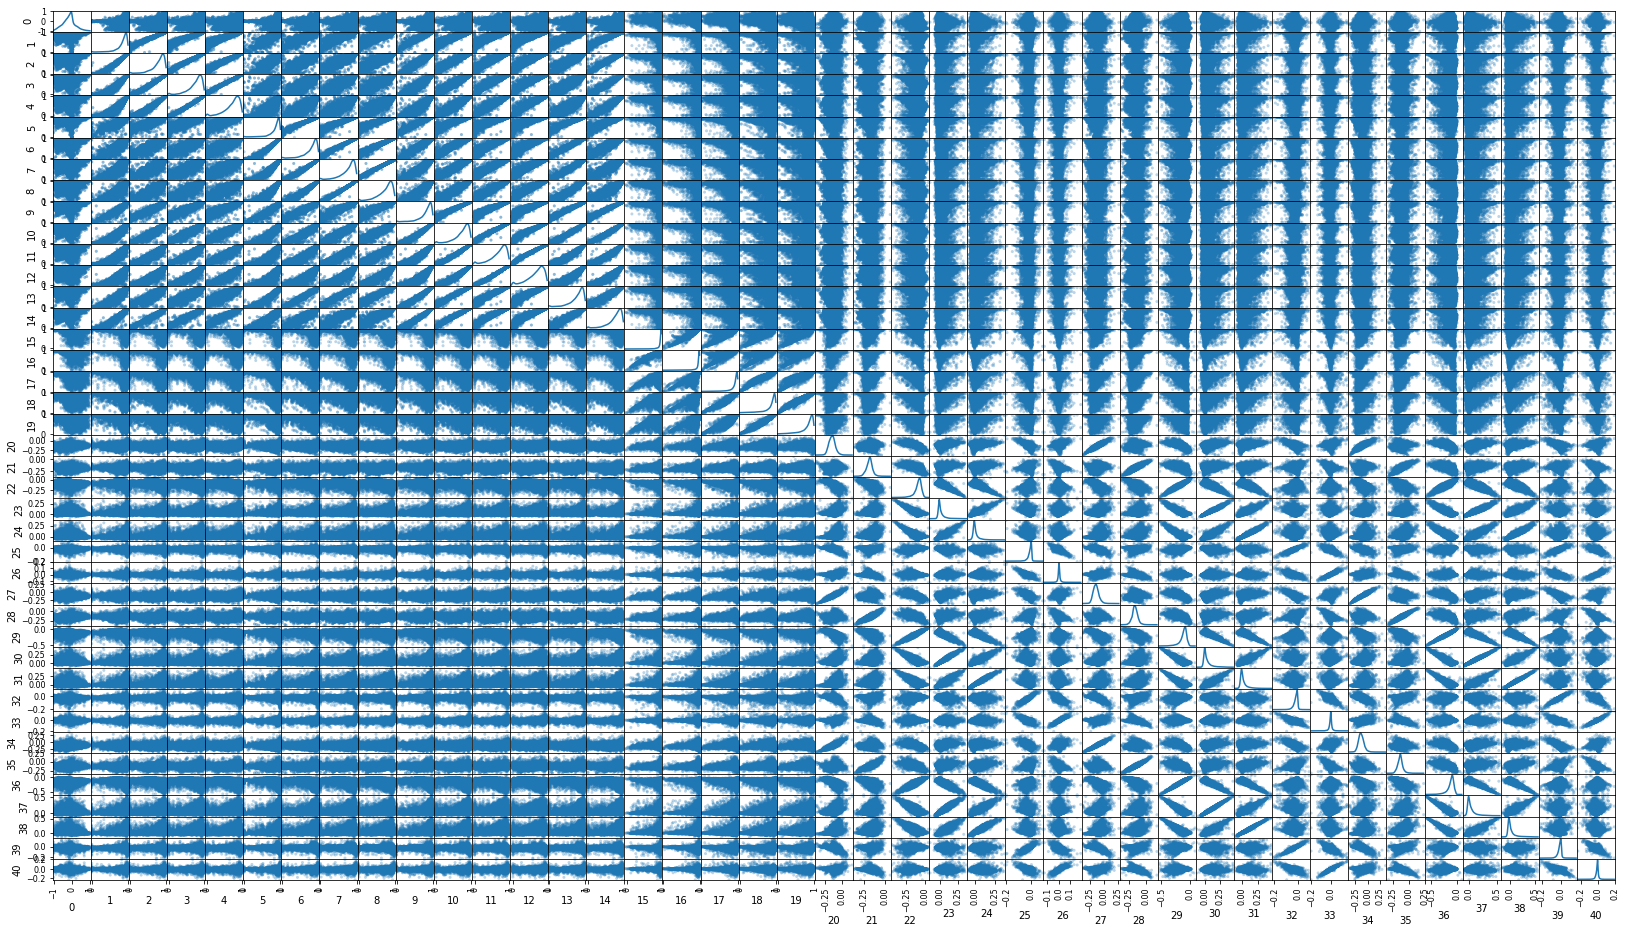

In [29]:
# Plot scatter-matrix of the data
pd.plotting.scatter_matrix(X, alpha = 0.3, figsize = (28, 16), diagonal = 'kde');

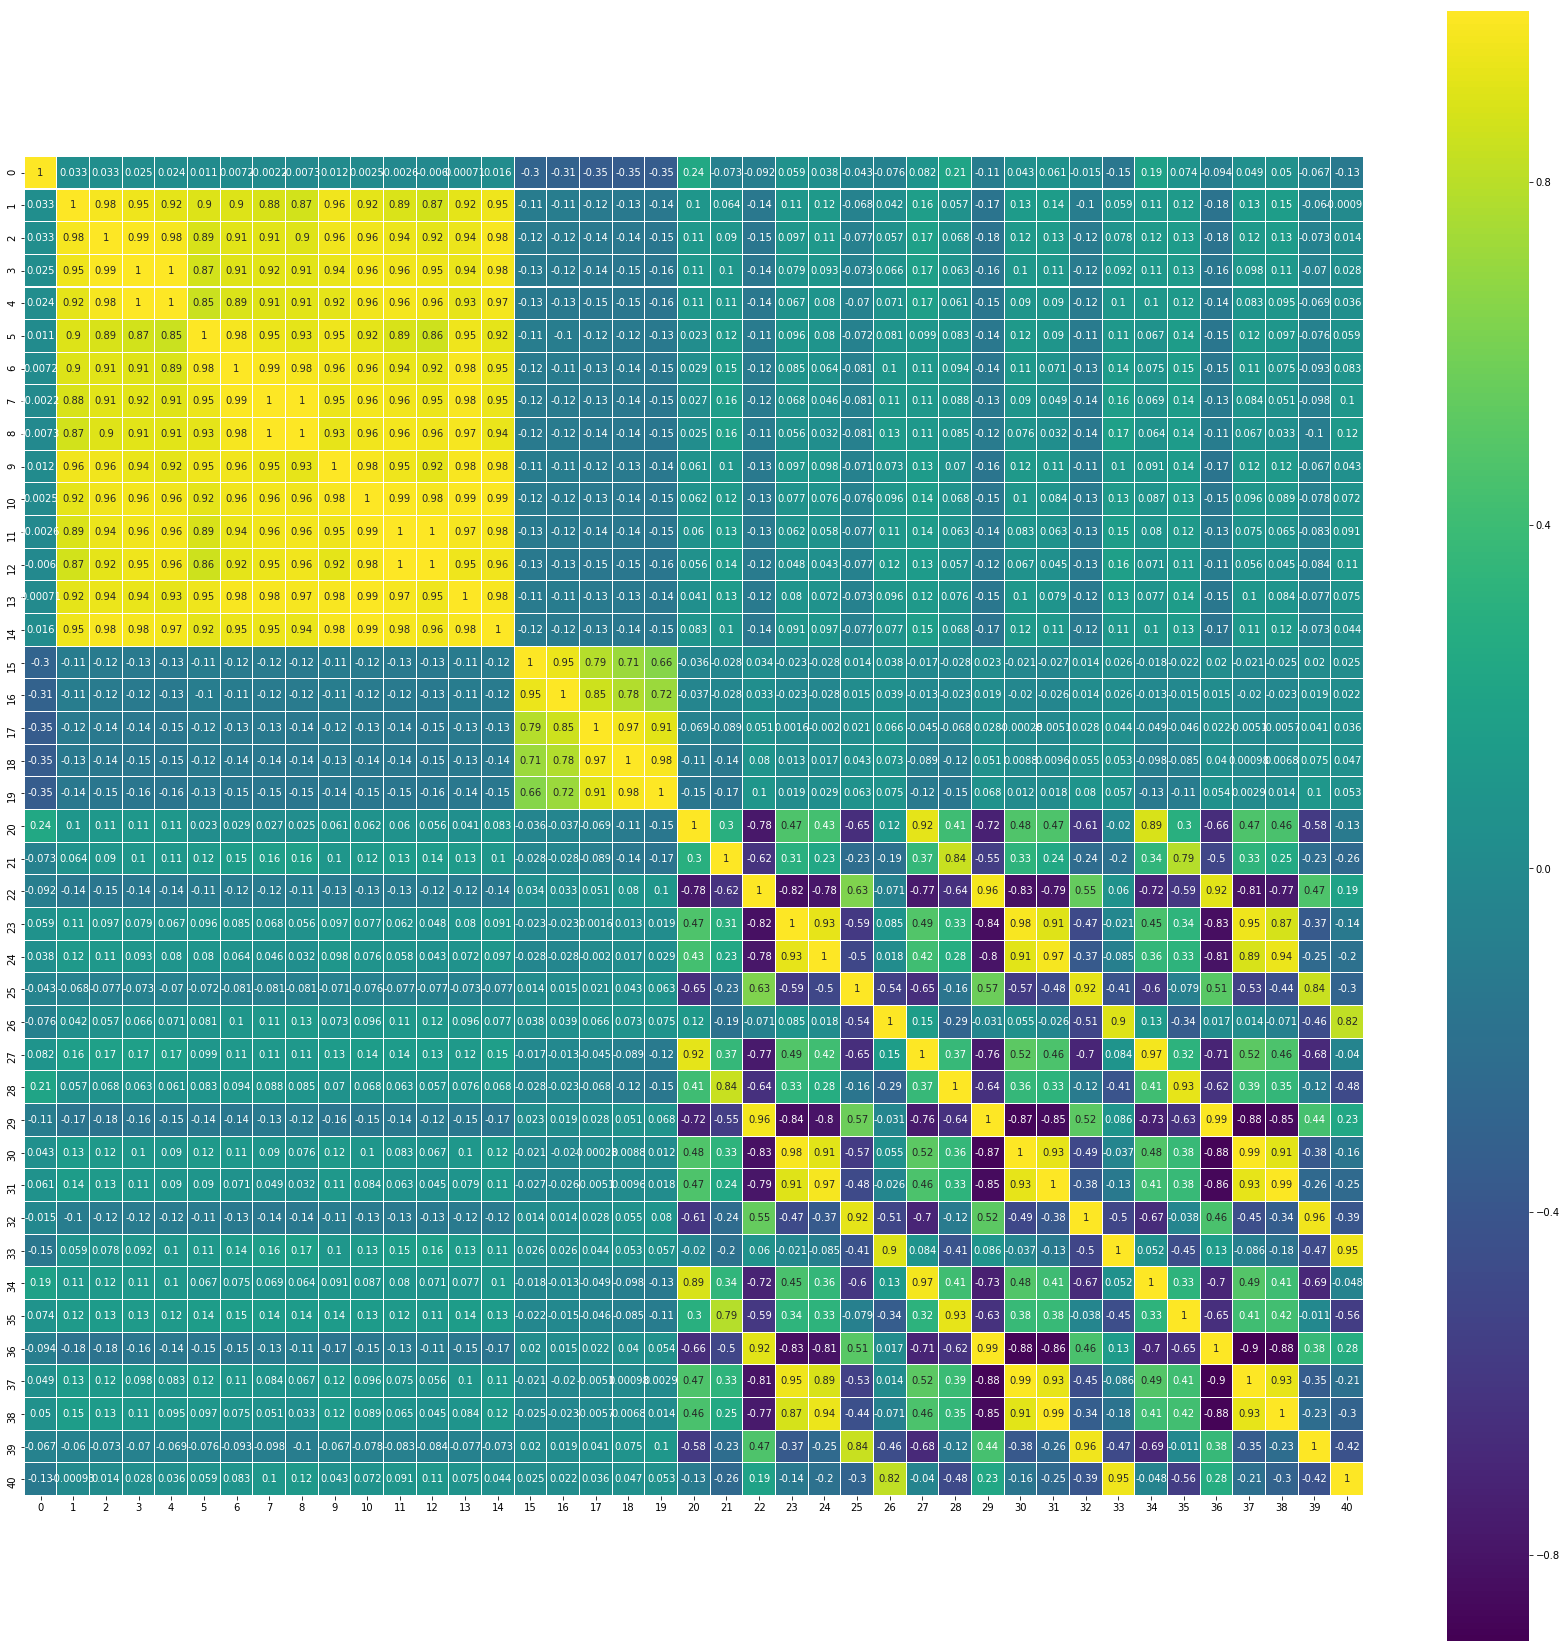

In [19]:
# Plot heatmap of the data
plt.figure(figsize = (30, 30))
sns.heatmap(X.corr(), linewidths = 0.1, vmax = 1.0, square = True, cmap = plt.cm.viridis, annot = True)

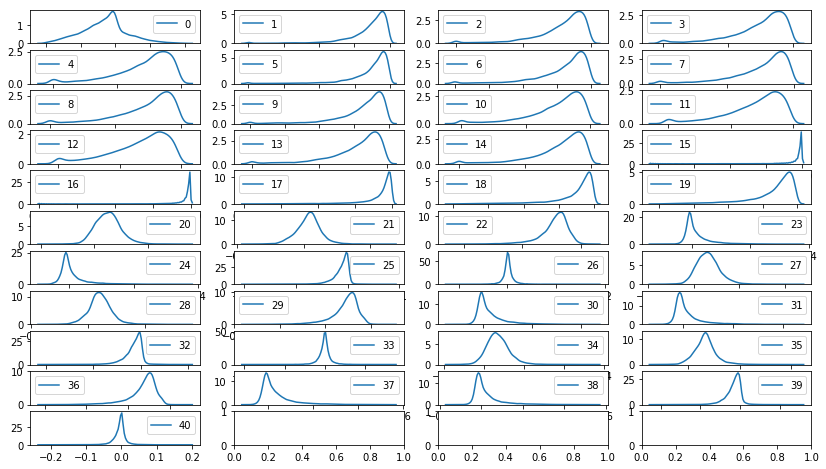

In [26]:
# Display kde plots for each attribute in the data
fig, ax = plt.subplots(figsize = (14, 8), ncols = 4, nrows = 11)

r = 0
c = 0
for i in range(0, 41):
    sns.kdeplot(X[i], ax = ax[r][c])
    c += 1
    if c == 4:
        c = 0
        r += 1

In [15]:
# Detect outliers with respect to each attribute using the IQR rule.
dic = {}

for feature in X.keys():
    Q1 = np.percentile(X[feature], 25)
    Q3 = np.percentile(X[feature], 75)
    step = 1.5 * (Q3 - Q1)
    
    print("Data points considered outliers for the feature '{}':".format(feature))
    outliers = X[~((X[feature] >= Q1 - step) & (X[feature] <= Q3 + step))]
    display(outliers)
    
    for key in outliers.index:
        if key in dic.keys():
            dic[key] += 1
        else:
            dic[key] = 1

Data points considered outliers for the feature '0':


0         1         2         3         4         5         6   \
14    -0.971319  0.953369  0.926344  0.910796  0.898362  0.953439  0.928068   
44     0.557320  0.963232  0.939653  0.922434  0.907248  0.955081  0.925857   
94     0.579001  0.911597  0.873670  0.861528  0.851418  0.901991  0.861480   
129   -0.993723  0.884951  0.801668  0.751581  0.722495  0.934985  0.888549   
159    0.656722  0.976281  0.962042  0.950852  0.941521  0.986476  0.978294   
176    0.796061  0.948710  0.901692  0.858347  0.818808  0.982658  0.967588   
200    0.621549  0.941954  0.911705  0.894954  0.881841  0.939525  0.909030   
205   -0.983969  0.909658  0.843005  0.790946  0.745630  0.923900  0.863830   
232   -0.998708  0.987562  0.979636  0.972971  0.966650  0.990952  0.987671   
253    0.759560  0.989835  0.983067  0.977388  0.971961  0.992051  0.985643   
257    0.561798  0.936705  0.900793  0.882514  0.867334  0.910743  0.859308   
264    0.875450  0.993282  0.988022  0.983484  0.979176  0.994833  0.990636   
308    0.661923  0.984185  0.972866  0.963737  0.955873  0.985332  0.973858   
312    0.667013  0.995584  0.991234  0.986905  0.982573  0.998894  0.998109   
337   -0.962238  0.812366  0.713726  0.663330  0.625289  0.899322  0.840942   
394    0.659746  0.971800  0.957994  0.952058  0.943937  0.970415  0.953779   
397    0.727050  0.992794  0.986892  0.982070  0.977275  0.986072  0.975897   
478    0.597313  0.986603  0.979067  0.972967  0.967043  0.994523  0.991571   
480   -0.977207  0.919785  0.884992  0.868517  0.853730  0.936333  0.909548   
491    0.657685  0.981612  0.969563  0.960906  0.952755  0.990798  0.984910   
528   -0.915922  0.957721  0.939462  0.929841  0.920126  0.957228  0.942734   
533    0.624723  0.885112  0.821201  0.786888  0.761650  0.850438  0.775646   
538    0.805149  0.968601  0.950531  0.939220  0.929965  0.961474  0.941111   
566   -0.965578  0.943622  0.910806  0.893056  0.878400  0.949995  0.923157   
589    0.572427  0.980203  0.968597  0.960521  0.953823  0.987926  0.981044   
595    0.591273  0.977560  0.964516  0.955969  0.949454  0.984791  0.974387   
625   -0.957257  0.930282  0.879496  0.846990  0.827454  0.958230  0.927936   
635   -0.936839  0.978452  0.967474  0.958938  0.950342  0.978883  0.969816   
696    0.577118  0.926091  0.885149  0.862409  0.844500  0.922195  0.882459   
705   -0.972594  0.959005  0.938179  0.925113  0.913983  0.969666  0.955456   
...         ...       ...       ...       ...       ...       ...       ...   
17874 -0.981625  0.875716  0.818551  0.790864  0.765755  0.887001  0.837654   
17877 -0.922442  0.948904  0.918661  0.896508  0.878033  0.963606  0.948561   
17878 -0.964523  0.971839  0.955590  0.941263  0.928360  0.981141  0.976191   
17882 -1.000000  0.861213  0.732686  0.610338  0.498099  0.912914  0.832829   
17925  0.570442  0.955893  0.924962  0.901520  0.880042  0.958957  0.925290   
17927  0.726942  0.884853  0.802281  0.735021  0.678503  0.890695  0.818631   
17938  0.615748  0.965915  0.946059  0.934125  0.925297  0.963489  0.942335   
17939  0.592090  0.977766  0.961831  0.948467  0.937611  0.986372  0.978148   
17944  0.621054  0.950265  0.921581  0.902547  0.886387  0.974261  0.958496   
17947  0.664854  0.965655  0.948801  0.939818  0.932256  0.972313  0.958798   
17956 -0.971009  0.967536  0.956636  0.951175  0.945488  0.983130  0.975781   
18033  0.652723  0.976620  0.961595  0.948608  0.935039  0.982260  0.969928   
18046  0.693261  0.971788  0.950986  0.936627  0.924609  0.970357  0.946769   
18087  0.665398  0.960106  0.934105  0.917987  0.905307  0.969581  0.949707   
18117  0.712026  0.925919  0.892965  0.880305  0.868615  0.927954  0.895179   
18187  0.567575  0.903267  0.841973  0.804658  0.779783  0.904781  0.857712   
18336  0.816788  0.971624  0.948549  0.929619  0.912727  0.978637  0.962524   
18337  0.595986  0.950175  0.915284  0.888415  0.863753  0.957881  0.928811   
18387  0.641955  0.938742  0.908753  0.891985  0.877914  0.9523

Data points considered outliers for the feature '1':


0         1         2         3         4         5         6   \
37    -0.290443  0.453738  0.280600  0.247069  0.210558  0.779788  0.628877   
118   -0.571108  0.582792  0.396569  0.334071  0.288705  0.657844  0.519643   
124   -0.329232  0.517383  0.355044  0.316503  0.283509  0.569142  0.424080   
141   -0.091721  0.506637  0.283139  0.200238  0.151830  0.625385  0.434757   
152   -0.022761  0.442886  0.174645  0.097266  0.045680  0.618274  0.391300   
156   -0.001158 -0.000008 -0.000008 -0.000008 -0.000008 -0.000008 -0.000008   
163    0.100491  0.456561  0.236542  0.169833  0.125504  0.466590  0.251438   
170   -0.002070 -0.000027 -0.000027 -0.000027 -0.000027 -0.000027 -0.000027   
183   -0.576928  0.550656  0.327960  0.242329  0.190229  0.609560  0.411717   
190   -0.560344  0.565972  0.376866  0.315423  0.273153  0.643553  0.505680   
209   -0.007274  0.581642  0.317894  0.145094  0.035956  0.645305  0.381558   
227    0.062697  0.307658  0.153804 -0.000050 -0.000050  0.230731 -0.000050   
265   -0.001347  0.499996 -0.000008 -0.000008 -0.000008 -0.000008 -0.000008   
276   -0.238113  0.593896  0.396400  0.323380  0.277136  0.370110  0.225904   
386    0.004401  0.433268  0.237236  0.101608  0.033794  0.366594  0.299920   
407   -0.028073  0.452800  0.364944  0.322271  0.231904  0.575794  0.417657   
411   -0.029387  0.551026  0.378221  0.282815  0.224076  0.518695  0.290628   
413   -0.078701  0.499029  0.295398  0.221107  0.164641  0.567788  0.364344   
415   -0.002380  0.287119  0.149142  0.091651  0.057156  0.508517  0.300351   
479    0.063075  0.350114  0.196149  0.142158  0.095226  0.474453  0.355806   
482   -0.006040  0.592954  0.271522  0.117986  0.036011  0.715391  0.456655   
492   -0.004749  0.249943 -0.000077 -0.000077 -0.000077  0.699977  0.449958   
542    0.139797  0.553749  0.339329  0.253964  0.196943  0.623229  0.444027   
582   -0.001064 -0.000031 -0.000031 -0.000031 -0.000031  0.374981  0.124973   
596   -0.168875  0.470760  0.290055  0.269164  0.240519  0.556245  0.365026   
627   -0.011411  0.542290  0.346465  0.280415  0.235361  0.557584  0.380307   
690   -0.003150 -0.000057 -0.000057 -0.000058 -0.000058  0.199954 -0.000057   
714    0.103516  0.508817  0.307180  0.247325  0.201482  0.461500  0.284062   
737    0.001676  0.333295 -0.000057 -0.000058 -0.000058  0.666648  0.466636   
766   -0.017224  0.545602  0.308635  0.226567  0.174301  0.548747  0.318135   
...         ...       ...       ...       ...       ...       ...       ...   
18980 -0.167473  0.245797  0.059148  0.043143  0.035390  0.406992  0.160338   
18982 -0.112742  0.591232  0.394449  0.302934  0.236236  0.632947  0.452037   
18984 -0.005522 -0.000019 -0.000019 -0.000019 -0.000019 -0.000019 -0.000019   
18985 -0.004410 -0.000008 -0.000008 -0.000008 -0.000008 -0.000008 -0.000008   
18987 -0.031282  0.041952 -0.000182  0.021120 -0.000181  0.040637 -0.000186   
18989 -0.015711  0.142788 -0.000080  0.238034  0.190411  0.619017  0.380903   
18991 -0.016845 -0.000151 -0.000151 -0.000152 -0.000150  0.658229  0.538570   
18996 -0.045142  0.495161  0.285929  0.178431  0.124680  0.708912  0.545593   
19009 -0.027661  0.283551  0.120194  0.082266  0.049326  0.289643  0.113934   
19010 -0.015767  0.171207  0.028311  0.028310  0.014020  0.273195  0.158053   
19021 -0.352588  0.490053  0.414106  0.384011  0.392387  0.664986  0.577530   
19022 -0.060375  0.555407  0.340099  0.216980  0.137737  0.675282  0.523297   
19034 -0.067917  0.485916  0.270279  0.197628  0.141633  0.521188  0.300823   
19035 -0.010078  0.399989 -0.000019 -0.000019 -0.000019  0.399989  0.399989   
19036 -0.228865  0.496893  0.274937  0.174912  0.087563  0.573229  0.397086   
19037 -0.011503  0.413728  0.206808  0.068862 -0.000112  0.448215  0.275782   
19061 -0.106410  0.295151  0.122689  0.096195  0.069001  0.366690  0.194641   
19144 -0.002845  0.437466  0.062443 -0.000061 -0.000062  0.374962  0.124946   
19145 -0.001911 -0.000004 -0.000004 -0.000004 -0.000004 -0.0000

Data points considered outliers for the feature '2':


0         1         2         3         4         5         6   \
37    -0.290443  0.453738  0.280600  0.247069  0.210558  0.779788  0.628877   
124   -0.329232  0.517383  0.355044  0.316503  0.283509  0.569142  0.424080   
141   -0.091721  0.506637  0.283139  0.200238  0.151830  0.625385  0.434757   
152   -0.022761  0.442886  0.174645  0.097266  0.045680  0.618274  0.391300   
156   -0.001158 -0.000008 -0.000008 -0.000008 -0.000008 -0.000008 -0.000008   
163    0.100491  0.456561  0.236542  0.169833  0.125504  0.466590  0.251438   
170   -0.002070 -0.000027 -0.000027 -0.000027 -0.000027 -0.000027 -0.000027   
183   -0.576928  0.550656  0.327960  0.242329  0.190229  0.609560  0.411717   
190   -0.560344  0.565972  0.376866  0.315423  0.273153  0.643553  0.505680   
209   -0.007274  0.581642  0.317894  0.145094  0.035956  0.645305  0.381558   
227    0.062697  0.307658  0.153804 -0.000050 -0.000050  0.230731 -0.000050   
265   -0.001347  0.499996 -0.000008 -0.000008 -0.000008 -0.000008 -0.000008   
386    0.004401  0.433268  0.237236  0.101608  0.033794  0.366594  0.299920   
407   -0.028073  0.452800  0.364944  0.322271  0.231904  0.575794  0.417657   
411   -0.029387  0.551026  0.378221  0.282815  0.224076  0.518695  0.290628   
413   -0.078701  0.499029  0.295398  0.221107  0.164641  0.567788  0.364344   
415   -0.002380  0.287119  0.149142  0.091651  0.057156  0.508517  0.300351   
479    0.063075  0.350114  0.196149  0.142158  0.095226  0.474453  0.355806   
482   -0.006040  0.592954  0.271522  0.117986  0.036011  0.715391  0.456655   
492   -0.004749  0.249943 -0.000077 -0.000077 -0.000077  0.699977  0.449958   
542    0.139797  0.553749  0.339329  0.253964  0.196943  0.623229  0.444027   
582   -0.001064 -0.000031 -0.000031 -0.000031 -0.000031  0.374981  0.124973   
596   -0.168875  0.470760  0.290055  0.269164  0.240519  0.556245  0.365026   
627   -0.011411  0.542290  0.346465  0.280415  0.235361  0.557584  0.380307   
690   -0.003150 -0.000057 -0.000057 -0.000058 -0.000058  0.199954 -0.000057   
714    0.103516  0.508817  0.307180  0.247325  0.201482  0.461500  0.284062   
737    0.001676  0.333295 -0.000057 -0.000058 -0.000058  0.666648  0.466636   
766   -0.017224  0.545602  0.308635  0.226567  0.174301  0.548747  0.318135   
820    0.034931  0.581312  0.384901  0.318749  0.283425  0.595083  0.411856   
953   -0.005456  0.466575  0.155410  0.066505  0.022053  0.644383  0.422123   
...         ...       ...       ...       ...       ...       ...       ...   
18959 -0.067973  0.520188  0.382464  0.318252  0.276825  0.563331  0.428368   
18970 -0.032727  0.598835  0.346673  0.190025  0.102149  0.681680  0.586930   
18980 -0.167473  0.245797  0.059148  0.043143  0.035390  0.406992  0.160338   
18984 -0.005522 -0.000019 -0.000019 -0.000019 -0.000019 -0.000019 -0.000019   
18985 -0.004410 -0.000008 -0.000008 -0.000008 -0.000008 -0.000008 -0.000008   
18987 -0.031282  0.041952 -0.000182  0.021120 -0.000181  0.040637 -0.000186   
18989 -0.015711  0.142788 -0.000080  0.238034  0.190411  0.619017  0.380903   
18991 -0.016845 -0.000151 -0.000151 -0.000152 -0.000150  0.658229  0.538570   
18996 -0.045142  0.495161  0.285929  0.178431  0.124680  0.708912  0.545593   
19009 -0.027661  0.283551  0.120194  0.082266  0.049326  0.289643  0.113934   
19010 -0.015767  0.171207  0.028311  0.028310  0.014020  0.273195  0.158053   
19022 -0.060375  0.555407  0.340099  0.216980  0.137737  0.675282  0.523297   
19029 -0.010643  0.620648  0.310268  0.068862 -0.000112  0.482701  0.275782   
19034 -0.067917  0.485916  0.270279  0.197628  0.141633  0.521188  0.300823   
19035 -0.010078  0.399989 -0.000019 -0.000019 -0.000019  0.399989  0.399989   
19036 -0.228865  0.496893  0.274937  0.174912  0.087563  0.573229  0.397086   
19037 -0.011503  0.413728  0.206808  0.068862 -0.000112  0.448215  0.275782   
19061 -0.106410  0.295151  0.122689  0.096195  0.069001  0.366690  0.194641   
19144 -0.002845  0.437466  0.062443 -0.000061 -0.000062  0.3749

Data points considered outliers for the feature '3':


0         1         2         3         4         5         6   \
37    -0.290443  0.453738  0.280600  0.247069  0.210558  0.779788  0.628877   
141   -0.091721  0.506637  0.283139  0.200238  0.151830  0.625385  0.434757   
152   -0.022761  0.442886  0.174645  0.097266  0.045680  0.618274  0.391300   
156   -0.001158 -0.000008 -0.000008 -0.000008 -0.000008 -0.000008 -0.000008   
163    0.100491  0.456561  0.236542  0.169833  0.125504  0.466590  0.251438   
170   -0.002070 -0.000027 -0.000027 -0.000027 -0.000027 -0.000027 -0.000027   
183   -0.576928  0.550656  0.327960  0.242329  0.190229  0.609560  0.411717   
209   -0.007274  0.581642  0.317894  0.145094  0.035956  0.645305  0.381558   
227    0.062697  0.307658  0.153804 -0.000050 -0.000050  0.230731 -0.000050   
265   -0.001347  0.499996 -0.000008 -0.000008 -0.000008 -0.000008 -0.000008   
363   -0.006477  0.597309  0.389861  0.243426  0.145803  0.664424  0.456976   
386    0.004401  0.433268  0.237236  0.101608  0.033794  0.366594  0.299920   
413   -0.078701  0.499029  0.295398  0.221107  0.164641  0.567788  0.364344   
415   -0.002380  0.287119  0.149142  0.091651  0.057156  0.508517  0.300351   
479    0.063075  0.350114  0.196149  0.142158  0.095226  0.474453  0.355806   
482   -0.006040  0.592954  0.271522  0.117986  0.036011  0.715391  0.456655   
492   -0.004749  0.249943 -0.000077 -0.000077 -0.000077  0.699977  0.449958   
542    0.139797  0.553749  0.339329  0.253964  0.196943  0.623229  0.444027   
582   -0.001064 -0.000031 -0.000031 -0.000031 -0.000031  0.374981  0.124973   
596   -0.168875  0.470760  0.290055  0.269164  0.240519  0.556245  0.365026   
690   -0.003150 -0.000057 -0.000057 -0.000058 -0.000058  0.199954 -0.000057   
714    0.103516  0.508817  0.307180  0.247325  0.201482  0.461500  0.284062   
737    0.001676  0.333295 -0.000057 -0.000058 -0.000058  0.666648  0.466636   
766   -0.017224  0.545602  0.308635  0.226567  0.174301  0.548747  0.318135   
953   -0.005456  0.466575  0.155410  0.066505  0.022053  0.644383  0.422123   
1010  -0.098179 -0.000023 -0.000023 -0.000023 -0.000023  0.333318  0.166648   
1085  -0.123829  0.527510  0.299253  0.217830  0.179295  0.592204  0.398114   
1103   0.252691  0.380057  0.134919  0.123996  0.110747  0.518830  0.312148   
1149   0.057247  0.256603  0.155975  0.112472  0.079640  0.421676  0.292716   
1152  -0.005139  0.150448  0.109340  0.027125 -0.000281  0.506712  0.369687   
...         ...       ...       ...       ...       ...       ...       ...   
18955 -0.039798  0.123751  0.029077  0.066502  0.048886  0.040819  0.025636   
18970 -0.032727  0.598835  0.346673  0.190025  0.102149  0.681680  0.586930   
18980 -0.167473  0.245797  0.059148  0.043143  0.035390  0.406992  0.160338   
18984 -0.005522 -0.000019 -0.000019 -0.000019 -0.000019 -0.000019 -0.000019   
18985 -0.004410 -0.000008 -0.000008 -0.000008 -0.000008 -0.000008 -0.000008   
18987 -0.031282  0.041952 -0.000182  0.021120 -0.000181  0.040637 -0.000186   
18989 -0.015711  0.142788 -0.000080  0.238034  0.190411  0.619017  0.380903   
18991 -0.016845 -0.000151 -0.000151 -0.000152 -0.000150  0.658229  0.538570   
18996 -0.045142  0.495161  0.285929  0.178431  0.124680  0.708912  0.545593   
19009 -0.027661  0.283551  0.120194  0.082266  0.049326  0.289643  0.113934   
19010 -0.015767  0.171207  0.028311  0.028310  0.014020  0.273195  0.158053   
19022 -0.060375  0.555407  0.340099  0.216980  0.137737  0.675282  0.523297   
19029 -0.010643  0.620648  0.310268  0.068862 -0.000112  0.482701  0.275782   
19034 -0.067917  0.485916  0.270279  0.197628  0.141633  0.521188  0.300823   
19035 -0.010078  0.399989 -0.000019 -0.000019 -0.000019  0.399989  0.399989   
19036 -0.228865  0.496893  0.274937  0.174912  0.087563  0.573229  0.397086   
19037 -0.011503  0.413728  0.206808  0.068862 -0.000112  0.448215  0.275782   
19061 -0.106410  0.295151  0.122689  0.096195  0.069001  0.366690  0.194641   
19144 -0.002845  0.437466  0.062443 -0.000061 -0.000062  0.3749

Data points considered outliers for the feature '4':


0         1         2         3         4         5         6   \
141   -0.091721  0.506637  0.283139  0.200238  0.151830  0.625385  0.434757   
152   -0.022761  0.442886  0.174645  0.097266  0.045680  0.618274  0.391300   
156   -0.001158 -0.000008 -0.000008 -0.000008 -0.000008 -0.000008 -0.000008   
163    0.100491  0.456561  0.236542  0.169833  0.125504  0.466590  0.251438   
170   -0.002070 -0.000027 -0.000027 -0.000027 -0.000027 -0.000027 -0.000027   
209   -0.007274  0.581642  0.317894  0.145094  0.035956  0.645305  0.381558   
227    0.062697  0.307658  0.153804 -0.000050 -0.000050  0.230731 -0.000050   
265   -0.001347  0.499996 -0.000008 -0.000008 -0.000008 -0.000008 -0.000008   
275   -0.500975  0.685660  0.454039  0.288596  0.172784  0.789061  0.669115   
363   -0.006477  0.597309  0.389861  0.243426  0.145803  0.664424  0.456976   
386    0.004401  0.433268  0.237236  0.101608  0.033794  0.366594  0.299920   
413   -0.078701  0.499029  0.295398  0.221107  0.164641  0.567788  0.364344   
415   -0.002380  0.287119  0.149142  0.091651  0.057156  0.508517  0.300351   
479    0.063075  0.350114  0.196149  0.142158  0.095226  0.474453  0.355806   
482   -0.006040  0.592954  0.271522  0.117986  0.036011  0.715391  0.456655   
492   -0.004749  0.249943 -0.000077 -0.000077 -0.000077  0.699977  0.449958   
582   -0.001064 -0.000031 -0.000031 -0.000031 -0.000031  0.374981  0.124973   
690   -0.003150 -0.000057 -0.000057 -0.000058 -0.000058  0.199954 -0.000057   
737    0.001676  0.333295 -0.000057 -0.000058 -0.000058  0.666648  0.466636   
766   -0.017224  0.545602  0.308635  0.226567  0.174301  0.548747  0.318135   
953   -0.005456  0.466575  0.155410  0.066505  0.022053  0.644383  0.422123   
1010  -0.098179 -0.000023 -0.000023 -0.000023 -0.000023  0.333318  0.166648   
1085  -0.123829  0.527510  0.299253  0.217830  0.179295  0.592204  0.398114   
1103   0.252691  0.380057  0.134919  0.123996  0.110747  0.518830  0.312148   
1149   0.057247  0.256603  0.155975  0.112472  0.079640  0.421676  0.292716   
1152  -0.005139  0.150448  0.109340  0.027125 -0.000281  0.506712  0.369687   
1171  -0.014395  0.311671  0.111575  0.095566  0.047542  0.407717  0.255644   
1187  -0.005616  0.562222  0.345072  0.242094  0.155917  0.368263  0.118028   
1207  -0.007581  0.622166  0.382189  0.254541  0.167740  0.703860  0.514942   
1245   0.000669  0.299973 -0.000038 -0.000038 -0.000038  0.199969 -0.000038   
...         ...       ...       ...       ...       ...       ...       ...   
18947 -0.063417  0.270889  0.159145  0.134367  0.112966  0.340365  0.211895   
18955 -0.039798  0.123751  0.029077  0.066502  0.048886  0.040819  0.025636   
18970 -0.032727  0.598835  0.346673  0.190025  0.102149  0.681680  0.586930   
18980 -0.167473  0.245797  0.059148  0.043143  0.035390  0.406992  0.160338   
18984 -0.005522 -0.000019 -0.000019 -0.000019 -0.000019 -0.000019 -0.000019   
18985 -0.004410 -0.000008 -0.000008 -0.000008 -0.000008 -0.000008 -0.000008   
18987 -0.031282  0.041952 -0.000182  0.021120 -0.000181  0.040637 -0.000186   
18988 -0.022907  0.631552  0.473646  0.315740  0.157833  0.315740  0.052563   
18991 -0.016845 -0.000151 -0.000151 -0.000152 -0.000150  0.658229  0.538570   
18996 -0.045142  0.495161  0.285929  0.178431  0.124680  0.708912  0.545593   
19009 -0.027661  0.283551  0.120194  0.082266  0.049326  0.289643  0.113934   
19010 -0.015767  0.171207  0.028311  0.028310  0.014020  0.273195  0.158053   
19022 -0.060375  0.555407  0.340099  0.216980  0.137737  0.675282  0.523297   
19029 -0.010643  0.620648  0.310268  0.068862 -0.000112  0.482701  0.275782   
19034 -0.067917  0.485916  0.270279  0.197628  0.141633  0.521188  0.300823   
19035 -0.010078  0.399989 -0.000019 -0.000019 -0.000019  0.399989  0.399989   
19036 -0.228865  0.496893  0.274937  0.174912  0.087563  0.573229  0.397086   
19037 -0.011503  0.413728  0.206808  0.068862 -0.000112  0.448215  0.275782   
19061 -0.106410  0.295151  0.122689  0.096195  0.069001  0.3666

Data points considered outliers for the feature '5':


0         1         2         3         4         5         6   \
27    -0.003581  0.695850  0.560589  0.510510  0.462601  0.603975  0.437303   
124   -0.329232  0.517383  0.355044  0.316503  0.283509  0.569142  0.424080   
141   -0.091721  0.506637  0.283139  0.200238  0.151830  0.625385  0.434757   
152   -0.022761  0.442886  0.174645  0.097266  0.045680  0.618274  0.391300   
156   -0.001158 -0.000008 -0.000008 -0.000008 -0.000008 -0.000008 -0.000008   
163    0.100491  0.456561  0.236542  0.169833  0.125504  0.466590  0.251438   
170   -0.002070 -0.000027 -0.000027 -0.000027 -0.000027 -0.000027 -0.000027   
183   -0.576928  0.550656  0.327960  0.242329  0.190229  0.609560  0.411717   
227    0.062697  0.307658  0.153804 -0.000050 -0.000050  0.230731 -0.000050   
265   -0.001347  0.499996 -0.000008 -0.000008 -0.000008 -0.000008 -0.000008   
276   -0.238113  0.593896  0.396400  0.323380  0.277136  0.370110  0.225904   
386    0.004401  0.433268  0.237236  0.101608  0.033794  0.366594  0.299920   
407   -0.028073  0.452800  0.364944  0.322271  0.231904  0.575794  0.417657   
411   -0.029387  0.551026  0.378221  0.282815  0.224076  0.518695  0.290628   
413   -0.078701  0.499029  0.295398  0.221107  0.164641  0.567788  0.364344   
415   -0.002380  0.287119  0.149142  0.091651  0.057156  0.508517  0.300351   
448   -0.290835  0.649366  0.473315  0.402471  0.356755  0.346048  0.232896   
479    0.063075  0.350114  0.196149  0.142158  0.095226  0.474453  0.355806   
504   -0.703520  0.618163  0.438716  0.378795  0.336994  0.571004  0.404850   
542    0.139797  0.553749  0.339329  0.253964  0.196943  0.623229  0.444027   
582   -0.001064 -0.000031 -0.000031 -0.000031 -0.000031  0.374981  0.124973   
596   -0.168875  0.470760  0.290055  0.269164  0.240519  0.556245  0.365026   
627   -0.011411  0.542290  0.346465  0.280415  0.235361  0.557584  0.380307   
690   -0.003150 -0.000057 -0.000057 -0.000058 -0.000058  0.199954 -0.000057   
706   -0.071433  0.637988  0.519409  0.523897  0.501435  0.542769  0.394545   
714    0.103516  0.508817  0.307180  0.247325  0.201482  0.461500  0.284062   
766   -0.017224  0.545602  0.308635  0.226567  0.174301  0.548747  0.318135   
820    0.034931  0.581312  0.384901  0.318749  0.283425  0.595083  0.411856   
825   -0.472407  0.635396  0.439918  0.361631  0.315174  0.424585  0.258717   
940   -0.663675  0.626767  0.461220  0.405138  0.365528  0.585947  0.431686   
...         ...       ...       ...       ...       ...       ...       ...   
18983 -0.103102  0.820483  0.760383  0.732364  0.702306  0.503597  0.405011   
18984 -0.005522 -0.000019 -0.000019 -0.000019 -0.000019 -0.000019 -0.000019   
18985 -0.004410 -0.000008 -0.000008 -0.000008 -0.000008 -0.000008 -0.000008   
18987 -0.031282  0.041952 -0.000182  0.021120 -0.000181  0.040637 -0.000186   
18988 -0.022907  0.631552  0.473646  0.315740  0.157833  0.315740  0.052563   
18989 -0.015711  0.142788 -0.000080  0.238034  0.190411  0.619017  0.380903   
19009 -0.027661  0.283551  0.120194  0.082266  0.049326  0.289643  0.113934   
19010 -0.015767  0.171207  0.028311  0.028310  0.014020  0.273195  0.158053   
19029 -0.010643  0.620648  0.310268  0.068862 -0.000112  0.482701  0.275782   
19034 -0.067917  0.485916  0.270279  0.197628  0.141633  0.521188  0.300823   
19035 -0.010078  0.399989 -0.000019 -0.000019 -0.000019  0.399989  0.399989   
19036 -0.228865  0.496893  0.274937  0.174912  0.087563  0.573229  0.397086   
19037 -0.011503  0.413728  0.206808  0.068862 -0.000112  0.448215  0.275782   
19061 -0.106410  0.295151  0.122689  0.096195  0.069001  0.366690  0.194641   
19064 -0.186290  0.798299  0.702147  0.638744  0.579836  0.553669  0.404938   
19070 -0.142461  0.627911  0.503606  0.461923  0.413355  0.535557  0.357098   
19144 -0.002845  0.437466  0.062443 -0.000061 -0.000062  0.374962  0.124946   
19145 -0.001911 -0.000004 -0.000004 -0.000004 -0.000004 -0.000004 -0.000004   
19147 -0.030180  0.877005  0.836843  0.819272  0.804211  0.3950

Data points considered outliers for the feature '6':


0         1         2         3         4         5         6   \
124   -0.329232  0.517383  0.355044  0.316503  0.283509  0.569142  0.424080   
152   -0.022761  0.442886  0.174645  0.097266  0.045680  0.618274  0.391300   
156   -0.001158 -0.000008 -0.000008 -0.000008 -0.000008 -0.000008 -0.000008   
163    0.100491  0.456561  0.236542  0.169833  0.125504  0.466590  0.251438   
170   -0.002070 -0.000027 -0.000027 -0.000027 -0.000027 -0.000027 -0.000027   
183   -0.576928  0.550656  0.327960  0.242329  0.190229  0.609560  0.411717   
209   -0.007274  0.581642  0.317894  0.145094  0.035956  0.645305  0.381558   
227    0.062697  0.307658  0.153804 -0.000050 -0.000050  0.230731 -0.000050   
265   -0.001347  0.499996 -0.000008 -0.000008 -0.000008 -0.000008 -0.000008   
276   -0.238113  0.593896  0.396400  0.323380  0.277136  0.370110  0.225904   
386    0.004401  0.433268  0.237236  0.101608  0.033794  0.366594  0.299920   
407   -0.028073  0.452800  0.364944  0.322271  0.231904  0.575794  0.417657   
411   -0.029387  0.551026  0.378221  0.282815  0.224076  0.518695  0.290628   
413   -0.078701  0.499029  0.295398  0.221107  0.164641  0.567788  0.364344   
415   -0.002380  0.287119  0.149142  0.091651  0.057156  0.508517  0.300351   
448   -0.290835  0.649366  0.473315  0.402471  0.356755  0.346048  0.232896   
479    0.063075  0.350114  0.196149  0.142158  0.095226  0.474453  0.355806   
504   -0.703520  0.618163  0.438716  0.378795  0.336994  0.571004  0.404850   
582   -0.001064 -0.000031 -0.000031 -0.000031 -0.000031  0.374981  0.124973   
596   -0.168875  0.470760  0.290055  0.269164  0.240519  0.556245  0.365026   
627   -0.011411  0.542290  0.346465  0.280415  0.235361  0.557584  0.380307   
690   -0.003150 -0.000057 -0.000057 -0.000058 -0.000058  0.199954 -0.000057   
706   -0.071433  0.637988  0.519409  0.523897  0.501435  0.542769  0.394545   
714    0.103516  0.508817  0.307180  0.247325  0.201482  0.461500  0.284062   
766   -0.017224  0.545602  0.308635  0.226567  0.174301  0.548747  0.318135   
820    0.034931  0.581312  0.384901  0.318749  0.283425  0.595083  0.411856   
825   -0.472407  0.635396  0.439918  0.361631  0.315174  0.424585  0.258717   
953   -0.005456  0.466575  0.155410  0.066505  0.022053  0.644383  0.422123   
1010  -0.098179 -0.000023 -0.000023 -0.000023 -0.000023  0.333318  0.166648   
1085  -0.123829  0.527510  0.299253  0.217830  0.179295  0.592204  0.398114   
...         ...       ...       ...       ...       ...       ...       ...   
18984 -0.005522 -0.000019 -0.000019 -0.000019 -0.000019 -0.000019 -0.000019   
18985 -0.004410 -0.000008 -0.000008 -0.000008 -0.000008 -0.000008 -0.000008   
18987 -0.031282  0.041952 -0.000182  0.021120 -0.000181  0.040637 -0.000186   
18988 -0.022907  0.631552  0.473646  0.315740  0.157833  0.315740  0.052563   
18989 -0.015711  0.142788 -0.000080  0.238034  0.190411  0.619017  0.380903   
19009 -0.027661  0.283551  0.120194  0.082266  0.049326  0.289643  0.113934   
19010 -0.015767  0.171207  0.028311  0.028310  0.014020  0.273195  0.158053   
19029 -0.010643  0.620648  0.310268  0.068862 -0.000112  0.482701  0.275782   
19034 -0.067917  0.485916  0.270279  0.197628  0.141633  0.521188  0.300823   
19035 -0.010078  0.399989 -0.000019 -0.000019 -0.000019  0.399989  0.399989   
19036 -0.228865  0.496893  0.274937  0.174912  0.087563  0.573229  0.397086   
19037 -0.011503  0.413728  0.206808  0.068862 -0.000112  0.448215  0.275782   
19061 -0.106410  0.295151  0.122689  0.096195  0.069001  0.366690  0.194641   
19064 -0.186290  0.798299  0.702147  0.638744  0.579836  0.553669  0.404938   
19070 -0.142461  0.627911  0.503606  0.461923  0.413355  0.535557  0.357098   
19144 -0.002845  0.437466  0.062443 -0.000061 -0.000062  0.374962  0.124946   
19145 -0.001911 -0.000004 -0.000004 -0.000004 -0.000004 -0.000004 -0.000004   
19147 -0.030180  0.877005  0.836843  0.819272  0.804211  0.395067  0.026117   
19182 -0.106878  0.621033  0.459257  0.393886  0.357497  0.5656

Data points considered outliers for the feature '7':


0         1         2         3         4         5         6   \
152   -0.022761  0.442886  0.174645  0.097266  0.045680  0.618274  0.391300   
156   -0.001158 -0.000008 -0.000008 -0.000008 -0.000008 -0.000008 -0.000008   
163    0.100491  0.456561  0.236542  0.169833  0.125504  0.466590  0.251438   
170   -0.002070 -0.000027 -0.000027 -0.000027 -0.000027 -0.000027 -0.000027   
209   -0.007274  0.581642  0.317894  0.145094  0.035956  0.645305  0.381558   
227    0.062697  0.307658  0.153804 -0.000050 -0.000050  0.230731 -0.000050   
265   -0.001347  0.499996 -0.000008 -0.000008 -0.000008 -0.000008 -0.000008   
276   -0.238113  0.593896  0.396400  0.323380  0.277136  0.370110  0.225904   
386    0.004401  0.433268  0.237236  0.101608  0.033794  0.366594  0.299920   
411   -0.029387  0.551026  0.378221  0.282815  0.224076  0.518695  0.290628   
413   -0.078701  0.499029  0.295398  0.221107  0.164641  0.567788  0.364344   
415   -0.002380  0.287119  0.149142  0.091651  0.057156  0.508517  0.300351   
448   -0.290835  0.649366  0.473315  0.402471  0.356755  0.346048  0.232896   
482   -0.006040  0.592954  0.271522  0.117986  0.036011  0.715391  0.456655   
492   -0.004749  0.249943 -0.000077 -0.000077 -0.000077  0.699977  0.449958   
582   -0.001064 -0.000031 -0.000031 -0.000031 -0.000031  0.374981  0.124973   
690   -0.003150 -0.000057 -0.000057 -0.000058 -0.000058  0.199954 -0.000057   
714    0.103516  0.508817  0.307180  0.247325  0.201482  0.461500  0.284062   
766   -0.017224  0.545602  0.308635  0.226567  0.174301  0.548747  0.318135   
825   -0.472407  0.635396  0.439918  0.361631  0.315174  0.424585  0.258717   
953   -0.005456  0.466575  0.155410  0.066505  0.022053  0.644383  0.422123   
1010  -0.098179 -0.000023 -0.000023 -0.000023 -0.000023  0.333318  0.166648   
1103   0.252691  0.380057  0.134919  0.123996  0.110747  0.518830  0.312148   
1149   0.057247  0.256603  0.155975  0.112472  0.079640  0.421676  0.292716   
1171  -0.014395  0.311671  0.111575  0.095566  0.047542  0.407717  0.255644   
1187  -0.005616  0.562222  0.345072  0.242094  0.155917  0.368263  0.118028   
1245   0.000669  0.299973 -0.000038 -0.000038 -0.000038  0.199969 -0.000038   
1335  -0.007199  0.333142  0.079736  0.079735  0.026386  0.533200  0.306467   
1345  -0.066594  0.558213  0.327065  0.227355  0.157572  0.585870  0.393065   
1350  -0.261832  0.644170  0.434823  0.315654  0.243410  0.465846  0.183044   
...         ...       ...       ...       ...       ...       ...       ...   
18957 -0.078305  0.616783  0.504649  0.450211  0.392516  0.583869  0.411516   
18980 -0.167473  0.245797  0.059148  0.043143  0.035390  0.406992  0.160338   
18984 -0.005522 -0.000019 -0.000019 -0.000019 -0.000019 -0.000019 -0.000019   
18985 -0.004410 -0.000008 -0.000008 -0.000008 -0.000008 -0.000008 -0.000008   
18987 -0.031282  0.041952 -0.000182  0.021120 -0.000181  0.040637 -0.000186   
18988 -0.022907  0.631552  0.473646  0.315740  0.157833  0.315740  0.052563   
18989 -0.015711  0.142788 -0.000080  0.238034  0.190411  0.619017  0.380903   
19009 -0.027661  0.283551  0.120194  0.082266  0.049326  0.289643  0.113934   
19010 -0.015767  0.171207  0.028311  0.028310  0.014020  0.273195  0.158053   
19029 -0.010643  0.620648  0.310268  0.068862 -0.000112  0.482701  0.275782   
19034 -0.067917  0.485916  0.270279  0.197628  0.141633  0.521188  0.300823   
19035 -0.010078  0.399989 -0.000019 -0.000019 -0.000019  0.399989  0.399989   
19037 -0.011503  0.413728  0.206808  0.068862 -0.000112  0.448215  0.275782   
19060 -0.009380  0.816284  0.742797  0.715239  0.672371  0.669311  0.433541   
19061 -0.106410  0.295151  0.122689  0.096195  0.069001  0.366690  0.194641   
19070 -0.142461  0.627911  0.503606  0.461923  0.413355  0.535557  0.357098   
19144 -0.002845  0.437466  0.062443 -0.000061 -0.000062  0.374962  0.124946   
19145 -0.001911 -0.000004 -0.000004 -0.000004 -0.000004 -0.000004 -0.000004   
19147 -0.030180  0.877005  0.836843  0.819272  0.804211  0.3950

Data points considered outliers for the feature '8':


0         1         2         3         4         5         6   \
156   -0.001158 -0.000008 -0.000008 -0.000008 -0.000008 -0.000008 -0.000008   
163    0.100491  0.456561  0.236542  0.169833  0.125504  0.466590  0.251438   
170   -0.002070 -0.000027 -0.000027 -0.000027 -0.000027 -0.000027 -0.000027   
209   -0.007274  0.581642  0.317894  0.145094  0.035956  0.645305  0.381558   
227    0.062697  0.307658  0.153804 -0.000050 -0.000050  0.230731 -0.000050   
265   -0.001347  0.499996 -0.000008 -0.000008 -0.000008 -0.000008 -0.000008   
276   -0.238113  0.593896  0.396400  0.323380  0.277136  0.370110  0.225904   
367    0.000305  0.676645  0.464443  0.343185  0.262345  0.656436  0.434129   
386    0.004401  0.433268  0.237236  0.101608  0.033794  0.366594  0.299920   
411   -0.029387  0.551026  0.378221  0.282815  0.224076  0.518695  0.290628   
413   -0.078701  0.499029  0.295398  0.221107  0.164641  0.567788  0.364344   
415   -0.002380  0.287119  0.149142  0.091651  0.057156  0.508517  0.300351   
482   -0.006040  0.592954  0.271522  0.117986  0.036011  0.715391  0.456655   
492   -0.004749  0.249943 -0.000077 -0.000077 -0.000077  0.699977  0.449958   
582   -0.001064 -0.000031 -0.000031 -0.000031 -0.000031  0.374981  0.124973   
690   -0.003150 -0.000057 -0.000057 -0.000058 -0.000058  0.199954 -0.000057   
714    0.103516  0.508817  0.307180  0.247325  0.201482  0.461500  0.284062   
766   -0.017224  0.545602  0.308635  0.226567  0.174301  0.548747  0.318135   
825   -0.472407  0.635396  0.439918  0.361631  0.315174  0.424585  0.258717   
953   -0.005456  0.466575  0.155410  0.066505  0.022053  0.644383  0.422123   
1010  -0.098179 -0.000023 -0.000023 -0.000023 -0.000023  0.333318  0.166648   
1171  -0.014395  0.311671  0.111575  0.095566  0.047542  0.407717  0.255644   
1187  -0.005616  0.562222  0.345072  0.242094  0.155917  0.368263  0.118028   
1245   0.000669  0.299973 -0.000038 -0.000038 -0.000038  0.199969 -0.000038   
1335  -0.007199  0.333142  0.079736  0.079735  0.026386  0.533200  0.306467   
1350  -0.261832  0.644170  0.434823  0.315654  0.243410  0.465846  0.183044   
1521  -0.005030  0.765915  0.553111  0.404148  0.276465  0.680794  0.425428   
1555   0.010617  0.521613  0.246178  0.086715 -0.000265  0.594096  0.449130   
1579   0.258177  0.499989  0.166648 -0.000023 -0.000023  0.333318 -0.000023   
1603   0.003086  0.741092  0.576333  0.505721  0.435110  0.776398  0.564564   
...         ...       ...       ...       ...       ...       ...       ...   
18947 -0.063417  0.270889  0.159145  0.134367  0.112966  0.340365  0.211895   
18955 -0.039798  0.123751  0.029077  0.066502  0.048886  0.040819  0.025636   
18978 -0.036103  0.742533  0.690692  0.645763  0.607746  0.556395  0.394167   
18980 -0.167473  0.245797  0.059148  0.043143  0.035390  0.406992  0.160338   
18984 -0.005522 -0.000019 -0.000019 -0.000019 -0.000019 -0.000019 -0.000019   
18985 -0.004410 -0.000008 -0.000008 -0.000008 -0.000008 -0.000008 -0.000008   
18987 -0.031282  0.041952 -0.000182  0.021120 -0.000181  0.040637 -0.000186   
18988 -0.022907  0.631552  0.473646  0.315740  0.157833  0.315740  0.052563   
18989 -0.015711  0.142788 -0.000080  0.238034  0.190411  0.619017  0.380903   
19009 -0.027661  0.283551  0.120194  0.082266  0.049326  0.289643  0.113934   
19010 -0.015767  0.171207  0.028311  0.028310  0.014020  0.273195  0.158053   
19029 -0.010643  0.620648  0.310268  0.068862 -0.000112  0.482701  0.275782   
19034 -0.067917  0.485916  0.270279  0.197628  0.141633  0.521188  0.300823   
19035 -0.010078  0.399989 -0.000019 -0.000019 -0.000019  0.399989  0.399989   
19037 -0.011503  0.413728  0.206808  0.068862 -0.000112  0.448215  0.275782   
19060 -0.009380  0.816284  0.742797  0.715239  0.672371  0.669311  0.433541   
19061 -0.106410  0.295151  0.122689  0.096195  0.069001  0.366690  0.194641   
19144 -0.002845  0.437466  0.062443 -0.000061 -0.000062  0.374962  0.124946   
19145 -0.001911 -0.000004 -0.000004 -0.000004 -0.000004 -0.0000

Data points considered outliers for the feature '9':


0         1         2         3         4         5         6   \
37    -0.290443  0.453738  0.280600  0.247069  0.210558  0.779788  0.628877   
124   -0.329232  0.517383  0.355044  0.316503  0.283509  0.569142  0.424080   
152   -0.022761  0.442886  0.174645  0.097266  0.045680  0.618274  0.391300   
156   -0.001158 -0.000008 -0.000008 -0.000008 -0.000008 -0.000008 -0.000008   
163    0.100491  0.456561  0.236542  0.169833  0.125504  0.466590  0.251438   
170   -0.002070 -0.000027 -0.000027 -0.000027 -0.000027 -0.000027 -0.000027   
183   -0.576928  0.550656  0.327960  0.242329  0.190229  0.609560  0.411717   
209   -0.007274  0.581642  0.317894  0.145094  0.035956  0.645305  0.381558   
227    0.062697  0.307658  0.153804 -0.000050 -0.000050  0.230731 -0.000050   
265   -0.001347  0.499996 -0.000008 -0.000008 -0.000008 -0.000008 -0.000008   
276   -0.238113  0.593896  0.396400  0.323380  0.277136  0.370110  0.225904   
363   -0.006477  0.597309  0.389861  0.243426  0.145803  0.664424  0.456976   
386    0.004401  0.433268  0.237236  0.101608  0.033794  0.366594  0.299920   
407   -0.028073  0.452800  0.364944  0.322271  0.231904  0.575794  0.417657   
411   -0.029387  0.551026  0.378221  0.282815  0.224076  0.518695  0.290628   
415   -0.002380  0.287119  0.149142  0.091651  0.057156  0.508517  0.300351   
448   -0.290835  0.649366  0.473315  0.402471  0.356755  0.346048  0.232896   
479    0.063075  0.350114  0.196149  0.142158  0.095226  0.474453  0.355806   
482   -0.006040  0.592954  0.271522  0.117986  0.036011  0.715391  0.456655   
492   -0.004749  0.249943 -0.000077 -0.000077 -0.000077  0.699977  0.449958   
542    0.139797  0.553749  0.339329  0.253964  0.196943  0.623229  0.444027   
582   -0.001064 -0.000031 -0.000031 -0.000031 -0.000031  0.374981  0.124973   
596   -0.168875  0.470760  0.290055  0.269164  0.240519  0.556245  0.365026   
627   -0.011411  0.542290  0.346465  0.280415  0.235361  0.557584  0.380307   
690   -0.003150 -0.000057 -0.000057 -0.000058 -0.000058  0.199954 -0.000057   
714    0.103516  0.508817  0.307180  0.247325  0.201482  0.461500  0.284062   
737    0.001676  0.333295 -0.000057 -0.000058 -0.000058  0.666648  0.466636   
766   -0.017224  0.545602  0.308635  0.226567  0.174301  0.548747  0.318135   
820    0.034931  0.581312  0.384901  0.318749  0.283425  0.595083  0.411856   
825   -0.472407  0.635396  0.439918  0.361631  0.315174  0.424585  0.258717   
...         ...       ...       ...       ...       ...       ...       ...   
18987 -0.031282  0.041952 -0.000182  0.021120 -0.000181  0.040637 -0.000186   
18988 -0.022907  0.631552  0.473646  0.315740  0.157833  0.315740  0.052563   
18989 -0.015711  0.142788 -0.000080  0.238034  0.190411  0.619017  0.380903   
18991 -0.016845 -0.000151 -0.000151 -0.000152 -0.000150  0.658229  0.538570   
18995 -0.079047  0.649638  0.484094  0.398501  0.341251  0.636505  0.483900   
18996 -0.045142  0.495161  0.285929  0.178431  0.124680  0.708912  0.545593   
18997 -0.158970  0.612483  0.469885  0.388646  0.325965  0.663620  0.510695   
19009 -0.027661  0.283551  0.120194  0.082266  0.049326  0.289643  0.113934   
19010 -0.015767  0.171207  0.028311  0.028310  0.014020  0.273195  0.158053   
19021 -0.352588  0.490053  0.414106  0.384011  0.392387  0.664986  0.577530   
19022 -0.060375  0.555407  0.340099  0.216980  0.137737  0.675282  0.523297   
19029 -0.010643  0.620648  0.310268  0.068862 -0.000112  0.482701  0.275782   
19034 -0.067917  0.485916  0.270279  0.197628  0.141633  0.521188  0.300823   
19035 -0.010078  0.399989 -0.000019 -0.000019 -0.000019  0.399989  0.399989   
19037 -0.011503  0.413728  0.206808  0.068862 -0.000112  0.448215  0.275782   
19061 -0.106410  0.295151  0.122689  0.096195  0.069001  0.366690  0.194641   
19144 -0.002845  0.437466  0.062443 -0.000061 -0.000062  0.374962  0.124946   
19145 -0.001911 -0.000004 -0.000004 -0.000004 -0.000004 -0.000004 -0.000004   
19147 -0.030180  0.877005  0.836843  0.819272  0.804211  0.3950

Data points considered outliers for the feature '10':


0         1         2         3         4         5         6   \
152   -0.022761  0.442886  0.174645  0.097266  0.045680  0.618274  0.391300   
156   -0.001158 -0.000008 -0.000008 -0.000008 -0.000008 -0.000008 -0.000008   
163    0.100491  0.456561  0.236542  0.169833  0.125504  0.466590  0.251438   
170   -0.002070 -0.000027 -0.000027 -0.000027 -0.000027 -0.000027 -0.000027   
209   -0.007274  0.581642  0.317894  0.145094  0.035956  0.645305  0.381558   
227    0.062697  0.307658  0.153804 -0.000050 -0.000050  0.230731 -0.000050   
265   -0.001347  0.499996 -0.000008 -0.000008 -0.000008 -0.000008 -0.000008   
276   -0.238113  0.593896  0.396400  0.323380  0.277136  0.370110  0.225904   
363   -0.006477  0.597309  0.389861  0.243426  0.145803  0.664424  0.456976   
386    0.004401  0.433268  0.237236  0.101608  0.033794  0.366594  0.299920   
411   -0.029387  0.551026  0.378221  0.282815  0.224076  0.518695  0.290628   
415   -0.002380  0.287119  0.149142  0.091651  0.057156  0.508517  0.300351   
448   -0.290835  0.649366  0.473315  0.402471  0.356755  0.346048  0.232896   
479    0.063075  0.350114  0.196149  0.142158  0.095226  0.474453  0.355806   
482   -0.006040  0.592954  0.271522  0.117986  0.036011  0.715391  0.456655   
492   -0.004749  0.249943 -0.000077 -0.000077 -0.000077  0.699977  0.449958   
542    0.139797  0.553749  0.339329  0.253964  0.196943  0.623229  0.444027   
582   -0.001064 -0.000031 -0.000031 -0.000031 -0.000031  0.374981  0.124973   
596   -0.168875  0.470760  0.290055  0.269164  0.240519  0.556245  0.365026   
690   -0.003150 -0.000057 -0.000057 -0.000058 -0.000058  0.199954 -0.000057   
714    0.103516  0.508817  0.307180  0.247325  0.201482  0.461500  0.284062   
737    0.001676  0.333295 -0.000057 -0.000058 -0.000058  0.666648  0.466636   
766   -0.017224  0.545602  0.308635  0.226567  0.174301  0.548747  0.318135   
825   -0.472407  0.635396  0.439918  0.361631  0.315174  0.424585  0.258717   
953   -0.005456  0.466575  0.155410  0.066505  0.022053  0.644383  0.422123   
1010  -0.098179 -0.000023 -0.000023 -0.000023 -0.000023  0.333318  0.166648   
1103   0.252691  0.380057  0.134919  0.123996  0.110747  0.518830  0.312148   
1149   0.057247  0.256603  0.155975  0.112472  0.079640  0.421676  0.292716   
1152  -0.005139  0.150448  0.109340  0.027125 -0.000281  0.506712  0.369687   
1171  -0.014395  0.311671  0.111575  0.095566  0.047542  0.407717  0.255644   
...         ...       ...       ...       ...       ...       ...       ...   
18980 -0.167473  0.245797  0.059148  0.043143  0.035390  0.406992  0.160338   
18984 -0.005522 -0.000019 -0.000019 -0.000019 -0.000019 -0.000019 -0.000019   
18985 -0.004410 -0.000008 -0.000008 -0.000008 -0.000008 -0.000008 -0.000008   
18987 -0.031282  0.041952 -0.000182  0.021120 -0.000181  0.040637 -0.000186   
18988 -0.022907  0.631552  0.473646  0.315740  0.157833  0.315740  0.052563   
18989 -0.015711  0.142788 -0.000080  0.238034  0.190411  0.619017  0.380903   
18991 -0.016845 -0.000151 -0.000151 -0.000152 -0.000150  0.658229  0.538570   
18996 -0.045142  0.495161  0.285929  0.178431  0.124680  0.708912  0.545593   
19009 -0.027661  0.283551  0.120194  0.082266  0.049326  0.289643  0.113934   
19010 -0.015767  0.171207  0.028311  0.028310  0.014020  0.273195  0.158053   
19022 -0.060375  0.555407  0.340099  0.216980  0.137737  0.675282  0.523297   
19029 -0.010643  0.620648  0.310268  0.068862 -0.000112  0.482701  0.275782   
19034 -0.067917  0.485916  0.270279  0.197628  0.141633  0.521188  0.300823   
19035 -0.010078  0.399989 -0.000019 -0.000019 -0.000019  0.399989  0.399989   
19037 -0.011503  0.413728  0.206808  0.068862 -0.000112  0.448215  0.275782   
19061 -0.106410  0.295151  0.122689  0.096195  0.069001  0.366690  0.194641   
19144 -0.002845  0.437466  0.062443 -0.000061 -0.000062  0.374962  0.124946   
19145 -0.001911 -0.000004 -0.000004 -0.000004 -0.000004 -0.000004 -0.000004   
19147 -0.030180  0.877005  0.836843  0.819272  0.804211  0.3950

Data points considered outliers for the feature '11':


0         1         2         3         4         5         6   \
152   -0.022761  0.442886  0.174645  0.097266  0.045680  0.618274  0.391300   
156   -0.001158 -0.000008 -0.000008 -0.000008 -0.000008 -0.000008 -0.000008   
163    0.100491  0.456561  0.236542  0.169833  0.125504  0.466590  0.251438   
170   -0.002070 -0.000027 -0.000027 -0.000027 -0.000027 -0.000027 -0.000027   
209   -0.007274  0.581642  0.317894  0.145094  0.035956  0.645305  0.381558   
227    0.062697  0.307658  0.153804 -0.000050 -0.000050  0.230731 -0.000050   
265   -0.001347  0.499996 -0.000008 -0.000008 -0.000008 -0.000008 -0.000008   
363   -0.006477  0.597309  0.389861  0.243426  0.145803  0.664424  0.456976   
386    0.004401  0.433268  0.237236  0.101608  0.033794  0.366594  0.299920   
415   -0.002380  0.287119  0.149142  0.091651  0.057156  0.508517  0.300351   
479    0.063075  0.350114  0.196149  0.142158  0.095226  0.474453  0.355806   
482   -0.006040  0.592954  0.271522  0.117986  0.036011  0.715391  0.456655   
492   -0.004749  0.249943 -0.000077 -0.000077 -0.000077  0.699977  0.449958   
582   -0.001064 -0.000031 -0.000031 -0.000031 -0.000031  0.374981  0.124973   
690   -0.003150 -0.000057 -0.000057 -0.000058 -0.000058  0.199954 -0.000057   
737    0.001676  0.333295 -0.000057 -0.000058 -0.000058  0.666648  0.466636   
766   -0.017224  0.545602  0.308635  0.226567  0.174301  0.548747  0.318135   
953   -0.005456  0.466575  0.155410  0.066505  0.022053  0.644383  0.422123   
1010  -0.098179 -0.000023 -0.000023 -0.000023 -0.000023  0.333318  0.166648   
1103   0.252691  0.380057  0.134919  0.123996  0.110747  0.518830  0.312148   
1149   0.057247  0.256603  0.155975  0.112472  0.079640  0.421676  0.292716   
1152  -0.005139  0.150448  0.109340  0.027125 -0.000281  0.506712  0.369687   
1171  -0.014395  0.311671  0.111575  0.095566  0.047542  0.407717  0.255644   
1187  -0.005616  0.562222  0.345072  0.242094  0.155917  0.368263  0.118028   
1245   0.000669  0.299973 -0.000038 -0.000038 -0.000038  0.199969 -0.000038   
1335  -0.007199  0.333142  0.079736  0.079735  0.026386  0.533200  0.306467   
1350  -0.261832  0.644170  0.434823  0.315654  0.243410  0.465846  0.183044   
1521  -0.005030  0.765915  0.553111  0.404148  0.276465  0.680794  0.425428   
1555   0.010617  0.521613  0.246178  0.086715 -0.000265  0.594096  0.449130   
1579   0.258177  0.499989  0.166648 -0.000023 -0.000023  0.333318 -0.000023   
...         ...       ...       ...       ...       ...       ...       ...   
18943 -0.229721  0.474369  0.214748  0.116851  0.069319  0.472164  0.243681   
18944 -0.005335  0.014561 -0.000259  0.029605 -0.000258  0.102708  0.014449   
18947 -0.063417  0.270889  0.159145  0.134367  0.112966  0.340365  0.211895   
18955 -0.039798  0.123751  0.029077  0.066502  0.048886  0.040819  0.025636   
18959 -0.067973  0.520188  0.382464  0.318252  0.276825  0.563331  0.428368   
18970 -0.032727  0.598835  0.346673  0.190025  0.102149  0.681680  0.586930   
18980 -0.167473  0.245797  0.059148  0.043143  0.035390  0.406992  0.160338   
18984 -0.005522 -0.000019 -0.000019 -0.000019 -0.000019 -0.000019 -0.000019   
18985 -0.004410 -0.000008 -0.000008 -0.000008 -0.000008 -0.000008 -0.000008   
18987 -0.031282  0.041952 -0.000182  0.021120 -0.000181  0.040637 -0.000186   
18988 -0.022907  0.631552  0.473646  0.315740  0.157833  0.315740  0.052563   
18989 -0.015711  0.142788 -0.000080  0.238034  0.190411  0.619017  0.380903   
18991 -0.016845 -0.000151 -0.000151 -0.000152 -0.000150  0.658229  0.538570   
19009 -0.027661  0.283551  0.120194  0.082266  0.049326  0.289643  0.113934   
19010 -0.015767  0.171207  0.028311  0.028310  0.014020  0.273195  0.158053   
19029 -0.010643  0.620648  0.310268  0.068862 -0.000112  0.482701  0.275782   
19035 -0.010078  0.399989 -0.000019 -0.000019 -0.000019  0.399989  0.399989   
19037 -0.011503  0.413728  0.206808  0.068862 -0.000112  0.448215  0.275782   
19061 -0.106410  0.295151  0.122689  0.096195  0.069001  0.3666

Data points considered outliers for the feature '12':


0         1         2         3         4         5         6   \
152   -0.022761  0.442886  0.174645  0.097266  0.045680  0.618274  0.391300   
156   -0.001158 -0.000008 -0.000008 -0.000008 -0.000008 -0.000008 -0.000008   
170   -0.002070 -0.000027 -0.000027 -0.000027 -0.000027 -0.000027 -0.000027   
209   -0.007274  0.581642  0.317894  0.145094  0.035956  0.645305  0.381558   
227    0.062697  0.307658  0.153804 -0.000050 -0.000050  0.230731 -0.000050   
265   -0.001347  0.499996 -0.000008 -0.000008 -0.000008 -0.000008 -0.000008   
363   -0.006477  0.597309  0.389861  0.243426  0.145803  0.664424  0.456976   
386    0.004401  0.433268  0.237236  0.101608  0.033794  0.366594  0.299920   
415   -0.002380  0.287119  0.149142  0.091651  0.057156  0.508517  0.300351   
482   -0.006040  0.592954  0.271522  0.117986  0.036011  0.715391  0.456655   
492   -0.004749  0.249943 -0.000077 -0.000077 -0.000077  0.699977  0.449958   
582   -0.001064 -0.000031 -0.000031 -0.000031 -0.000031  0.374981  0.124973   
690   -0.003150 -0.000057 -0.000057 -0.000058 -0.000058  0.199954 -0.000057   
737    0.001676  0.333295 -0.000057 -0.000058 -0.000058  0.666648  0.466636   
953   -0.005456  0.466575  0.155410  0.066505  0.022053  0.644383  0.422123   
1010  -0.098179 -0.000023 -0.000023 -0.000023 -0.000023  0.333318  0.166648   
1152  -0.005139  0.150448  0.109340  0.027125 -0.000281  0.506712  0.369687   
1187  -0.005616  0.562222  0.345072  0.242094  0.155917  0.368263  0.118028   
1245   0.000669  0.299973 -0.000038 -0.000038 -0.000038  0.199969 -0.000038   
1555   0.010617  0.521613  0.246178  0.086715 -0.000265  0.594096  0.449130   
1579   0.258177  0.499989  0.166648 -0.000023 -0.000023  0.333318 -0.000023   
1610  -0.029321  0.556494  0.296085  0.137397  0.060087  0.633802  0.454771   
1630   0.015217  0.507097  0.352604  0.279036  0.227537  0.667094  0.365930   
1695   0.035798  0.720331  0.483687  0.257800  0.117964  0.827896  0.677304   
1755   0.026259  0.652082  0.362150  0.173694  0.057721  0.768055  0.579599   
1850   0.005109  0.606553  0.345957  0.213102  0.167112  0.711675  0.471506   
1922  -0.021803  0.444988  0.149283  0.062845  0.021900  0.513227  0.313058   
1974   0.004651  0.476793  0.169024  0.015139 -0.000250  0.692231  0.476793   
2166  -0.011501  0.283169  0.016441 -0.000230  0.033110  0.549897  0.249828   
2250  -0.019249  0.678146  0.531212  0.475237  0.461242  0.258336  0.062424   
...         ...       ...       ...       ...       ...       ...       ...   
18856 -0.099200  0.892355  0.859082  0.856859  0.845569  0.641611  0.379367   
18873 -0.011310 -0.000069 -0.000069  0.055490 -0.000069  0.333287  0.111050   
18875 -0.044477  0.514589  0.269735  0.102202  0.050652  0.720781  0.544658   
18884  0.107126  0.311849 -0.007864 -0.024415 -0.026769  0.941270  0.897474   
18886 -0.015235  0.671795  0.468620  0.281073  0.156042  0.718681  0.531135   
18887 -0.016275  0.046355 -0.000165 -0.000165 -0.000165  0.651105  0.488288   
18943 -0.229721  0.474369  0.214748  0.116851  0.069319  0.472164  0.243681   
18944 -0.005335  0.014561 -0.000259  0.029605 -0.000258  0.102708  0.014449   
18955 -0.039798  0.123751  0.029077  0.066502  0.048886  0.040819  0.025636   
18970 -0.032727  0.598835  0.346673  0.190025  0.102149  0.681680  0.586930   
18980 -0.167473  0.245797  0.059148  0.043143  0.035390  0.406992  0.160338   
18984 -0.005522 -0.000019 -0.000019 -0.000019 -0.000019 -0.000019 -0.000019   
18985 -0.004410 -0.000008 -0.000008 -0.000008 -0.000008 -0.000008 -0.000008   
18987 -0.031282  0.041952 -0.000182  0.021120 -0.000181  0.040637 -0.000186   
18988 -0.022907  0.631552  0.473646  0.315740  0.157833  0.315740  0.052563   
18991 -0.016845 -0.000151 -0.000151 -0.000152 -0.000150  0.658229  0.538570   
19009 -0.027661  0.283551  0.120194  0.082266  0.049326  0.289643  0.113934   
19010 -0.015767  0.171207  0.028311  0.028310  0.014020  0.273195  0.158053   
19029 -0.010643  0.620648  0.310268  0.068862 -0.000112  0.4827

Data points considered outliers for the feature '13':


0         1         2         3         4         5         6   \
152   -0.022761  0.442886  0.174645  0.097266  0.045680  0.618274  0.391300   
156   -0.001158 -0.000008 -0.000008 -0.000008 -0.000008 -0.000008 -0.000008   
163    0.100491  0.456561  0.236542  0.169833  0.125504  0.466590  0.251438   
170   -0.002070 -0.000027 -0.000027 -0.000027 -0.000027 -0.000027 -0.000027   
183   -0.576928  0.550656  0.327960  0.242329  0.190229  0.609560  0.411717   
209   -0.007274  0.581642  0.317894  0.145094  0.035956  0.645305  0.381558   
227    0.062697  0.307658  0.153804 -0.000050 -0.000050  0.230731 -0.000050   
265   -0.001347  0.499996 -0.000008 -0.000008 -0.000008 -0.000008 -0.000008   
276   -0.238113  0.593896  0.396400  0.323380  0.277136  0.370110  0.225904   
386    0.004401  0.433268  0.237236  0.101608  0.033794  0.366594  0.299920   
407   -0.028073  0.452800  0.364944  0.322271  0.231904  0.575794  0.417657   
411   -0.029387  0.551026  0.378221  0.282815  0.224076  0.518695  0.290628   
415   -0.002380  0.287119  0.149142  0.091651  0.057156  0.508517  0.300351   
448   -0.290835  0.649366  0.473315  0.402471  0.356755  0.346048  0.232896   
479    0.063075  0.350114  0.196149  0.142158  0.095226  0.474453  0.355806   
482   -0.006040  0.592954  0.271522  0.117986  0.036011  0.715391  0.456655   
492   -0.004749  0.249943 -0.000077 -0.000077 -0.000077  0.699977  0.449958   
582   -0.001064 -0.000031 -0.000031 -0.000031 -0.000031  0.374981  0.124973   
596   -0.168875  0.470760  0.290055  0.269164  0.240519  0.556245  0.365026   
627   -0.011411  0.542290  0.346465  0.280415  0.235361  0.557584  0.380307   
690   -0.003150 -0.000057 -0.000057 -0.000058 -0.000058  0.199954 -0.000057   
714    0.103516  0.508817  0.307180  0.247325  0.201482  0.461500  0.284062   
737    0.001676  0.333295 -0.000057 -0.000058 -0.000058  0.666648  0.466636   
766   -0.017224  0.545602  0.308635  0.226567  0.174301  0.548747  0.318135   
825   -0.472407  0.635396  0.439918  0.361631  0.315174  0.424585  0.258717   
953   -0.005456  0.466575  0.155410  0.066505  0.022053  0.644383  0.422123   
1010  -0.098179 -0.000023 -0.000023 -0.000023 -0.000023  0.333318  0.166648   
1103   0.252691  0.380057  0.134919  0.123996  0.110747  0.518830  0.312148   
1149   0.057247  0.256603  0.155975  0.112472  0.079640  0.421676  0.292716   
1152  -0.005139  0.150448  0.109340  0.027125 -0.000281  0.506712  0.369687   
...         ...       ...       ...       ...       ...       ...       ...   
18980 -0.167473  0.245797  0.059148  0.043143  0.035390  0.406992  0.160338   
18983 -0.103102  0.820483  0.760383  0.732364  0.702306  0.503597  0.405011   
18984 -0.005522 -0.000019 -0.000019 -0.000019 -0.000019 -0.000019 -0.000019   
18985 -0.004410 -0.000008 -0.000008 -0.000008 -0.000008 -0.000008 -0.000008   
18987 -0.031282  0.041952 -0.000182  0.021120 -0.000181  0.040637 -0.000186   
18988 -0.022907  0.631552  0.473646  0.315740  0.157833  0.315740  0.052563   
18991 -0.016845 -0.000151 -0.000151 -0.000152 -0.000150  0.658229  0.538570   
18996 -0.045142  0.495161  0.285929  0.178431  0.124680  0.708912  0.545593   
18997 -0.158970  0.612483  0.469885  0.388646  0.325965  0.663620  0.510695   
19009 -0.027661  0.283551  0.120194  0.082266  0.049326  0.289643  0.113934   
19010 -0.015767  0.171207  0.028311  0.028310  0.014020  0.273195  0.158053   
19029 -0.010643  0.620648  0.310268  0.068862 -0.000112  0.482701  0.275782   
19035 -0.010078  0.399989 -0.000019 -0.000019 -0.000019  0.399989  0.399989   
19037 -0.011503  0.413728  0.206808  0.068862 -0.000112  0.448215  0.275782   
19061 -0.106410  0.295151  0.122689  0.096195  0.069001  0.366690  0.194641   
19144 -0.002845  0.437466  0.062443 -0.000061 -0.000062  0.374962  0.124946   
19145 -0.001911 -0.000004 -0.000004 -0.000004 -0.000004 -0.000004 -0.000004   
19147 -0.030180  0.877005  0.836843  0.819272  0.804211  0.395067  0.026117   
19182 -0.106878  0.621033  0.459257  0.393886  0.357497  0.5656

Data points considered outliers for the feature '14':


0         1         2         3         4         5         6   \
37    -0.290443  0.453738  0.280600  0.247069  0.210558  0.779788  0.628877   
141   -0.091721  0.506637  0.283139  0.200238  0.151830  0.625385  0.434757   
152   -0.022761  0.442886  0.174645  0.097266  0.045680  0.618274  0.391300   
156   -0.001158 -0.000008 -0.000008 -0.000008 -0.000008 -0.000008 -0.000008   
163    0.100491  0.456561  0.236542  0.169833  0.125504  0.466590  0.251438   
170   -0.002070 -0.000027 -0.000027 -0.000027 -0.000027 -0.000027 -0.000027   
183   -0.576928  0.550656  0.327960  0.242329  0.190229  0.609560  0.411717   
209   -0.007274  0.581642  0.317894  0.145094  0.035956  0.645305  0.381558   
227    0.062697  0.307658  0.153804 -0.000050 -0.000050  0.230731 -0.000050   
265   -0.001347  0.499996 -0.000008 -0.000008 -0.000008 -0.000008 -0.000008   
276   -0.238113  0.593896  0.396400  0.323380  0.277136  0.370110  0.225904   
386    0.004401  0.433268  0.237236  0.101608  0.033794  0.366594  0.299920   
411   -0.029387  0.551026  0.378221  0.282815  0.224076  0.518695  0.290628   
413   -0.078701  0.499029  0.295398  0.221107  0.164641  0.567788  0.364344   
415   -0.002380  0.287119  0.149142  0.091651  0.057156  0.508517  0.300351   
479    0.063075  0.350114  0.196149  0.142158  0.095226  0.474453  0.355806   
482   -0.006040  0.592954  0.271522  0.117986  0.036011  0.715391  0.456655   
492   -0.004749  0.249943 -0.000077 -0.000077 -0.000077  0.699977  0.449958   
542    0.139797  0.553749  0.339329  0.253964  0.196943  0.623229  0.444027   
582   -0.001064 -0.000031 -0.000031 -0.000031 -0.000031  0.374981  0.124973   
596   -0.168875  0.470760  0.290055  0.269164  0.240519  0.556245  0.365026   
627   -0.011411  0.542290  0.346465  0.280415  0.235361  0.557584  0.380307   
690   -0.003150 -0.000057 -0.000057 -0.000058 -0.000058  0.199954 -0.000057   
714    0.103516  0.508817  0.307180  0.247325  0.201482  0.461500  0.284062   
737    0.001676  0.333295 -0.000057 -0.000058 -0.000058  0.666648  0.466636   
766   -0.017224  0.545602  0.308635  0.226567  0.174301  0.548747  0.318135   
953   -0.005456  0.466575  0.155410  0.066505  0.022053  0.644383  0.422123   
1010  -0.098179 -0.000023 -0.000023 -0.000023 -0.000023  0.333318  0.166648   
1085  -0.123829  0.527510  0.299253  0.217830  0.179295  0.592204  0.398114   
1103   0.252691  0.380057  0.134919  0.123996  0.110747  0.518830  0.312148   
...         ...       ...       ...       ...       ...       ...       ...   
18970 -0.032727  0.598835  0.346673  0.190025  0.102149  0.681680  0.586930   
18980 -0.167473  0.245797  0.059148  0.043143  0.035390  0.406992  0.160338   
18984 -0.005522 -0.000019 -0.000019 -0.000019 -0.000019 -0.000019 -0.000019   
18985 -0.004410 -0.000008 -0.000008 -0.000008 -0.000008 -0.000008 -0.000008   
18987 -0.031282  0.041952 -0.000182  0.021120 -0.000181  0.040637 -0.000186   
18988 -0.022907  0.631552  0.473646  0.315740  0.157833  0.315740  0.052563   
18989 -0.015711  0.142788 -0.000080  0.238034  0.190411  0.619017  0.380903   
18991 -0.016845 -0.000151 -0.000151 -0.000152 -0.000150  0.658229  0.538570   
18996 -0.045142  0.495161  0.285929  0.178431  0.124680  0.708912  0.545593   
19009 -0.027661  0.283551  0.120194  0.082266  0.049326  0.289643  0.113934   
19010 -0.015767  0.171207  0.028311  0.028310  0.014020  0.273195  0.158053   
19022 -0.060375  0.555407  0.340099  0.216980  0.137737  0.675282  0.523297   
19029 -0.010643  0.620648  0.310268  0.068862 -0.000112  0.482701  0.275782   
19034 -0.067917  0.485916  0.270279  0.197628  0.141633  0.521188  0.300823   
19035 -0.010078  0.399989 -0.000019 -0.000019 -0.000019  0.399989  0.399989   
19036 -0.228865  0.496893  0.274937  0.174912  0.087563  0.573229  0.397086   
19037 -0.011503  0.413728  0.206808  0.068862 -0.000112  0.448215  0.275782   
19061 -0.106410  0.295151  0.122689  0.096195  0.069001  0.366690  0.194641   
19144 -0.002845  0.437466  0.062443 -0.000061 -0.000062  0.3749

Data points considered outliers for the feature '15':


0         1         2         3         4         5         6   \
0     -0.317327  0.827515  0.760605  0.740966  0.721418  0.910647  0.861356   
1     -0.503111  0.862970  0.802899  0.775813  0.751000  0.927452  0.889261   
2     -0.182988  0.887022  0.835196  0.813357  0.789932  0.911072  0.861291   
15     0.402737  0.947743  0.913909  0.888167  0.865543  0.951767  0.921180   
21    -0.336972  0.841658  0.768290  0.755645  0.748510  0.840693  0.745750   
23     0.066309  0.951188  0.920476  0.899294  0.880710  0.955447  0.929272   
26     0.149610  0.911529  0.860540  0.831914  0.806538  0.940754  0.904185   
32    -0.537333  0.944665  0.896340  0.851846  0.810131  0.941682  0.888816   
33     0.219629  0.917676  0.876018  0.854379  0.836126  0.942930  0.912726   
36     0.220464  0.948243  0.923874  0.906873  0.891454  0.947602  0.919659   
43    -0.548034  0.939924  0.886291  0.836716  0.789394  0.946691  0.898906   
44     0.557320  0.963232  0.939653  0.922434  0.907248  0.955081  0.925857   
45    -0.187733  0.968479  0.949423  0.936133  0.924137  0.971987  0.953057   
52    -0.228496  0.889328  0.826960  0.795138  0.771149  0.874007  0.813004   
53     0.140269  0.904967  0.849256  0.815290  0.783221  0.917341  0.865194   
59     0.155802  0.864996  0.796799  0.759850  0.751578  0.863631  0.794069   
62     0.366671  0.944181  0.917356  0.903271  0.891490  0.946012  0.921562   
66     0.290152  0.978446  0.959487  0.942205  0.925816  0.987618  0.977721   
75     0.370148  0.800170  0.724166  0.724564  0.715446  0.936971  0.885008   
77    -0.075972  0.829447  0.758096  0.735766  0.715010  0.827132  0.761620   
84    -0.038459  0.944842  0.914464  0.897236  0.884216  0.972086  0.956402   
94     0.579001  0.911597  0.873670  0.861528  0.851418  0.901991  0.861480   
107    0.177809  0.898696  0.822911  0.763926  0.716046  0.920118  0.855532   
108   -0.293894  0.814848  0.724278  0.691086  0.666609  0.807439  0.716647   
116    0.551635  0.987908  0.978626  0.970654  0.963209  0.986069  0.975467   
119    0.328822  0.958378  0.934615  0.918229  0.907829  0.960443  0.949965   
125    0.295239  0.836478  0.765262  0.732351  0.705399  0.844064  0.766885   
127    0.222634  0.954249  0.930953  0.916842  0.904847  0.960970  0.941403   
134    0.261054  0.934978  0.906425  0.892245  0.878355  0.932811  0.913011   
137    0.344078  0.863442  0.824058  0.819563  0.814575  0.948231  0.914978   
...         ...       ...       ...       ...       ...       ...       ...   
19000  0.118241  0.943792  0.914062  0.900775  0.891006  0.945183  0.914732   
19041 -0.288782  0.916509  0.869317  0.836791  0.808176  0.923624  0.876395   
19049 -0.117262  0.980895  0.964644  0.949237  0.933736  0.972460  0.947811   
19052 -0.196917  0.755331  0.614265  0.598558  0.606453  0.845482  0.771193   
19058 -0.265710  0.928270  0.864374  0.808687  0.761755  0.881249  0.782181   
19072  0.210915  0.968355  0.945614  0.926835  0.910409  0.953332  0.920184   
19098 -0.121833  0.864718  0.767898  0.689313  0.619934  0.948620  0.917450   
19108  0.007425  0.842248  0.713982  0.626439  0.550128  0.850206  0.730366   
19116  0.264562  0.982339  0.969404  0.955744  0.942416  0.983353  0.971517   
19119  0.492027  0.984237  0.970180  0.957267  0.944908  0.976198  0.956213   
19130 -0.103845  0.623520  0.530427  0.524285  0.495480  0.672842  0.539767   
19148  0.088877  0.885676  0.850769  0.836602  0.813835  0.830031  0.740490   
19183 -0.014202  0.875707  0.799877  0.735359  0.677627  0.879290  0.806102   
19192  0.607549  0.989433  0.979035  0.968860  0.958909  0.984257  0.968603   
19224  0.410382  0.986344  0.976834  0.969140  0.962610  0.973418  0.954179   
19248 -0.003501  0.499996 -0.000008 -0.000008 -0.000008 -0.000008 -0.000008   
19261 -0.009218  0.281944 -0.000149 -0.000150 -0.000150  0.640972  0.435813   
19272 -0.037117  0.858234  0.804102  0.759880  0.715380  0.875752  0.834229   
19275  0.324711  0.954204  0.927360  0.914066  0.905591  0.9485

Data points considered outliers for the feature '16':


0         1         2         3         4         5         6   \
0     -0.317327  0.827515  0.760605  0.740966  0.721418  0.910647  0.861356   
1     -0.503111  0.862970  0.802899  0.775813  0.751000  0.927452  0.889261   
2     -0.182988  0.887022  0.835196  0.813357  0.789932  0.911072  0.861291   
15     0.402737  0.947743  0.913909  0.888167  0.865543  0.951767  0.921180   
26     0.149610  0.911529  0.860540  0.831914  0.806538  0.940754  0.904185   
33     0.219629  0.917676  0.876018  0.854379  0.836126  0.942930  0.912726   
44     0.557320  0.963232  0.939653  0.922434  0.907248  0.955081  0.925857   
52    -0.228496  0.889328  0.826960  0.795138  0.771149  0.874007  0.813004   
53     0.140269  0.904967  0.849256  0.815290  0.783221  0.917341  0.865194   
59     0.155802  0.864996  0.796799  0.759850  0.751578  0.863631  0.794069   
62     0.366671  0.944181  0.917356  0.903271  0.891490  0.946012  0.921562   
66     0.290152  0.978446  0.959487  0.942205  0.925816  0.987618  0.977721   
75     0.370148  0.800170  0.724166  0.724564  0.715446  0.936971  0.885008   
77    -0.075972  0.829447  0.758096  0.735766  0.715010  0.827132  0.761620   
84    -0.038459  0.944842  0.914464  0.897236  0.884216  0.972086  0.956402   
94     0.579001  0.911597  0.873670  0.861528  0.851418  0.901991  0.861480   
108   -0.293894  0.814848  0.724278  0.691086  0.666609  0.807439  0.716647   
119    0.328822  0.958378  0.934615  0.918229  0.907829  0.960443  0.949965   
125    0.295239  0.836478  0.765262  0.732351  0.705399  0.844064  0.766885   
127    0.222634  0.954249  0.930953  0.916842  0.904847  0.960970  0.941403   
134    0.261054  0.934978  0.906425  0.892245  0.878355  0.932811  0.913011   
137    0.344078  0.863442  0.824058  0.819563  0.814575  0.948231  0.914978   
138   -0.153035  0.940217  0.913004  0.900866  0.887628  0.943306  0.919019   
139    0.102354  0.933502  0.881403  0.838461  0.802488  0.926083  0.866230   
157    0.300344  0.898549  0.875843  0.873875  0.858869  0.950523  0.930133   
160   -0.068054  0.913836  0.876771  0.859498  0.843960  0.935822  0.914459   
162    0.008703  0.936100  0.885731  0.848296  0.818655  0.966458  0.939756   
167   -0.031144  0.913922  0.868990  0.845561  0.827738  0.866638  0.803435   
171    0.082499  0.956207  0.919110  0.885956  0.855267  0.972111  0.949152   
176    0.796061  0.948710  0.901692  0.858347  0.818808  0.982658  0.967588   
...         ...       ...       ...       ...       ...       ...       ...   
19123 -0.145437  0.962743  0.937133  0.914143  0.892125  0.953082  0.914988   
19130 -0.103845  0.623520  0.530427  0.524285  0.495480  0.672842  0.539767   
19140 -0.036079  0.700552  0.537389  0.460605  0.406856  0.706311  0.560424   
19148  0.088877  0.885676  0.850769  0.836602  0.813835  0.830031  0.740490   
19183 -0.014202  0.875707  0.799877  0.735359  0.677627  0.879290  0.806102   
19192  0.607549  0.989433  0.979035  0.968860  0.958909  0.984257  0.968603   
19195 -0.190254  0.962838  0.953961  0.946907  0.938927  0.965120  0.959617   
19223  0.429391  0.994350  0.989180  0.984047  0.978989  0.994749  0.989900   
19224  0.410382  0.986344  0.976834  0.969140  0.962610  0.973418  0.954179   
19226 -0.113382  0.910993  0.843162  0.794663  0.756231  0.934433  0.883433   
19247 -0.303297  0.948574  0.923100  0.904189  0.885532  0.953517  0.937942   
19248 -0.003501  0.499996 -0.000008 -0.000008 -0.000008 -0.000008 -0.000008   
19261 -0.009218  0.281944 -0.000149 -0.000150 -0.000150  0.640972  0.435813   
19275  0.324711  0.954204  0.927360  0.914066  0.905591  0.948547  0.916274   
19279  0.048650  0.846005  0.734969  0.658759  0.599110  0.855458  0.755659   
19285 -0.032713  0.876165  0.808667  0.772172  0.739810  0.911908  0.869375   
19290 -0.325724  0.945847  0.910032  0.887100  0.870098  0.934845  0.893111   
19293  0.577597  0.953963  0.914617  0.883573  0.858838  0.934945  0.879223   
19298 -0.049392  0.605215  0.399501  0.329834  0.305004  0.6537

Data points considered outliers for the feature '17':


0         1         2         3         4         5         6   \
0     -0.317327  0.827515  0.760605  0.740966  0.721418  0.910647  0.861356   
15     0.402737  0.947743  0.913909  0.888167  0.865543  0.951767  0.921180   
26     0.149610  0.911529  0.860540  0.831914  0.806538  0.940754  0.904185   
33     0.219629  0.917676  0.876018  0.854379  0.836126  0.942930  0.912726   
44     0.557320  0.963232  0.939653  0.922434  0.907248  0.955081  0.925857   
52    -0.228496  0.889328  0.826960  0.795138  0.771149  0.874007  0.813004   
53     0.140269  0.904967  0.849256  0.815290  0.783221  0.917341  0.865194   
59     0.155802  0.864996  0.796799  0.759850  0.751578  0.863631  0.794069   
62     0.366671  0.944181  0.917356  0.903271  0.891490  0.946012  0.921562   
66     0.290152  0.978446  0.959487  0.942205  0.925816  0.987618  0.977721   
75     0.370148  0.800170  0.724166  0.724564  0.715446  0.936971  0.885008   
77    -0.075972  0.829447  0.758096  0.735766  0.715010  0.827132  0.761620   
84    -0.038459  0.944842  0.914464  0.897236  0.884216  0.972086  0.956402   
94     0.579001  0.911597  0.873670  0.861528  0.851418  0.901991  0.861480   
108   -0.293894  0.814848  0.724278  0.691086  0.666609  0.807439  0.716647   
125    0.295239  0.836478  0.765262  0.732351  0.705399  0.844064  0.766885   
127    0.222634  0.954249  0.930953  0.916842  0.904847  0.960970  0.941403   
134    0.261054  0.934978  0.906425  0.892245  0.878355  0.932811  0.913011   
137    0.344078  0.863442  0.824058  0.819563  0.814575  0.948231  0.914978   
138   -0.153035  0.940217  0.913004  0.900866  0.887628  0.943306  0.919019   
139    0.102354  0.933502  0.881403  0.838461  0.802488  0.926083  0.866230   
157    0.300344  0.898549  0.875843  0.873875  0.858869  0.950523  0.930133   
160   -0.068054  0.913836  0.876771  0.859498  0.843960  0.935822  0.914459   
162    0.008703  0.936100  0.885731  0.848296  0.818655  0.966458  0.939756   
171    0.082499  0.956207  0.919110  0.885956  0.855267  0.972111  0.949152   
176    0.796061  0.948710  0.901692  0.858347  0.818808  0.982658  0.967588   
184    0.346735  0.931848  0.903129  0.893000  0.884619  0.937089  0.912469   
195   -0.192727  0.952236  0.908453  0.865655  0.824351  0.958762  0.923894   
198    0.002030  0.938677  0.898252  0.865632  0.840591  0.945108  0.912721   
201    0.266168  0.890569  0.851703  0.837824  0.821766  0.959093  0.933048   
...         ...       ...       ...       ...       ...       ...       ...   
18870 -0.135822  0.869701  0.802412  0.756668  0.696325  0.862009  0.812895   
18939  0.335525  0.861014  0.804995  0.777344  0.749246  0.896189  0.850627   
18941  0.006181  0.909718  0.833689  0.770836  0.719653  0.942255  0.898061   
18960 -0.319378  0.975482  0.964458  0.955620  0.947073  0.957500  0.942648   
18961 -0.238206  0.897499  0.839464  0.806685  0.783050  0.917031  0.870952   
18990 -0.152169  0.927702  0.913292  0.902411  0.893585  0.932838  0.927196   
19041 -0.288782  0.916509  0.869317  0.836791  0.808176  0.923624  0.876395   
19049 -0.117262  0.980895  0.964644  0.949237  0.933736  0.972460  0.947811   
19058 -0.265710  0.928270  0.864374  0.808687  0.761755  0.881249  0.782181   
19086  0.031987  0.742715  0.698307  0.700102  0.628853  0.801623  0.701074   
19098 -0.121833  0.864718  0.767898  0.689313  0.619934  0.948620  0.917450   
19116  0.264562  0.982339  0.969404  0.955744  0.942416  0.983353  0.971517   
19123 -0.145437  0.962743  0.937133  0.914143  0.892125  0.953082  0.914988   
19130 -0.103845  0.623520  0.530427  0.524285  0.495480  0.672842  0.539767   
19140 -0.036079  0.700552  0.537389  0.460605  0.406856  0.706311  0.560424   
19148  0.088877  0.885676  0.850769  0.836602  0.813835  0.830031  0.740490   
19192  0.607549  0.989433  0.979035  0.968860  0.958909  0.984257  0.968603   
19195 -0.190254  0.962838  0.953961  0.946907  0.938927  0.965120  0.959617   
19224  0.410382  0.986344  0.976834  0.969140  0.962610  0.9734

Data points considered outliers for the feature '18':


0         1         2         3         4         5         6   \
0     -0.317327  0.827515  0.760605  0.740966  0.721418  0.910647  0.861356   
15     0.402737  0.947743  0.913909  0.888167  0.865543  0.951767  0.921180   
33     0.219629  0.917676  0.876018  0.854379  0.836126  0.942930  0.912726   
59     0.155802  0.864996  0.796799  0.759850  0.751578  0.863631  0.794069   
62     0.366671  0.944181  0.917356  0.903271  0.891490  0.946012  0.921562   
66     0.290152  0.978446  0.959487  0.942205  0.925816  0.987618  0.977721   
77    -0.075972  0.829447  0.758096  0.735766  0.715010  0.827132  0.761620   
84    -0.038459  0.944842  0.914464  0.897236  0.884216  0.972086  0.956402   
94     0.579001  0.911597  0.873670  0.861528  0.851418  0.901991  0.861480   
108   -0.293894  0.814848  0.724278  0.691086  0.666609  0.807439  0.716647   
125    0.295239  0.836478  0.765262  0.732351  0.705399  0.844064  0.766885   
127    0.222634  0.954249  0.930953  0.916842  0.904847  0.960970  0.941403   
134    0.261054  0.934978  0.906425  0.892245  0.878355  0.932811  0.913011   
137    0.344078  0.863442  0.824058  0.819563  0.814575  0.948231  0.914978   
138   -0.153035  0.940217  0.913004  0.900866  0.887628  0.943306  0.919019   
157    0.300344  0.898549  0.875843  0.873875  0.858869  0.950523  0.930133   
160   -0.068054  0.913836  0.876771  0.859498  0.843960  0.935822  0.914459   
171    0.082499  0.956207  0.919110  0.885956  0.855267  0.972111  0.949152   
184    0.346735  0.931848  0.903129  0.893000  0.884619  0.937089  0.912469   
195   -0.192727  0.952236  0.908453  0.865655  0.824351  0.958762  0.923894   
198    0.002030  0.938677  0.898252  0.865632  0.840591  0.945108  0.912721   
201    0.266168  0.890569  0.851703  0.837824  0.821766  0.959093  0.933048   
214    0.395877  0.948552  0.922792  0.908585  0.895737  0.952093  0.931210   
215    0.189552  0.882538  0.826359  0.801117  0.780849  0.919527  0.876045   
223   -0.335114  0.893344  0.829334  0.796680  0.772629  0.944213  0.903317   
252    0.025413  0.899051  0.839681  0.823224  0.816649  0.884507  0.832446   
265   -0.001347  0.499996 -0.000008 -0.000008 -0.000008 -0.000008 -0.000008   
267    0.394584  0.943271  0.900483  0.867234  0.838965  0.945316  0.903538   
268    0.442970  0.940904  0.912976  0.900988  0.888719  0.951882  0.928492   
274    0.455237  0.984957  0.975404  0.967901  0.960838  0.982852  0.972808   
...         ...       ...       ...       ...       ...       ...       ...   
18734 -0.270146  0.941954  0.909709  0.884813  0.862822  0.947031  0.921319   
18735 -0.186560  0.946103  0.916698  0.894790  0.875346  0.950408  0.926613   
18739  0.311519  0.969277  0.945263  0.927313  0.912793  0.956552  0.921842   
18842 -0.077115  0.910238  0.842255  0.791431  0.746546  0.910890  0.835161   
18850  0.178716  0.913238  0.869928  0.849389  0.830320  0.938568  0.910800   
18869 -0.235652  0.854406  0.817506  0.808966  0.771214  0.897189  0.849641   
18870 -0.135822  0.869701  0.802412  0.756668  0.696325  0.862009  0.812895   
18884  0.107126  0.311849 -0.007864 -0.024415 -0.026769  0.941270  0.897474   
18939  0.335525  0.861014  0.804995  0.777344  0.749246  0.896189  0.850627   
19000  0.118241  0.943792  0.914062  0.900775  0.891006  0.945183  0.914732   
19049 -0.117262  0.980895  0.964644  0.949237  0.933736  0.972460  0.947811   
19058 -0.265710  0.928270  0.864374  0.808687  0.761755  0.881249  0.782181   
19086  0.031987  0.742715  0.698307  0.700102  0.628853  0.801623  0.701074   
19098 -0.121833  0.864718  0.767898  0.689313  0.619934  0.948620  0.917450   
19100  0.625780  0.964335  0.940408  0.919173  0.899675  0.979645  0.962157   
19116  0.264562  0.982339  0.969404  0.955744  0.942416  0.983353  0.971517   
19140 -0.036079  0.700552  0.537389  0.460605  0.406856  0.706311  0.560424   
19183 -0.014202  0.875707  0.799877  0.735359  0.677627  0.879290  0.806102   
19192  0.607549  0.989433  0.979035  0.968860  0.958909  0.9842

Data points considered outliers for the feature '19':


0         1         2         3         4         5         6   \
0     -0.317327  0.827515  0.760605  0.740966  0.721418  0.910647  0.861356   
5      0.158983  0.938860  0.902474  0.878589  0.856160  0.939188  0.904426   
15     0.402737  0.947743  0.913909  0.888167  0.865543  0.951767  0.921180   
33     0.219629  0.917676  0.876018  0.854379  0.836126  0.942930  0.912726   
59     0.155802  0.864996  0.796799  0.759850  0.751578  0.863631  0.794069   
62     0.366671  0.944181  0.917356  0.903271  0.891490  0.946012  0.921562   
66     0.290152  0.978446  0.959487  0.942205  0.925816  0.987618  0.977721   
77    -0.075972  0.829447  0.758096  0.735766  0.715010  0.827132  0.761620   
84    -0.038459  0.944842  0.914464  0.897236  0.884216  0.972086  0.956402   
94     0.579001  0.911597  0.873670  0.861528  0.851418  0.901991  0.861480   
108   -0.293894  0.814848  0.724278  0.691086  0.666609  0.807439  0.716647   
127    0.222634  0.954249  0.930953  0.916842  0.904847  0.960970  0.941403   
137    0.344078  0.863442  0.824058  0.819563  0.814575  0.948231  0.914978   
157    0.300344  0.898549  0.875843  0.873875  0.858869  0.950523  0.930133   
160   -0.068054  0.913836  0.876771  0.859498  0.843960  0.935822  0.914459   
171    0.082499  0.956207  0.919110  0.885956  0.855267  0.972111  0.949152   
184    0.346735  0.931848  0.903129  0.893000  0.884619  0.937089  0.912469   
195   -0.192727  0.952236  0.908453  0.865655  0.824351  0.958762  0.923894   
198    0.002030  0.938677  0.898252  0.865632  0.840591  0.945108  0.912721   
201    0.266168  0.890569  0.851703  0.837824  0.821766  0.959093  0.933048   
214    0.395877  0.948552  0.922792  0.908585  0.895737  0.952093  0.931210   
215    0.189552  0.882538  0.826359  0.801117  0.780849  0.919527  0.876045   
223   -0.335114  0.893344  0.829334  0.796680  0.772629  0.944213  0.903317   
224    0.101207  0.968420  0.944605  0.922575  0.901662  0.982126  0.970472   
252    0.025413  0.899051  0.839681  0.823224  0.816649  0.884507  0.832446   
265   -0.001347  0.499996 -0.000008 -0.000008 -0.000008 -0.000008 -0.000008   
267    0.394584  0.943271  0.900483  0.867234  0.838965  0.945316  0.903538   
268    0.442970  0.940904  0.912976  0.900988  0.888719  0.951882  0.928492   
274    0.455237  0.984957  0.975404  0.967901  0.960838  0.982852  0.972808   
297    0.077202  0.964788  0.948353  0.939636  0.932014  0.977368  0.966201   
...         ...       ...       ...       ...       ...       ...       ...   
18574  0.277634  0.889099  0.811234  0.753047  0.702650  0.897364  0.822504   
18575  0.288732  0.882705  0.798238  0.731634  0.677089  0.901695  0.822927   
18594  0.003144  0.670559  0.499014  0.401543  0.317718  0.729040  0.555545   
18616 -0.055734  0.648848  0.492490  0.434812  0.403405  0.666790  0.508510   
18617 -0.040986  0.608543  0.484563  0.418323  0.385200  0.684966  0.542305   
18732  0.002151  0.704345  0.544877  0.452236  0.388354  0.777941  0.671770   
18733 -0.127061  0.943257  0.906758  0.879701  0.856434  0.949305  0.919138   
18734 -0.270146  0.941954  0.909709  0.884813  0.862822  0.947031  0.921319   
18735 -0.186560  0.946103  0.916698  0.894790  0.875346  0.950408  0.926613   
18739  0.311519  0.969277  0.945263  0.927313  0.912793  0.956552  0.921842   
18836  0.175896  0.876475  0.789406  0.720594  0.660515  0.929228  0.883676   
18850  0.178716  0.913238  0.869928  0.849389  0.830320  0.938568  0.910800   
18869 -0.235652  0.854406  0.817506  0.808966  0.771214  0.897189  0.849641   
18870 -0.135822  0.869701  0.802412  0.756668  0.696325  0.862009  0.812895   
18884  0.107126  0.311849 -0.007864 -0.024415 -0.026769  0.941270  0.897474   
18960 -0.319378  0.975482  0.964458  0.955620  0.947073  0.957500  0.942648   
19000  0.118241  0.943792  0.914062  0.900775  0.891006  0.945183  0.914732   
19049 -0.117262  0.980895  0.964644  0.949237  0.933736  0.972460  0.947811   
19098 -0.121833  0.864718  0.767898  0.689313  0.619934  0.9486

Data points considered outliers for the feature '20':


0         1         2         3         4         5         6   \
0     -0.317327  0.827515  0.760605  0.740966  0.721418  0.910647  0.861356   
37    -0.290443  0.453738  0.280600  0.247069  0.210558  0.779788  0.628877   
39    -0.155771  0.962931  0.936211  0.911895  0.890208  0.979739  0.971231   
54    -0.086938  0.957278  0.924671  0.896995  0.871435  0.967514  0.944749   
72    -0.647714  0.679834  0.485232  0.414032  0.388579  0.869426  0.766140   
204   -0.008867  0.597435  0.426649  0.329148  0.253121  0.743822  0.621832   
227    0.062697  0.307658  0.153804 -0.000050 -0.000050  0.230731 -0.000050   
232   -0.998708  0.987562  0.979636  0.972971  0.966650  0.990952  0.987671   
256   -0.076996  0.926055  0.865844  0.815326  0.773370  0.900902  0.825240   
265   -0.001347  0.499996 -0.000008 -0.000008 -0.000008 -0.000008 -0.000008   
271   -0.081293  0.926997  0.876332  0.835438  0.800760  0.921863  0.864204   
275   -0.500975  0.685660  0.454039  0.288596  0.172784  0.789061  0.669115   
280   -0.610094  0.749280  0.598771  0.539828  0.514753  0.895901  0.815563   
312    0.667013  0.995584  0.991234  0.986905  0.982573  0.998894  0.998109   
367    0.000305  0.676645  0.464443  0.343185  0.262345  0.656436  0.434129   
446   -0.444747  0.747874  0.634332  0.591566  0.555409  0.835824  0.756192   
555    0.309951  0.829191  0.751296  0.712818  0.677243  0.858431  0.760955   
633    0.126795  0.987633  0.977958  0.968268  0.958506  0.985809  0.975306   
661   -0.105194  0.930582  0.878141  0.835665  0.798722  0.924428  0.866079   
709    0.285250  0.824106  0.716915  0.657630  0.618727  0.855697  0.768436   
719   -0.125304  0.833225  0.704233  0.615229  0.559430  0.840014  0.713406   
735    0.028924  0.950388  0.916154  0.891841  0.872924  0.973701  0.954238   
776   -0.576899  0.742399  0.638546  0.623636  0.609777  0.905928  0.836527   
779    0.036009  0.940832  0.896009  0.863551  0.838027  0.968775  0.944767   
868   -0.589972  0.958717  0.931031  0.912449  0.897399  0.968586  0.947432   
870   -0.166034  0.887062  0.812799  0.769270  0.738724  0.944378  0.898572   
921   -0.056633  0.984323  0.972501  0.960591  0.947683  0.990210  0.987252   
932   -0.424589  0.923224  0.883771  0.860873  0.841175  0.939178  0.908683   
976   -0.141118  0.963290  0.934590  0.910502  0.887934  0.982192  0.974701   
1106  -0.084436  0.925371  0.866681  0.820444  0.780182  0.916879  0.855177   
...         ...       ...       ...       ...       ...       ...       ...   
10954 -0.168861  0.759895  0.628991  0.572279  0.543114  0.873376  0.785991   
10988 -0.457189  0.666006  0.517476  0.462036  0.404131  0.880994  0.808090   
11088  0.026849  0.529164  0.318776  0.279110  0.270371  0.928998  0.877563   
11847 -0.738178  0.877015  0.806543  0.763123  0.730526  0.937803  0.903724   
12263 -0.719121  0.767384  0.618662  0.526442  0.453306  0.869077  0.752716   
12543 -0.607989  0.780876  0.708704  0.689621  0.669472  0.868904  0.798210   
12675 -0.998486  0.790884  0.752588  0.748589  0.723925  0.905753  0.856712   
13333 -0.605517  0.852768  0.794360  0.790651  0.791446  0.968432  0.947355   
13338 -0.665193  0.830460  0.786608  0.789564  0.781351  0.952111  0.923229   
13424 -0.719994  0.761962  0.672077  0.688061  0.650997  0.815416  0.683969   
13913 -0.913509  0.662151  0.552885  0.532051  0.500013  0.800696  0.685934   
13914 -0.993552  0.683918  0.602335  0.616660  0.603731  0.818722  0.725328   
13915 -0.997524  0.677456  0.576209  0.583222  0.588079  0.815020  0.720885   
13944 -0.181902  0.906985  0.830727  0.769788  0.719164  0.914909  0.846580   
14358 -0.615715  0.661665  0.559125  0.545188  0.512280  0.850463  0.745125   
14795 -0.209149  0.740394  0.637809  0.600085  0.579354  0.918967  0.851687   
14948 -0.039148 -0.001420 -0.001423 -0.001426 -0.001428  0.112415  0.028438   
15586 -0.238730  0.854570  0.792729  0.760073  0.722674  0.935007  0.902557   
15587 -0.362696  0.963447  0.937337  0.915621  0.894812  0.9822

Data points considered outliers for the feature '21':


0         1         2         3         4         5         6   \
24    -0.745285  0.867257  0.753738  0.657358  0.573613  0.846579  0.717811   
27    -0.003581  0.695850  0.560589  0.510510  0.462601  0.603975  0.437303   
100   -0.249937  0.731596  0.526095  0.389810  0.304527  0.742307  0.539973   
176    0.796061  0.948710  0.901692  0.858347  0.818808  0.982658  0.967588   
262   -0.730938  0.867683  0.755388  0.660294  0.576310  0.846571  0.717658   
304   -0.181346  0.943010  0.911732  0.892298  0.874562  0.972540  0.956248   
310    0.166783  0.919291  0.864206  0.831323  0.806776  0.781158  0.625713   
328   -0.188650  0.679648  0.498178  0.410896  0.366645  0.780251  0.636156   
345    0.014638  0.718339  0.529223  0.412532  0.332054  0.786743  0.637864   
372    0.128215  0.925675  0.884086  0.862284  0.845274  0.866110  0.793823   
386    0.004401  0.433268  0.237236  0.101608  0.033794  0.366594  0.299920   
387   -0.224771  0.809268  0.666774  0.569496  0.498999  0.811702  0.669564   
473    0.187939  0.848049  0.772221  0.731690  0.700849  0.734774  0.569678   
479    0.063075  0.350114  0.196149  0.142158  0.095226  0.474453  0.355806   
493   -0.662362  0.901327  0.812658  0.732803  0.660801  0.879329  0.780707   
555    0.309951  0.829191  0.751296  0.712818  0.677243  0.858431  0.760955   
592   -0.315478  0.780945  0.618603  0.501786  0.407875  0.788529  0.626911   
602   -0.180885  0.722136  0.501011  0.339700  0.226238  0.735034  0.564541   
625   -0.957257  0.930282  0.879496  0.846990  0.827454  0.958230  0.927936   
635   -0.936839  0.978452  0.967474  0.958938  0.950342  0.978883  0.969816   
684   -0.722786  0.830099  0.689021  0.574448  0.479943  0.799396  0.635235   
714    0.103516  0.508817  0.307180  0.247325  0.201482  0.461500  0.284062   
723   -0.227953  0.828662  0.752413  0.718402  0.691036  0.852669  0.785335   
767   -0.990609  0.824781  0.762369  0.753049  0.738926  0.934772  0.897959   
771   -0.080885  0.942573  0.909130  0.887813  0.868810  0.915965  0.861756   
844   -0.744154  0.867221  0.754103  0.658636  0.574278  0.845513  0.716570   
888   -0.194623  0.812528  0.671825  0.574593  0.502202  0.815244  0.675749   
902   -0.800820  0.984277  0.974560  0.967616  0.961494  0.987745  0.980469   
935   -0.735409  0.865302  0.751188  0.654306  0.570252  0.842495  0.710252   
938   -0.322449  0.885329  0.779353  0.682818  0.596518  0.868356  0.748741   
...         ...       ...       ...       ...       ...       ...       ...   
17058 -0.123860  0.870907  0.804474  0.768210  0.741069  0.813197  0.704674   
17461 -0.053932  0.983954  0.974526  0.968738  0.963923  0.941842  0.905252   
17486 -0.200415  0.969960  0.958395  0.949390  0.939401  0.966812  0.955315   
17546 -0.249471  0.842818  0.738438  0.669078  0.619374  0.844797  0.745230   
17612 -0.295039  0.753162  0.628279  0.579896  0.546530  0.703020  0.558819   
17616 -0.797273  0.551255  0.358554  0.304999  0.258597  0.527230  0.312320   
17795 -0.105863  0.967209  0.939756  0.913477  0.887735  0.959053  0.936062   
17816 -0.014040  0.966961  0.945286  0.932211  0.922036  0.900098  0.823178   
17848 -0.105292  0.908721  0.842236  0.794219  0.755634  0.771836  0.606336   
17849 -0.268099  0.941390  0.901313  0.874367  0.852221  0.846573  0.732381   
17854 -0.416391  0.936772  0.895172  0.862179  0.835898  0.764047  0.579140   
17856 -0.297088  0.863561  0.783887  0.733480  0.694698  0.496150  0.352187   
17984 -0.320005  0.819156  0.717965  0.656632  0.603470  0.749887  0.603029   
18090 -0.208715  0.513151  0.291768  0.203343  0.149369  0.474070  0.250443   
18293 -0.278139  0.783811  0.652738  0.578864  0.534306  0.751683  0.611788   
18328 -0.095841  0.920704  0.866186  0.825408  0.790854  0.911980  0.848134   
18474 -0.102924  0.691233  0.552690  0.507653  0.474141  0.742302  0.634014   
18475 -0.122232  0.632897  0.500543  0.466814  0.434604  0.680175  0.562697   
18623 -0.112024  0.717133  0.524345  0.410602  0.331935  0.7314

Data points considered outliers for the feature '22':


0         1         2         3         4         5         6   \
13    -0.059746  0.839505  0.731046  0.659169  0.604404  0.840401  0.727001   
18    -0.135257  0.905683  0.827922  0.768580  0.721043  0.912022  0.838747   
19    -0.805169  0.879347  0.806191  0.755071  0.709683  0.874196  0.792529   
24    -0.745285  0.867257  0.753738  0.657358  0.573613  0.846579  0.717811   
28    -0.095511  0.871919  0.764175  0.674160  0.596544  0.880909  0.779314   
32    -0.537333  0.944665  0.896340  0.851846  0.810131  0.941682  0.888816   
43    -0.548034  0.939924  0.886291  0.836716  0.789394  0.946691  0.898906   
50    -0.114001  0.901617  0.822465  0.752336  0.691951  0.885028  0.800286   
66     0.290152  0.978446  0.959487  0.942205  0.925816  0.987618  0.977721   
71    -0.502298  0.986367  0.976478  0.967914  0.959642  0.985497  0.976169   
73    -0.025041  0.896118  0.827056  0.783988  0.750374  0.895389  0.821367   
88    -0.233928  0.816683  0.672561  0.566467  0.488122  0.848460  0.727443   
149   -0.087211  0.909870  0.839453  0.783523  0.738352  0.903045  0.825879   
177   -0.757728  0.935391  0.879640  0.829317  0.783150  0.926823  0.863054   
178   -0.034022  0.895529  0.821805  0.770098  0.732805  0.897595  0.817631   
179   -0.205922  0.955282  0.914903  0.878718  0.845445  0.950945  0.908879   
199   -0.157962  0.983346  0.969187  0.956410  0.944247  0.982128  0.967317   
209   -0.007274  0.581642  0.317894  0.145094  0.035956  0.645305  0.381558   
232   -0.998708  0.987562  0.979636  0.972971  0.966650  0.990952  0.987671   
244   -0.031359  0.899137  0.813703  0.740011  0.674905  0.918285  0.845098   
256   -0.076996  0.926055  0.865844  0.815326  0.773370  0.900902  0.825240   
262   -0.730938  0.867683  0.755388  0.660294  0.576310  0.846571  0.717658   
270   -0.270736  0.895849  0.813986  0.747631  0.692206  0.894349  0.809076   
271   -0.081293  0.926997  0.876332  0.835438  0.800760  0.921863  0.864204   
275   -0.500975  0.685660  0.454039  0.288596  0.172784  0.789061  0.669115   
289   -0.797566  0.935648  0.880758  0.834009  0.791795  0.931223  0.872970   
295   -0.142919  0.907788  0.828559  0.756518  0.690756  0.903963  0.823007   
312    0.667013  0.995584  0.991234  0.986905  0.982573  0.998894  0.998109   
323   -0.763108  0.934028  0.876715  0.826698  0.780718  0.929695  0.869865   
356    0.056575  0.945430  0.900137  0.864058  0.835804  0.951369  0.910811   
...         ...       ...       ...       ...       ...       ...       ...   
17030 -0.247629  0.912874  0.862184  0.821731  0.780292  0.902746  0.838587   
17042 -0.152135  0.967004  0.940436  0.916273  0.892850  0.969014  0.942803   
17141 -0.451099  0.869804  0.837379  0.806900  0.769911  0.874141  0.849955   
17168 -0.105943  0.989249  0.978989  0.968886  0.958835  0.990998  0.982978   
17191 -0.112882  0.936969  0.915090  0.892689  0.866640  0.933844  0.914569   
17204 -0.058879  0.948834  0.914120  0.875595  0.836247  0.950023  0.911451   
17205 -0.316978  0.943363  0.909371  0.875334  0.838987  0.952965  0.934630   
17289 -0.586733  0.954695  0.919987  0.889648  0.862934  0.973001  0.954413   
17419 -0.140146  0.972623  0.948503  0.924593  0.901165  0.976868  0.957757   
17420 -0.113106  0.933954  0.892615  0.863394  0.839464  0.944124  0.908664   
17503 -0.148049  0.957208  0.925495  0.894621  0.863042  0.967310  0.946682   
17504 -0.553810  0.980171  0.968484  0.957145  0.945498  0.972551  0.950435   
17508  0.444813  0.984199  0.971819  0.959314  0.947291  0.980322  0.964915   
17509  0.031368  0.986582  0.977441  0.968267  0.959603  0.984099  0.972168   
17600 -0.049465  0.837907  0.704502  0.601219  0.529494  0.777358  0.638635   
17601 -0.088012  0.982594  0.967392  0.953194  0.940446  0.967862  0.940575   
17784 -0.113789  0.932125  0.870555  0.809057  0.748862  0.943416  0.896096   
17861 -0.024702  0.831086  0.768044  0.712573  0.669728  0.841001  0.789556   
18665 -0.204527  0.956714  0.935457  0.913972  0.892769  0.9597

Data points considered outliers for the feature '23':


0         1         2         3         4         5         6   \
12     0.285810  0.994806  0.990039  0.985545  0.981115  0.994025  0.988811   
13    -0.059746  0.839505  0.731046  0.659169  0.604404  0.840401  0.727001   
18    -0.135257  0.905683  0.827922  0.768580  0.721043  0.912022  0.838747   
19    -0.805169  0.879347  0.806191  0.755071  0.709683  0.874196  0.792529   
20    -0.079843  0.818114  0.675071  0.570926  0.488428  0.808869  0.660060   
28    -0.095511  0.871919  0.764175  0.674160  0.596544  0.880909  0.779314   
32    -0.537333  0.944665  0.896340  0.851846  0.810131  0.941682  0.888816   
43    -0.548034  0.939924  0.886291  0.836716  0.789394  0.946691  0.898906   
50    -0.114001  0.901617  0.822465  0.752336  0.691951  0.885028  0.800286   
57    -0.442499  0.911875  0.879079  0.862321  0.846455  0.926067  0.891445   
66     0.290152  0.978446  0.959487  0.942205  0.925816  0.987618  0.977721   
71    -0.502298  0.986367  0.976478  0.967914  0.959642  0.985497  0.976169   
73    -0.025041  0.896118  0.827056  0.783988  0.750374  0.895389  0.821367   
78    -0.285385  0.862983  0.744272  0.649141  0.567142  0.887480  0.788637   
82    -0.162090  0.929124  0.864591  0.807139  0.756076  0.937290  0.879942   
88    -0.233928  0.816683  0.672561  0.566467  0.488122  0.848460  0.727443   
149   -0.087211  0.909870  0.839453  0.783523  0.738352  0.903045  0.825879   
158   -0.214666  0.944690  0.915496  0.900830  0.890583  0.959506  0.938114   
169   -0.132567  0.861281  0.744108  0.648503  0.569286  0.864869  0.748272   
173   -0.848973  0.840168  0.758946  0.725786  0.697605  0.888691  0.824542   
177   -0.757728  0.935391  0.879640  0.829317  0.783150  0.926823  0.863054   
178   -0.034022  0.895529  0.821805  0.770098  0.732805  0.897595  0.817631   
179   -0.205922  0.955282  0.914903  0.878718  0.845445  0.950945  0.908879   
196   -0.173199  0.889587  0.795569  0.714642  0.641646  0.882854  0.784045   
199   -0.157962  0.983346  0.969187  0.956410  0.944247  0.982128  0.967317   
209   -0.007274  0.581642  0.317894  0.145094  0.035956  0.645305  0.381558   
212   -0.071071  0.778469  0.613199  0.498580  0.412191  0.772951  0.604748   
220   -0.135750  0.915438  0.842018  0.780452  0.725488  0.918837  0.851491   
229    0.230660  0.986656  0.979665  0.975629  0.971828  0.988564  0.983412   
232   -0.998708  0.987562  0.979636  0.972971  0.966650  0.990952  0.987671   
...         ...       ...       ...       ...       ...       ...       ...   
19157 -0.105737  0.962385  0.931392  0.903159  0.876540  0.965948  0.939053   
19166 -0.035836  0.888176  0.807703  0.743329  0.685736  0.864391  0.759142   
19174 -0.161479  0.862945  0.738099  0.625110  0.522710  0.951006  0.916569   
19177 -0.142938  0.956131  0.921027  0.884916  0.849164  0.935127  0.880192   
19179 -0.337159  0.978922  0.967354  0.957036  0.946360  0.945455  0.903364   
19180 -0.160335  0.950487  0.930224  0.922074  0.911691  0.822663  0.684527   
19184 -0.139625  0.818884  0.688662  0.600030  0.545621  0.872254  0.786626   
19186 -0.177946  0.962583  0.935689  0.911046  0.885759  0.957989  0.932361   
19188  0.036612  0.974410  0.954611  0.936869  0.920056  0.979378  0.963545   
19190  0.225888  0.866792  0.822615  0.797399  0.766400  0.867486  0.789081   
19191  0.319473  0.963780  0.928325  0.893220  0.858557  0.886719  0.774821   
19192  0.607549  0.989433  0.979035  0.968860  0.958909  0.984257  0.968603   
19196 -0.447487  0.826536  0.747646  0.694883  0.660678  0.862847  0.814153   
19199  0.153414  0.992794  0.987755  0.982680  0.977772  0.992600  0.987846   
19200  0.014068  0.993429  0.989367  0.985328  0.981373  0.992872  0.988311   
19201 -0.052278  0.994033  0.990548  0.986619  0.982404  0.993389  0.988561   
19202  0.119926  0.990629  0.984114  0.977247  0.970909  0.990701  0.984601   
19221 -0.005689  0.333310 -0.000034 -0.000035 -0.000035  0.444425  0.111080   
19234  0.020015  0.938737  0.879306  0.821027  0.769194  0.9392

Data points considered outliers for the feature '24':


0         1         2         3         4         5         6   \
12     0.285810  0.994806  0.990039  0.985545  0.981115  0.994025  0.988811   
13    -0.059746  0.839505  0.731046  0.659169  0.604404  0.840401  0.727001   
18    -0.135257  0.905683  0.827922  0.768580  0.721043  0.912022  0.838747   
19    -0.805169  0.879347  0.806191  0.755071  0.709683  0.874196  0.792529   
20    -0.079843  0.818114  0.675071  0.570926  0.488428  0.808869  0.660060   
28    -0.095511  0.871919  0.764175  0.674160  0.596544  0.880909  0.779314   
32    -0.537333  0.944665  0.896340  0.851846  0.810131  0.941682  0.888816   
43    -0.548034  0.939924  0.886291  0.836716  0.789394  0.946691  0.898906   
50    -0.114001  0.901617  0.822465  0.752336  0.691951  0.885028  0.800286   
66     0.290152  0.978446  0.959487  0.942205  0.925816  0.987618  0.977721   
71    -0.502298  0.986367  0.976478  0.967914  0.959642  0.985497  0.976169   
73    -0.025041  0.896118  0.827056  0.783988  0.750374  0.895389  0.821367   
78    -0.285385  0.862983  0.744272  0.649141  0.567142  0.887480  0.788637   
82    -0.162090  0.929124  0.864591  0.807139  0.756076  0.937290  0.879942   
88    -0.233928  0.816683  0.672561  0.566467  0.488122  0.848460  0.727443   
91    -0.313956  0.950146  0.934479  0.929087  0.923439  0.961360  0.946615   
149   -0.087211  0.909870  0.839453  0.783523  0.738352  0.903045  0.825879   
158   -0.214666  0.944690  0.915496  0.900830  0.890583  0.959506  0.938114   
169   -0.132567  0.861281  0.744108  0.648503  0.569286  0.864869  0.748272   
173   -0.848973  0.840168  0.758946  0.725786  0.697605  0.888691  0.824542   
177   -0.757728  0.935391  0.879640  0.829317  0.783150  0.926823  0.863054   
178   -0.034022  0.895529  0.821805  0.770098  0.732805  0.897595  0.817631   
179   -0.205922  0.955282  0.914903  0.878718  0.845445  0.950945  0.908879   
196   -0.173199  0.889587  0.795569  0.714642  0.641646  0.882854  0.784045   
199   -0.157962  0.983346  0.969187  0.956410  0.944247  0.982128  0.967317   
209   -0.007274  0.581642  0.317894  0.145094  0.035956  0.645305  0.381558   
212   -0.071071  0.778469  0.613199  0.498580  0.412191  0.772951  0.604748   
220   -0.135750  0.915438  0.842018  0.780452  0.725488  0.918837  0.851491   
229    0.230660  0.986656  0.979665  0.975629  0.971828  0.988564  0.983412   
232   -0.998708  0.987562  0.979636  0.972971  0.966650  0.990952  0.987671   
...         ...       ...       ...       ...       ...       ...       ...   
19180 -0.160335  0.950487  0.930224  0.922074  0.911691  0.822663  0.684527   
19181 -0.156433  0.882161  0.775877  0.678345  0.588906  0.871185  0.768519   
19184 -0.139625  0.818884  0.688662  0.600030  0.545621  0.872254  0.786626   
19186 -0.177946  0.962583  0.935689  0.911046  0.885759  0.957989  0.932361   
19190  0.225888  0.866792  0.822615  0.797399  0.766400  0.867486  0.789081   
19191  0.319473  0.963780  0.928325  0.893220  0.858557  0.886719  0.774821   
19192  0.607549  0.989433  0.979035  0.968860  0.958909  0.984257  0.968603   
19199  0.153414  0.992794  0.987755  0.982680  0.977772  0.992600  0.987846   
19200  0.014068  0.993429  0.989367  0.985328  0.981373  0.992872  0.988311   
19201 -0.052278  0.994033  0.990548  0.986619  0.982404  0.993389  0.988561   
19202  0.119926  0.990629  0.984114  0.977247  0.970909  0.990701  0.984601   
19220 -0.386217  0.982279  0.973804  0.967111  0.960989  0.984495  0.979372   
19221 -0.005689  0.333310 -0.000034 -0.000035 -0.000035  0.444425  0.111080   
19222 -0.277845  0.959809  0.923580  0.890021  0.860435  0.946040  0.896904   
19232 -0.162689  0.870001  0.778409  0.710290  0.643516  0.875695  0.785308   
19234  0.020015  0.938737  0.879306  0.821027  0.769194  0.939235  0.884649   
19237  0.168436  0.947820  0.908415  0.874973  0.845323  0.948860  0.913902   
19241 -0.181154  0.938255  0.884025  0.833101  0.783462  0.898558  0.807067   
19242 -0.127556  0.911914  0.832856  0.758811  0.689770  0.8573

Data points considered outliers for the feature '25':


0         1         2         3         4         5         6   \
13    -0.059746  0.839505  0.731046  0.659169  0.604404  0.840401  0.727001   
18    -0.135257  0.905683  0.827922  0.768580  0.721043  0.912022  0.838747   
28    -0.095511  0.871919  0.764175  0.674160  0.596544  0.880909  0.779314   
32    -0.537333  0.944665  0.896340  0.851846  0.810131  0.941682  0.888816   
39    -0.155771  0.962931  0.936211  0.911895  0.890208  0.979739  0.971231   
43    -0.548034  0.939924  0.886291  0.836716  0.789394  0.946691  0.898906   
53     0.140269  0.904967  0.849256  0.815290  0.783221  0.917341  0.865194   
60     0.094232  0.966498  0.946263  0.934041  0.924093  0.975784  0.963069   
66     0.290152  0.978446  0.959487  0.942205  0.925816  0.987618  0.977721   
68    -0.572820  0.905065  0.851312  0.820017  0.792277  0.906826  0.858415   
71    -0.502298  0.986367  0.976478  0.967914  0.959642  0.985497  0.976169   
73    -0.025041  0.896118  0.827056  0.783988  0.750374  0.895389  0.821367   
78    -0.285385  0.862983  0.744272  0.649141  0.567142  0.887480  0.788637   
91    -0.313956  0.950146  0.934479  0.929087  0.923439  0.961360  0.946615   
142   -0.580013  0.914482  0.868888  0.841539  0.819440  0.943316  0.919674   
152   -0.022761  0.442886  0.174645  0.097266  0.045680  0.618274  0.391300   
155   -0.327713  0.964449  0.947520  0.939257  0.932278  0.969002  0.953761   
177   -0.757728  0.935391  0.879640  0.829317  0.783150  0.926823  0.863054   
178   -0.034022  0.895529  0.821805  0.770098  0.732805  0.897595  0.817631   
192   -0.177278  0.923570  0.882319  0.851664  0.823115  0.925162  0.885508   
196   -0.173199  0.889587  0.795569  0.714642  0.641646  0.882854  0.784045   
209   -0.007274  0.581642  0.317894  0.145094  0.035956  0.645305  0.381558   
220   -0.135750  0.915438  0.842018  0.780452  0.725488  0.918837  0.851491   
226    0.221688  0.994268  0.989440  0.984543  0.979674  0.996440  0.994576   
227    0.062697  0.307658  0.153804 -0.000050 -0.000050  0.230731 -0.000050   
229    0.230660  0.986656  0.979665  0.975629  0.971828  0.988564  0.983412   
232   -0.998708  0.987562  0.979636  0.972971  0.966650  0.990952  0.987671   
265   -0.001347  0.499996 -0.000008 -0.000008 -0.000008 -0.000008 -0.000008   
266   -0.753803  0.803691  0.706678  0.659504  0.620362  0.821466  0.747602   
270   -0.270736  0.895849  0.813986  0.747631  0.692206  0.894349  0.809076   
...         ...       ...       ...       ...       ...       ...       ...   
17599 -0.463038  0.858363  0.733352  0.624058  0.545724  0.889280  0.803867   
17600 -0.049465  0.837907  0.704502  0.601219  0.529494  0.777358  0.638635   
17758 -0.404987  0.984238  0.976117  0.970377  0.965083  0.958278  0.926851   
17784 -0.113789  0.932125  0.870555  0.809057  0.748862  0.943416  0.896096   
17795 -0.105863  0.967209  0.939756  0.913477  0.887735  0.959053  0.936062   
17861 -0.024702  0.831086  0.768044  0.712573  0.669728  0.841001  0.789556   
17875 -0.893395  0.898178  0.843151  0.811227  0.782653  0.901955  0.863599   
17878 -0.964523  0.971839  0.955590  0.941263  0.928360  0.981141  0.976191   
17879 -0.622908  0.987395  0.978234  0.970536  0.962824  0.994642  0.992469   
17880 -0.660882  0.987596  0.978655  0.971224  0.964043  0.994755  0.992522   
17883 -0.626976  0.989829  0.982074  0.974588  0.967576  0.994373  0.992237   
17937  0.417284  0.978896  0.967876  0.960647  0.953801  0.988346  0.982547   
17946  0.501980  0.962153  0.950330  0.945552  0.933925  0.977910  0.966413   
18021 -0.073374  0.943600  0.907957  0.880433  0.853137  0.970886  0.954704   
18022 -0.503216  0.944556  0.909648  0.878034  0.850435  0.958304  0.935942   
18023 -0.441781  0.925856  0.883160  0.853378  0.825827  0.945833  0.914693   
18024 -0.261391  0.934405  0.892183  0.865183  0.844034  0.950381  0.917087   
18274 -0.035175  0.946337  0.908325  0.879257  0.850188  0.727211  0.552804   
18275  0.138162  0.907104  0.834971  0.773219  0.712867  0.9319

Data points considered outliers for the feature '26':


0         1         2         3         4         5         6   \
18    -0.135257  0.905683  0.827922  0.768580  0.721043  0.912022  0.838747   
20    -0.079843  0.818114  0.675071  0.570926  0.488428  0.808869  0.660060   
26     0.149610  0.911529  0.860540  0.831914  0.806538  0.940754  0.904185   
53     0.140269  0.904967  0.849256  0.815290  0.783221  0.917341  0.865194   
57    -0.442499  0.911875  0.879079  0.862321  0.846455  0.926067  0.891445   
58     0.122015  0.891234  0.838875  0.815190  0.797084  0.921460  0.875485   
68    -0.572820  0.905065  0.851312  0.820017  0.792277  0.906826  0.858415   
71    -0.502298  0.986367  0.976478  0.967914  0.959642  0.985497  0.976169   
78    -0.285385  0.862983  0.744272  0.649141  0.567142  0.887480  0.788637   
91    -0.313956  0.950146  0.934479  0.929087  0.923439  0.961360  0.946615   
142   -0.580013  0.914482  0.868888  0.841539  0.819440  0.943316  0.919674   
152   -0.022761  0.442886  0.174645  0.097266  0.045680  0.618274  0.391300   
155   -0.327713  0.964449  0.947520  0.939257  0.932278  0.969002  0.953761   
176    0.796061  0.948710  0.901692  0.858347  0.818808  0.982658  0.967588   
179   -0.205922  0.955282  0.914903  0.878718  0.845445  0.950945  0.908879   
192   -0.177278  0.923570  0.882319  0.851664  0.823115  0.925162  0.885508   
198    0.002030  0.938677  0.898252  0.865632  0.840591  0.945108  0.912721   
212   -0.071071  0.778469  0.613199  0.498580  0.412191  0.772951  0.604748   
213   -0.311583  0.922218  0.879173  0.856331  0.837567  0.924103  0.885328   
219   -0.528196  0.824109  0.742217  0.708483  0.679365  0.843484  0.776190   
220   -0.135750  0.915438  0.842018  0.780452  0.725488  0.918837  0.851491   
226    0.221688  0.994268  0.989440  0.984543  0.979674  0.996440  0.994576   
227    0.062697  0.307658  0.153804 -0.000050 -0.000050  0.230731 -0.000050   
229    0.230660  0.986656  0.979665  0.975629  0.971828  0.988564  0.983412   
250   -0.830825  0.709826  0.596079  0.569232  0.546401  0.700942  0.583776   
257    0.561798  0.936705  0.900793  0.882514  0.867334  0.910743  0.859308   
265   -0.001347  0.499996 -0.000008 -0.000008 -0.000008 -0.000008 -0.000008   
266   -0.753803  0.803691  0.706678  0.659504  0.620362  0.821466  0.747602   
271   -0.081293  0.926997  0.876332  0.835438  0.800760  0.921863  0.864204   
276   -0.238113  0.593896  0.396400  0.323380  0.277136  0.370110  0.225904   
...         ...       ...       ...       ...       ...       ...       ...   
18945 -0.143507  0.970654  0.959129  0.950234  0.942540  0.971523  0.960345   
18953 -0.137570  0.863223  0.797834  0.763305  0.726179  0.843023  0.768229   
18982 -0.112742  0.591232  0.394449  0.302934  0.236236  0.632947  0.452037   
18989 -0.015711  0.142788 -0.000080  0.238034  0.190411  0.619017  0.380903   
19020 -0.184582  0.890230  0.805154  0.729447  0.663161  0.860200  0.753193   
19024 -0.050146  0.801561  0.692227  0.623497  0.567247  0.850997  0.765331   
19048 -0.684443  0.950719  0.937865  0.926680  0.916671  0.951203  0.937950   
19117 -0.138875  0.977282  0.959214  0.939899  0.920204  0.974525  0.956024   
19119  0.492027  0.984237  0.970180  0.957267  0.944908  0.976198  0.956213   
19147 -0.030180  0.877005  0.836843  0.819272  0.804211  0.395067  0.026117   
19154 -0.167406  0.859128  0.783207  0.747977  0.717403  0.848766  0.775308   
19157 -0.105737  0.962385  0.931392  0.903159  0.876540  0.965948  0.939053   
19160  0.304537  0.936582  0.885783  0.849095  0.820824  0.934126  0.882532   
19178 -0.186125  0.975391  0.962598  0.953940  0.947424  0.889717  0.801757   
19179 -0.337159  0.978922  0.967354  0.957036  0.946360  0.945455  0.903364   
19180 -0.160335  0.950487  0.930224  0.922074  0.911691  0.822663  0.684527   
19182 -0.106878  0.621033  0.459257  0.393886  0.357497  0.565665  0.295223   
19190  0.225888  0.866792  0.822615  0.797399  0.766400  0.867486  0.789081   
19191  0.319473  0.963780  0.928325  0.893220  0.858557  0.8867

Data points considered outliers for the feature '27':


0         1         2         3         4         5         6   \
18    -0.135257  0.905683  0.827922  0.768580  0.721043  0.912022  0.838747   
32    -0.537333  0.944665  0.896340  0.851846  0.810131  0.941682  0.888816   
37    -0.290443  0.453738  0.280600  0.247069  0.210558  0.779788  0.628877   
39    -0.155771  0.962931  0.936211  0.911895  0.890208  0.979739  0.971231   
72    -0.647714  0.679834  0.485232  0.414032  0.388579  0.869426  0.766140   
177   -0.757728  0.935391  0.879640  0.829317  0.783150  0.926823  0.863054   
198    0.002030  0.938677  0.898252  0.865632  0.840591  0.945108  0.912721   
204   -0.008867  0.597435  0.426649  0.329148  0.253121  0.743822  0.621832   
226    0.221688  0.994268  0.989440  0.984543  0.979674  0.996440  0.994576   
227    0.062697  0.307658  0.153804 -0.000050 -0.000050  0.230731 -0.000050   
232   -0.998708  0.987562  0.979636  0.972971  0.966650  0.990952  0.987671   
256   -0.076996  0.926055  0.865844  0.815326  0.773370  0.900902  0.825240   
265   -0.001347  0.499996 -0.000008 -0.000008 -0.000008 -0.000008 -0.000008   
271   -0.081293  0.926997  0.876332  0.835438  0.800760  0.921863  0.864204   
275   -0.500975  0.685660  0.454039  0.288596  0.172784  0.789061  0.669115   
280   -0.610094  0.749280  0.598771  0.539828  0.514753  0.895901  0.815563   
289   -0.797566  0.935648  0.880758  0.834009  0.791795  0.931223  0.872970   
294   -0.676250  0.894091  0.834493  0.790130  0.756492  0.918320  0.891391   
312    0.667013  0.995584  0.991234  0.986905  0.982573  0.998894  0.998109   
323   -0.763108  0.934028  0.876715  0.826698  0.780718  0.929695  0.869865   
446   -0.444747  0.747874  0.634332  0.591566  0.555409  0.835824  0.756192   
489   -0.557727  0.938069  0.885726  0.838214  0.793242  0.941685  0.890796   
502   -0.781027  0.935638  0.879874  0.832069  0.788909  0.929975  0.870111   
617   -0.214740  0.953571  0.912506  0.873552  0.836131  0.946968  0.904145   
633    0.126795  0.987633  0.977958  0.968268  0.958506  0.985809  0.975306   
661   -0.105194  0.930582  0.878141  0.835665  0.798722  0.924428  0.866079   
667   -0.648804  0.958049  0.921088  0.887621  0.856280  0.956923  0.918788   
677   -0.002262  0.856211  0.780848  0.743823  0.720850  0.921660  0.862358   
709    0.285250  0.824106  0.716915  0.657630  0.618727  0.855697  0.768436   
719   -0.125304  0.833225  0.704233  0.615229  0.559430  0.840014  0.713406   
...         ...       ...       ...       ...       ...       ...       ...   
14878 -0.012172  0.223682  0.059460  0.044530  0.029601  0.417761  0.238611   
14917 -0.131479  0.992297  0.985014  0.977763  0.970544  0.995045  0.992505   
14948 -0.039148 -0.001420 -0.001423 -0.001426 -0.001428  0.112415  0.028438   
15478 -0.127356  0.849683  0.734916  0.644101  0.560487  0.943717  0.929215   
15480 -0.269762  0.937458  0.888336  0.845099  0.805259  0.978342  0.965000   
15586 -0.238730  0.854570  0.792729  0.760073  0.722674  0.935007  0.902557   
15587 -0.362696  0.963447  0.937337  0.915621  0.894812  0.982252  0.972486   
15589 -0.370662  0.736799  0.640595  0.615346  0.592842  0.938845  0.890104   
15590 -0.294044  0.954946  0.921982  0.895204  0.871813  0.978323  0.965051   
15591 -0.012219  0.728048  0.504659  0.397820  0.300694  0.718336  0.504659   
15641 -0.001315 -0.000004 -0.000004 -0.000004 -0.000004 -0.000004 -0.000004   
15657 -0.234907  0.686819  0.611309  0.611311  0.597340  0.854833  0.771115   
15985 -0.331549  0.844413  0.735995  0.674633  0.620405  0.912908  0.845060   
16045 -0.656706  0.596460  0.434798  0.387182  0.347099  0.736394  0.593251   
16074 -0.247106  0.770600  0.665740  0.616980  0.569104  0.789851  0.705683   
16411  0.134286  0.741104  0.643748  0.617239  0.611132  0.961377  0.929761   
16412  0.078264  0.744574  0.591964  0.560449  0.547139  0.952989  0.913472   
16846 -0.610054  0.736003  0.598479  0.526817  0.503051  0.891129  0.848895   
16865 -0.969121  0.772137  0.669582  0.627937  0.612165  0.8644

Data points considered outliers for the feature '28':


0         1         2         3         4         5         6   \
24    -0.745285  0.867257  0.753738  0.657358  0.573613  0.846579  0.717811   
27    -0.003581  0.695850  0.560589  0.510510  0.462601  0.603975  0.437303   
54    -0.086938  0.957278  0.924671  0.896995  0.871435  0.967514  0.944749   
60     0.094232  0.966498  0.946263  0.934041  0.924093  0.975784  0.963069   
100   -0.249937  0.731596  0.526095  0.389810  0.304527  0.742307  0.539973   
176    0.796061  0.948710  0.901692  0.858347  0.818808  0.982658  0.967588   
204   -0.008867  0.597435  0.426649  0.329148  0.253121  0.743822  0.621832   
244   -0.031359  0.899137  0.813703  0.740011  0.674905  0.918285  0.845098   
246    0.116938  0.790024  0.655423  0.582738  0.507360  0.851940  0.746951   
262   -0.730938  0.867683  0.755388  0.660294  0.576310  0.846571  0.717658   
310    0.166783  0.919291  0.864206  0.831323  0.806776  0.781158  0.625713   
328   -0.188650  0.679648  0.498178  0.410896  0.366645  0.780251  0.636156   
367    0.000305  0.676645  0.464443  0.343185  0.262345  0.656436  0.434129   
386    0.004401  0.433268  0.237236  0.101608  0.033794  0.366594  0.299920   
387   -0.224771  0.809268  0.666774  0.569496  0.498999  0.811702  0.669564   
448   -0.290835  0.649366  0.473315  0.402471  0.356755  0.346048  0.232896   
470   -0.207401  0.855991  0.737369  0.638153  0.556383  0.873417  0.771389   
479    0.063075  0.350114  0.196149  0.142158  0.095226  0.474453  0.355806   
493   -0.662362  0.901327  0.812658  0.732803  0.660801  0.879329  0.780707   
592   -0.315478  0.780945  0.618603  0.501786  0.407875  0.788529  0.626911   
602   -0.180885  0.722136  0.501011  0.339700  0.226238  0.735034  0.564541   
625   -0.957257  0.930282  0.879496  0.846990  0.827454  0.958230  0.927936   
684   -0.722786  0.830099  0.689021  0.574448  0.479943  0.799396  0.635235   
714    0.103516  0.508817  0.307180  0.247325  0.201482  0.461500  0.284062   
719   -0.125304  0.833225  0.704233  0.615229  0.559430  0.840014  0.713406   
767   -0.990609  0.824781  0.762369  0.753049  0.738926  0.934772  0.897959   
844   -0.744154  0.867221  0.754103  0.658636  0.574278  0.845513  0.716570   
861    0.109081  0.728907  0.593359  0.532500  0.430146  0.861687  0.748270   
888   -0.194623  0.812528  0.671825  0.574593  0.502202  0.815244  0.675749   
925    0.528561  0.985803  0.971526  0.957165  0.942745  0.997368  0.995057   
...         ...       ...       ...       ...       ...       ...       ...   
17772 -0.669648  0.676947  0.496246  0.430878  0.393365  0.638086  0.477360   
17793  0.119467  0.988321  0.976703  0.965152  0.953615  0.984656  0.969458   
17795 -0.105863  0.967209  0.939756  0.913477  0.887735  0.959053  0.936062   
17848 -0.105292  0.908721  0.842236  0.794219  0.755634  0.771836  0.606336   
17849 -0.268099  0.941390  0.901313  0.874367  0.852221  0.846573  0.732381   
17856 -0.297088  0.863561  0.783887  0.733480  0.694698  0.496150  0.352187   
17984 -0.320005  0.819156  0.717965  0.656632  0.603470  0.749887  0.603029   
18090 -0.208715  0.513151  0.291768  0.203343  0.149369  0.474070  0.250443   
18293 -0.278139  0.783811  0.652738  0.578864  0.534306  0.751683  0.611788   
18307 -0.275586  0.805826  0.695850  0.638741  0.596848  0.764995  0.638703   
18474 -0.102924  0.691233  0.552690  0.507653  0.474141  0.742302  0.634014   
18475 -0.122232  0.632897  0.500543  0.466814  0.434604  0.680175  0.562697   
18518  0.037465  0.960267  0.926368  0.895472  0.868465  0.961241  0.933448   
18611 -0.161587  0.986376  0.973672  0.960806  0.947851  0.983715  0.967937   
18622 -0.375854  0.730085  0.538482  0.413729  0.324045  0.723813  0.540203   
18628 -0.070023  0.653531  0.397753  0.250169  0.179653  0.713951  0.510422   
18700 -0.095312  0.856367  0.757526  0.687106  0.626130  0.858164  0.769438   
18707  0.400773  0.976630  0.955166  0.934753  0.914924  0.956115  0.913788   
18708  0.381032  0.904942  0.851771  0.822831  0.811739  0.8790

Data points considered outliers for the feature '29':


0         1         2         3         4         5         6   \
13    -0.059746  0.839505  0.731046  0.659169  0.604404  0.840401  0.727001   
18    -0.135257  0.905683  0.827922  0.768580  0.721043  0.912022  0.838747   
28    -0.095511  0.871919  0.764175  0.674160  0.596544  0.880909  0.779314   
32    -0.537333  0.944665  0.896340  0.851846  0.810131  0.941682  0.888816   
43    -0.548034  0.939924  0.886291  0.836716  0.789394  0.946691  0.898906   
50    -0.114001  0.901617  0.822465  0.752336  0.691951  0.885028  0.800286   
66     0.290152  0.978446  0.959487  0.942205  0.925816  0.987618  0.977721   
73    -0.025041  0.896118  0.827056  0.783988  0.750374  0.895389  0.821367   
82    -0.162090  0.929124  0.864591  0.807139  0.756076  0.937290  0.879942   
88    -0.233928  0.816683  0.672561  0.566467  0.488122  0.848460  0.727443   
149   -0.087211  0.909870  0.839453  0.783523  0.738352  0.903045  0.825879   
177   -0.757728  0.935391  0.879640  0.829317  0.783150  0.926823  0.863054   
178   -0.034022  0.895529  0.821805  0.770098  0.732805  0.897595  0.817631   
179   -0.205922  0.955282  0.914903  0.878718  0.845445  0.950945  0.908879   
180   -0.237185  0.926409  0.868370  0.817053  0.770685  0.926383  0.862874   
195   -0.192727  0.952236  0.908453  0.865655  0.824351  0.958762  0.923894   
196   -0.173199  0.889587  0.795569  0.714642  0.641646  0.882854  0.784045   
199   -0.157962  0.983346  0.969187  0.956410  0.944247  0.982128  0.967317   
209   -0.007274  0.581642  0.317894  0.145094  0.035956  0.645305  0.381558   
232   -0.998708  0.987562  0.979636  0.972971  0.966650  0.990952  0.987671   
244   -0.031359  0.899137  0.813703  0.740011  0.674905  0.918285  0.845098   
256   -0.076996  0.926055  0.865844  0.815326  0.773370  0.900902  0.825240   
270   -0.270736  0.895849  0.813986  0.747631  0.692206  0.894349  0.809076   
271   -0.081293  0.926997  0.876332  0.835438  0.800760  0.921863  0.864204   
275   -0.500975  0.685660  0.454039  0.288596  0.172784  0.789061  0.669115   
289   -0.797566  0.935648  0.880758  0.834009  0.791795  0.931223  0.872970   
295   -0.142919  0.907788  0.828559  0.756518  0.690756  0.903963  0.823007   
312    0.667013  0.995584  0.991234  0.986905  0.982573  0.998894  0.998109   
323   -0.763108  0.934028  0.876715  0.826698  0.780718  0.929695  0.869865   
356    0.056575  0.945430  0.900137  0.864058  0.835804  0.951369  0.910811   
...         ...       ...       ...       ...       ...       ...       ...   
18662 -0.241336  0.963465  0.938518  0.913405  0.887996  0.968864  0.950152   
18665 -0.204527  0.956714  0.935457  0.913972  0.892769  0.959721  0.941745   
18667 -0.363818  0.961871  0.932617  0.903961  0.875819  0.968305  0.946493   
18668 -0.322964  0.955773  0.921412  0.886935  0.853361  0.961759  0.933320   
18669 -0.320798  0.955936  0.920570  0.885564  0.850521  0.962733  0.934372   
18670 -0.315185  0.958108  0.925702  0.893774  0.861780  0.961288  0.932429   
18707  0.400773  0.976630  0.955166  0.934753  0.914924  0.956115  0.913788   
18710 -0.256180  0.976780  0.962936  0.948707  0.935190  0.978553  0.967237   
18711  0.231373  0.989139  0.979575  0.970371  0.961370  0.990202  0.981852   
18736 -0.492262  0.951157  0.918420  0.886718  0.856190  0.965423  0.948044   
18756 -0.020483  0.929239  0.888805  0.863533  0.848369  0.794655  0.616500   
19077  0.190696  0.962966  0.930110  0.900715  0.873744  0.965764  0.933846   
19085 -0.072209  0.944555  0.899147  0.856491  0.819088  0.941143  0.887733   
19117 -0.138875  0.977282  0.959214  0.939899  0.920204  0.974525  0.956024   
19118 -0.059330  0.897677  0.825316  0.764725  0.711408  0.921438  0.861495   
19153 -0.050260  0.887738  0.816001  0.755363  0.695564  0.877422  0.814328   
19157 -0.105737  0.962385  0.931392  0.903159  0.876540  0.965948  0.939053   
19177 -0.142938  0.956131  0.921027  0.884916  0.849164  0.935127  0.880192   
19179 -0.337159  0.978922  0.967354  0.957036  0.946360  0.9454

Data points considered outliers for the feature '30':


0         1         2         3         4         5         6   \
13    -0.059746  0.839505  0.731046  0.659169  0.604404  0.840401  0.727001   
18    -0.135257  0.905683  0.827922  0.768580  0.721043  0.912022  0.838747   
19    -0.805169  0.879347  0.806191  0.755071  0.709683  0.874196  0.792529   
20    -0.079843  0.818114  0.675071  0.570926  0.488428  0.808869  0.660060   
28    -0.095511  0.871919  0.764175  0.674160  0.596544  0.880909  0.779314   
32    -0.537333  0.944665  0.896340  0.851846  0.810131  0.941682  0.888816   
43    -0.548034  0.939924  0.886291  0.836716  0.789394  0.946691  0.898906   
50    -0.114001  0.901617  0.822465  0.752336  0.691951  0.885028  0.800286   
66     0.290152  0.978446  0.959487  0.942205  0.925816  0.987618  0.977721   
73    -0.025041  0.896118  0.827056  0.783988  0.750374  0.895389  0.821367   
78    -0.285385  0.862983  0.744272  0.649141  0.567142  0.887480  0.788637   
82    -0.162090  0.929124  0.864591  0.807139  0.756076  0.937290  0.879942   
88    -0.233928  0.816683  0.672561  0.566467  0.488122  0.848460  0.727443   
149   -0.087211  0.909870  0.839453  0.783523  0.738352  0.903045  0.825879   
169   -0.132567  0.861281  0.744108  0.648503  0.569286  0.864869  0.748272   
177   -0.757728  0.935391  0.879640  0.829317  0.783150  0.926823  0.863054   
178   -0.034022  0.895529  0.821805  0.770098  0.732805  0.897595  0.817631   
179   -0.205922  0.955282  0.914903  0.878718  0.845445  0.950945  0.908879   
195   -0.192727  0.952236  0.908453  0.865655  0.824351  0.958762  0.923894   
196   -0.173199  0.889587  0.795569  0.714642  0.641646  0.882854  0.784045   
198    0.002030  0.938677  0.898252  0.865632  0.840591  0.945108  0.912721   
199   -0.157962  0.983346  0.969187  0.956410  0.944247  0.982128  0.967317   
209   -0.007274  0.581642  0.317894  0.145094  0.035956  0.645305  0.381558   
212   -0.071071  0.778469  0.613199  0.498580  0.412191  0.772951  0.604748   
220   -0.135750  0.915438  0.842018  0.780452  0.725488  0.918837  0.851491   
232   -0.998708  0.987562  0.979636  0.972971  0.966650  0.990952  0.987671   
244   -0.031359  0.899137  0.813703  0.740011  0.674905  0.918285  0.845098   
256   -0.076996  0.926055  0.865844  0.815326  0.773370  0.900902  0.825240   
270   -0.270736  0.895849  0.813986  0.747631  0.692206  0.894349  0.809076   
271   -0.081293  0.926997  0.876332  0.835438  0.800760  0.921863  0.864204   
...         ...       ...       ...       ...       ...       ...       ...   
19177 -0.142938  0.956131  0.921027  0.884916  0.849164  0.935127  0.880192   
19179 -0.337159  0.978922  0.967354  0.957036  0.946360  0.945455  0.903364   
19180 -0.160335  0.950487  0.930224  0.922074  0.911691  0.822663  0.684527   
19184 -0.139625  0.818884  0.688662  0.600030  0.545621  0.872254  0.786626   
19186 -0.177946  0.962583  0.935689  0.911046  0.885759  0.957989  0.932361   
19187 -0.304448  0.993447  0.987162  0.981138  0.975416  0.992146  0.984551   
19188  0.036612  0.974410  0.954611  0.936869  0.920056  0.979378  0.963545   
19190  0.225888  0.866792  0.822615  0.797399  0.766400  0.867486  0.789081   
19191  0.319473  0.963780  0.928325  0.893220  0.858557  0.886719  0.774821   
19192  0.607549  0.989433  0.979035  0.968860  0.958909  0.984257  0.968603   
19196 -0.447487  0.826536  0.747646  0.694883  0.660678  0.862847  0.814153   
19199  0.153414  0.992794  0.987755  0.982680  0.977772  0.992600  0.987846   
19200  0.014068  0.993429  0.989367  0.985328  0.981373  0.992872  0.988311   
19201 -0.052278  0.994033  0.990548  0.986619  0.982404  0.993389  0.988561   
19202  0.119926  0.990629  0.984114  0.977247  0.970909  0.990701  0.984601   
19221 -0.005689  0.333310 -0.000034 -0.000035 -0.000035  0.444425  0.111080   
19234  0.020015  0.938737  0.879306  0.821027  0.769194  0.939235  0.884649   
19237  0.168436  0.947820  0.908415  0.874973  0.845323  0.948860  0.913902   
19238 -0.063935  0.920780  0.863693  0.812154  0.759836  0.9423

Data points considered outliers for the feature '31':


0         1         2         3         4         5         6   \
13    -0.059746  0.839505  0.731046  0.659169  0.604404  0.840401  0.727001   
18    -0.135257  0.905683  0.827922  0.768580  0.721043  0.912022  0.838747   
19    -0.805169  0.879347  0.806191  0.755071  0.709683  0.874196  0.792529   
20    -0.079843  0.818114  0.675071  0.570926  0.488428  0.808869  0.660060   
28    -0.095511  0.871919  0.764175  0.674160  0.596544  0.880909  0.779314   
32    -0.537333  0.944665  0.896340  0.851846  0.810131  0.941682  0.888816   
43    -0.548034  0.939924  0.886291  0.836716  0.789394  0.946691  0.898906   
50    -0.114001  0.901617  0.822465  0.752336  0.691951  0.885028  0.800286   
66     0.290152  0.978446  0.959487  0.942205  0.925816  0.987618  0.977721   
71    -0.502298  0.986367  0.976478  0.967914  0.959642  0.985497  0.976169   
73    -0.025041  0.896118  0.827056  0.783988  0.750374  0.895389  0.821367   
78    -0.285385  0.862983  0.744272  0.649141  0.567142  0.887480  0.788637   
82    -0.162090  0.929124  0.864591  0.807139  0.756076  0.937290  0.879942   
88    -0.233928  0.816683  0.672561  0.566467  0.488122  0.848460  0.727443   
149   -0.087211  0.909870  0.839453  0.783523  0.738352  0.903045  0.825879   
169   -0.132567  0.861281  0.744108  0.648503  0.569286  0.864869  0.748272   
177   -0.757728  0.935391  0.879640  0.829317  0.783150  0.926823  0.863054   
178   -0.034022  0.895529  0.821805  0.770098  0.732805  0.897595  0.817631   
179   -0.205922  0.955282  0.914903  0.878718  0.845445  0.950945  0.908879   
180   -0.237185  0.926409  0.868370  0.817053  0.770685  0.926383  0.862874   
195   -0.192727  0.952236  0.908453  0.865655  0.824351  0.958762  0.923894   
196   -0.173199  0.889587  0.795569  0.714642  0.641646  0.882854  0.784045   
199   -0.157962  0.983346  0.969187  0.956410  0.944247  0.982128  0.967317   
209   -0.007274  0.581642  0.317894  0.145094  0.035956  0.645305  0.381558   
212   -0.071071  0.778469  0.613199  0.498580  0.412191  0.772951  0.604748   
220   -0.135750  0.915438  0.842018  0.780452  0.725488  0.918837  0.851491   
232   -0.998708  0.987562  0.979636  0.972971  0.966650  0.990952  0.987671   
244   -0.031359  0.899137  0.813703  0.740011  0.674905  0.918285  0.845098   
256   -0.076996  0.926055  0.865844  0.815326  0.773370  0.900902  0.825240   
270   -0.270736  0.895849  0.813986  0.747631  0.692206  0.894349  0.809076   
...         ...       ...       ...       ...       ...       ...       ...   
19180 -0.160335  0.950487  0.930224  0.922074  0.911691  0.822663  0.684527   
19181 -0.156433  0.882161  0.775877  0.678345  0.588906  0.871185  0.768519   
19184 -0.139625  0.818884  0.688662  0.600030  0.545621  0.872254  0.786626   
19186 -0.177946  0.962583  0.935689  0.911046  0.885759  0.957989  0.932361   
19190  0.225888  0.866792  0.822615  0.797399  0.766400  0.867486  0.789081   
19191  0.319473  0.963780  0.928325  0.893220  0.858557  0.886719  0.774821   
19192  0.607549  0.989433  0.979035  0.968860  0.958909  0.984257  0.968603   
19199  0.153414  0.992794  0.987755  0.982680  0.977772  0.992600  0.987846   
19200  0.014068  0.993429  0.989367  0.985328  0.981373  0.992872  0.988311   
19201 -0.052278  0.994033  0.990548  0.986619  0.982404  0.993389  0.988561   
19202  0.119926  0.990629  0.984114  0.977247  0.970909  0.990701  0.984601   
19220 -0.386217  0.982279  0.973804  0.967111  0.960989  0.984495  0.979372   
19221 -0.005689  0.333310 -0.000034 -0.000035 -0.000035  0.444425  0.111080   
19222 -0.277845  0.959809  0.923580  0.890021  0.860435  0.946040  0.896904   
19223  0.429391  0.994350  0.989180  0.984047  0.978989  0.994749  0.989900   
19224  0.410382  0.986344  0.976834  0.969140  0.962610  0.973418  0.954179   
19234  0.020015  0.938737  0.879306  0.821027  0.769194  0.939235  0.884649   
19237  0.168436  0.947820  0.908415  0.874973  0.845323  0.948860  0.913902   
19241 -0.181154  0.938255  0.884025  0.833101  0.783462  0.8985

Data points considered outliers for the feature '32':


0         1         2         3         4         5         6   \
12     0.285810  0.994806  0.990039  0.985545  0.981115  0.994025  0.988811   
18    -0.135257  0.905683  0.827922  0.768580  0.721043  0.912022  0.838747   
32    -0.537333  0.944665  0.896340  0.851846  0.810131  0.941682  0.888816   
39    -0.155771  0.962931  0.936211  0.911895  0.890208  0.979739  0.971231   
43    -0.548034  0.939924  0.886291  0.836716  0.789394  0.946691  0.898906   
60     0.094232  0.966498  0.946263  0.934041  0.924093  0.975784  0.963069   
66     0.290152  0.978446  0.959487  0.942205  0.925816  0.987618  0.977721   
68    -0.572820  0.905065  0.851312  0.820017  0.792277  0.906826  0.858415   
71    -0.502298  0.986367  0.976478  0.967914  0.959642  0.985497  0.976169   
91    -0.313956  0.950146  0.934479  0.929087  0.923439  0.961360  0.946615   
101   -0.429346  0.955817  0.927761  0.905450  0.885047  0.944109  0.905819   
140   -0.299475  0.928656  0.893607  0.868705  0.845483  0.922571  0.879944   
177   -0.757728  0.935391  0.879640  0.829317  0.783150  0.926823  0.863054   
179   -0.205922  0.955282  0.914903  0.878718  0.845445  0.950945  0.908879   
198    0.002030  0.938677  0.898252  0.865632  0.840591  0.945108  0.912721   
226    0.221688  0.994268  0.989440  0.984543  0.979674  0.996440  0.994576   
227    0.062697  0.307658  0.153804 -0.000050 -0.000050  0.230731 -0.000050   
229    0.230660  0.986656  0.979665  0.975629  0.971828  0.988564  0.983412   
232   -0.998708  0.987562  0.979636  0.972971  0.966650  0.990952  0.987671   
265   -0.001347  0.499996 -0.000008 -0.000008 -0.000008 -0.000008 -0.000008   
270   -0.270736  0.895849  0.813986  0.747631  0.692206  0.894349  0.809076   
275   -0.500975  0.685660  0.454039  0.288596  0.172784  0.789061  0.669115   
282   -0.312893  0.949111  0.919208  0.899474  0.882935  0.956864  0.932448   
289   -0.797566  0.935648  0.880758  0.834009  0.791795  0.931223  0.872970   
292   -0.180071  0.940168  0.899000  0.867596  0.839556  0.975860  0.960090   
294   -0.676250  0.894091  0.834493  0.790130  0.756492  0.918320  0.891391   
306    0.059369  0.993457  0.988100  0.983472  0.978894  0.996502  0.994493   
312    0.667013  0.995584  0.991234  0.986905  0.982573  0.998894  0.998109   
323   -0.763108  0.934028  0.876715  0.826698  0.780718  0.929695  0.869865   
370   -0.382038  0.949487  0.903196  0.860457  0.819881  0.941700  0.890015   
...         ...       ...       ...       ...       ...       ...       ...   
18611 -0.161587  0.986376  0.973672  0.960806  0.947851  0.983715  0.967937   
18641 -0.141418  0.887355  0.826498  0.771084  0.722405  0.889508  0.843610   
18647 -0.018407  0.940258  0.902446  0.870906  0.841826  0.909608  0.848607   
18648 -0.063182  0.923215  0.883032  0.845535  0.813531  0.874336  0.797716   
18711  0.231373  0.989139  0.979575  0.970371  0.961370  0.990202  0.981852   
18712  0.668120  0.989990  0.981313  0.972995  0.964731  0.991732  0.983875   
18766 -0.145404  0.728467  0.503053  0.317529  0.174596  0.926568  0.872775   
18887 -0.016275  0.046355 -0.000165 -0.000165 -0.000165  0.651105  0.488288   
18986 -0.384610  0.602077  0.483059  0.494510  0.486979  0.643534  0.521787   
19053 -0.116787  0.844846  0.731510  0.635948  0.551455  0.869471  0.802990   
19117 -0.138875  0.977282  0.959214  0.939899  0.920204  0.974525  0.956024   
19118 -0.059330  0.897677  0.825316  0.764725  0.711408  0.921438  0.861495   
19120 -0.142053  0.958027  0.921079  0.884562  0.848826  0.950536  0.907685   
19147 -0.030180  0.877005  0.836843  0.819272  0.804211  0.395067  0.026117   
19157 -0.105737  0.962385  0.931392  0.903159  0.876540  0.965948  0.939053   
19178 -0.186125  0.975391  0.962598  0.953940  0.947424  0.889717  0.801757   
19179 -0.337159  0.978922  0.967354  0.957036  0.946360  0.945455  0.903364   
19180 -0.160335  0.950487  0.930224  0.922074  0.911691  0.822663  0.684527   
19190  0.225888  0.866792  0.822615  0.797399  0.766400  0.8674

Data points considered outliers for the feature '33':


0         1         2         3         4         5         6   \
12     0.285810  0.994806  0.990039  0.985545  0.981115  0.994025  0.988811   
13    -0.059746  0.839505  0.731046  0.659169  0.604404  0.840401  0.727001   
20    -0.079843  0.818114  0.675071  0.570926  0.488428  0.808869  0.660060   
32    -0.537333  0.944665  0.896340  0.851846  0.810131  0.941682  0.888816   
57    -0.442499  0.911875  0.879079  0.862321  0.846455  0.926067  0.891445   
68    -0.572820  0.905065  0.851312  0.820017  0.792277  0.906826  0.858415   
73    -0.025041  0.896118  0.827056  0.783988  0.750374  0.895389  0.821367   
78    -0.285385  0.862983  0.744272  0.649141  0.567142  0.887480  0.788637   
91    -0.313956  0.950146  0.934479  0.929087  0.923439  0.961360  0.946615   
111   -0.118525  0.966589  0.942351  0.922245  0.902580  0.985625  0.976094   
140   -0.299475  0.928656  0.893607  0.868705  0.845483  0.922571  0.879944   
142   -0.580013  0.914482  0.868888  0.841539  0.819440  0.943316  0.919674   
152   -0.022761  0.442886  0.174645  0.097266  0.045680  0.618274  0.391300   
155   -0.327713  0.964449  0.947520  0.939257  0.932278  0.969002  0.953761   
169   -0.132567  0.861281  0.744108  0.648503  0.569286  0.864869  0.748272   
174    0.139249  0.965192  0.944736  0.932853  0.923810  0.976274  0.956743   
176    0.796061  0.948710  0.901692  0.858347  0.818808  0.982658  0.967588   
177   -0.757728  0.935391  0.879640  0.829317  0.783150  0.926823  0.863054   
178   -0.034022  0.895529  0.821805  0.770098  0.732805  0.897595  0.817631   
196   -0.173199  0.889587  0.795569  0.714642  0.641646  0.882854  0.784045   
198    0.002030  0.938677  0.898252  0.865632  0.840591  0.945108  0.912721   
212   -0.071071  0.778469  0.613199  0.498580  0.412191  0.772951  0.604748   
220   -0.135750  0.915438  0.842018  0.780452  0.725488  0.918837  0.851491   
226    0.221688  0.994268  0.989440  0.984543  0.979674  0.996440  0.994576   
227    0.062697  0.307658  0.153804 -0.000050 -0.000050  0.230731 -0.000050   
229    0.230660  0.986656  0.979665  0.975629  0.971828  0.988564  0.983412   
244   -0.031359  0.899137  0.813703  0.740011  0.674905  0.918285  0.845098   
246    0.116938  0.790024  0.655423  0.582738  0.507360  0.851940  0.746951   
257    0.561798  0.936705  0.900793  0.882514  0.867334  0.910743  0.859308   
265   -0.001347  0.499996 -0.000008 -0.000008 -0.000008 -0.000008 -0.000008   
...         ...       ...       ...       ...       ...       ...       ...   
19053 -0.116787  0.844846  0.731510  0.635948  0.551455  0.869471  0.802990   
19104 -0.097722  0.861871  0.815273  0.796763  0.783870  0.832461  0.769340   
19117 -0.138875  0.977282  0.959214  0.939899  0.920204  0.974525  0.956024   
19147 -0.030180  0.877005  0.836843  0.819272  0.804211  0.395067  0.026117   
19148  0.088877  0.885676  0.850769  0.836602  0.813835  0.830031  0.740490   
19157 -0.105737  0.962385  0.931392  0.903159  0.876540  0.965948  0.939053   
19178 -0.186125  0.975391  0.962598  0.953940  0.947424  0.889717  0.801757   
19179 -0.337159  0.978922  0.967354  0.957036  0.946360  0.945455  0.903364   
19180 -0.160335  0.950487  0.930224  0.922074  0.911691  0.822663  0.684527   
19182 -0.106878  0.621033  0.459257  0.393886  0.357497  0.565665  0.295223   
19183 -0.014202  0.875707  0.799877  0.735359  0.677627  0.879290  0.806102   
19186 -0.177946  0.962583  0.935689  0.911046  0.885759  0.957989  0.932361   
19187 -0.304448  0.993447  0.987162  0.981138  0.975416  0.992146  0.984551   
19190  0.225888  0.866792  0.822615  0.797399  0.766400  0.867486  0.789081   
19191  0.319473  0.963780  0.928325  0.893220  0.858557  0.886719  0.774821   
19197 -0.020671  0.914384  0.874446  0.849784  0.835169  0.928873  0.878483   
19198  0.229187  0.979464  0.971122  0.963992  0.956780  0.978209  0.966497   
19199  0.153414  0.992794  0.987755  0.982680  0.977772  0.992600  0.987846   
19200  0.014068  0.993429  0.989367  0.985328  0.981373  0.9928

Data points considered outliers for the feature '34':


0         1         2         3         4         5         6   \
37    -0.290443  0.453738  0.280600  0.247069  0.210558  0.779788  0.628877   
39    -0.155771  0.962931  0.936211  0.911895  0.890208  0.979739  0.971231   
72    -0.647714  0.679834  0.485232  0.414032  0.388579  0.869426  0.766140   
198    0.002030  0.938677  0.898252  0.865632  0.840591  0.945108  0.912721   
226    0.221688  0.994268  0.989440  0.984543  0.979674  0.996440  0.994576   
227    0.062697  0.307658  0.153804 -0.000050 -0.000050  0.230731 -0.000050   
232   -0.998708  0.987562  0.979636  0.972971  0.966650  0.990952  0.987671   
256   -0.076996  0.926055  0.865844  0.815326  0.773370  0.900902  0.825240   
265   -0.001347  0.499996 -0.000008 -0.000008 -0.000008 -0.000008 -0.000008   
275   -0.500975  0.685660  0.454039  0.288596  0.172784  0.789061  0.669115   
280   -0.610094  0.749280  0.598771  0.539828  0.514753  0.895901  0.815563   
312    0.667013  0.995584  0.991234  0.986905  0.982573  0.998894  0.998109   
446   -0.444747  0.747874  0.634332  0.591566  0.555409  0.835824  0.756192   
633    0.126795  0.987633  0.977958  0.968268  0.958506  0.985809  0.975306   
709    0.285250  0.824106  0.716915  0.657630  0.618727  0.855697  0.768436   
776   -0.576899  0.742399  0.638546  0.623636  0.609777  0.905928  0.836527   
868   -0.589972  0.958717  0.931031  0.912449  0.897399  0.968586  0.947432   
870   -0.166034  0.887062  0.812799  0.769270  0.738724  0.944378  0.898572   
921   -0.056633  0.984323  0.972501  0.960591  0.947683  0.990210  0.987252   
925    0.528561  0.985803  0.971526  0.957165  0.942745  0.997368  0.995057   
932   -0.424589  0.923224  0.883771  0.860873  0.841175  0.939178  0.908683   
976   -0.141118  0.963290  0.934590  0.910502  0.887934  0.982192  0.974701   
1025  -0.124500  0.967713  0.943629  0.925129  0.908457  0.966367  0.946889   
1032  -0.179308  0.977714  0.960168  0.943118  0.925701  0.985378  0.978283   
1108  -0.389508  0.954360  0.932605  0.914971  0.896408  0.964283  0.953466   
1152  -0.005139  0.150448  0.109340  0.027125 -0.000281  0.506712  0.369687   
1206   0.141161  0.991358  0.984151  0.976610  0.969080  0.995468  0.993589   
1213  -0.098852  0.986419  0.973645  0.960540  0.947428  0.993872  0.991195   
1214  -0.441464  0.936796  0.888547  0.852898  0.821688  0.904308  0.821581   
1246   0.397326  0.994329  0.989590  0.984815  0.980088  0.996094  0.993318   
...         ...       ...       ...       ...       ...       ...       ...   
15480 -0.269762  0.937458  0.888336  0.845099  0.805259  0.978342  0.965000   
15586 -0.238730  0.854570  0.792729  0.760073  0.722674  0.935007  0.902557   
15587 -0.362696  0.963447  0.937337  0.915621  0.894812  0.982252  0.972486   
15589 -0.370662  0.736799  0.640595  0.615346  0.592842  0.938845  0.890104   
15590 -0.294044  0.954946  0.921982  0.895204  0.871813  0.978323  0.965051   
15641 -0.001315 -0.000004 -0.000004 -0.000004 -0.000004 -0.000004 -0.000004   
15657 -0.234907  0.686819  0.611309  0.611311  0.597340  0.854833  0.771115   
15985 -0.331549  0.844413  0.735995  0.674633  0.620405  0.912908  0.845060   
16045 -0.656706  0.596460  0.434798  0.387182  0.347099  0.736394  0.593251   
16075 -0.357568  0.911820  0.854505  0.815394  0.780911  0.947595  0.917617   
16411  0.134286  0.741104  0.643748  0.617239  0.611132  0.961377  0.929761   
16846 -0.610054  0.736003  0.598479  0.526817  0.503051  0.891129  0.848895   
16865 -0.969121  0.772137  0.669582  0.627937  0.612165  0.864445  0.826039   
17309  0.163237  0.965702  0.950830  0.939885  0.927404  0.982269  0.975489   
17335 -0.166141  0.948389  0.909032  0.873238  0.836796  0.962191  0.942486   
17457 -0.439095  0.993186  0.988023  0.983622  0.979315  0.983775  0.969773   
17567 -0.713305  0.640311  0.404963  0.276457  0.192991  0.751155  0.545515   
17600 -0.049465  0.837907  0.704502  0.601219  0.529494  0.777358  0.638635   
17724 -0.407593  0.644868  0.487461  0.394466  0.322271  0.7360

Data points considered outliers for the feature '35':


0         1         2         3         4         5         6   \
24    -0.745285  0.867257  0.753738  0.657358  0.573613  0.846579  0.717811   
27    -0.003581  0.695850  0.560589  0.510510  0.462601  0.603975  0.437303   
45    -0.187733  0.968479  0.949423  0.936133  0.924137  0.971987  0.953057   
50    -0.114001  0.901617  0.822465  0.752336  0.691951  0.885028  0.800286   
54    -0.086938  0.957278  0.924671  0.896995  0.871435  0.967514  0.944749   
60     0.094232  0.966498  0.946263  0.934041  0.924093  0.975784  0.963069   
88    -0.233928  0.816683  0.672561  0.566467  0.488122  0.848460  0.727443   
100   -0.249937  0.731596  0.526095  0.389810  0.304527  0.742307  0.539973   
126   -0.472972  0.972464  0.954300  0.940072  0.926925  0.974554  0.956595   
129   -0.993723  0.884951  0.801668  0.751581  0.722495  0.934985  0.888549   
149   -0.087211  0.909870  0.839453  0.783523  0.738352  0.903045  0.825879   
165   -0.497011  0.973367  0.955308  0.941467  0.928656  0.975492  0.958801   
176    0.796061  0.948710  0.901692  0.858347  0.818808  0.982658  0.967588   
177   -0.757728  0.935391  0.879640  0.829317  0.783150  0.926823  0.863054   
204   -0.008867  0.597435  0.426649  0.329148  0.253121  0.743822  0.621832   
244   -0.031359  0.899137  0.813703  0.740011  0.674905  0.918285  0.845098   
246    0.116938  0.790024  0.655423  0.582738  0.507360  0.851940  0.746951   
257    0.561798  0.936705  0.900793  0.882514  0.867334  0.910743  0.859308   
262   -0.730938  0.867683  0.755388  0.660294  0.576310  0.846571  0.717658   
271   -0.081293  0.926997  0.876332  0.835438  0.800760  0.921863  0.864204   
289   -0.797566  0.935648  0.880758  0.834009  0.791795  0.931223  0.872970   
295   -0.142919  0.907788  0.828559  0.756518  0.690756  0.903963  0.823007   
310    0.166783  0.919291  0.864206  0.831323  0.806776  0.781158  0.625713   
316   -0.581947  0.960498  0.936256  0.918297  0.900895  0.965912  0.943130   
323   -0.763108  0.934028  0.876715  0.826698  0.780718  0.929695  0.869865   
328   -0.188650  0.679648  0.498178  0.410896  0.366645  0.780251  0.636156   
340   -0.422125  0.973811  0.956680  0.943480  0.931197  0.975876  0.959602   
366    0.553977  0.934296  0.897295  0.878439  0.862100  0.907624  0.854809   
367    0.000305  0.676645  0.464443  0.343185  0.262345  0.656436  0.434129   
371   -0.886316  0.897860  0.810291  0.734445  0.667268  0.901500  0.815794   
...         ...       ...       ...       ...       ...       ...       ...   
18578 -0.175190  0.940179  0.918635  0.902803  0.890960  0.910346  0.852399   
18611 -0.161587  0.986376  0.973672  0.960806  0.947851  0.983715  0.967937   
18628 -0.070023  0.653531  0.397753  0.250169  0.179653  0.713951  0.510422   
18700 -0.095312  0.856367  0.757526  0.687106  0.626130  0.858164  0.769438   
18707  0.400773  0.976630  0.955166  0.934753  0.914924  0.956115  0.913788   
18708  0.381032  0.904942  0.851771  0.822831  0.811739  0.879017  0.815512   
18756 -0.020483  0.929239  0.888805  0.863533  0.848369  0.794655  0.616500   
18757 -0.077897  0.981686  0.971568  0.961950  0.952970  0.981922  0.971750   
18762  0.113076  0.586262  0.371407  0.309714  0.298072  0.936778  0.882707   
18766 -0.145404  0.728467  0.503053  0.317529  0.174596  0.926568  0.872775   
18798 -0.029819  0.929520  0.877835  0.816752  0.760367  0.168337  0.036773   
18838 -0.016650  0.760142  0.606218  0.516377  0.464390  0.762617  0.609090   
18839 -0.197816  0.617079  0.400508  0.300679  0.240218  0.610956  0.406780   
18885  0.077637  0.956181  0.912558  0.868927  0.825290  0.989880  0.980467   
18936 -0.091919  0.669662  0.452042  0.305565  0.208584  0.682693  0.496851   
18943 -0.229721  0.474369  0.214748  0.116851  0.069319  0.472164  0.243681   
18950 -0.044092  0.882044  0.789643  0.700516  0.617285  0.907511  0.837490   
19047 -0.118139  0.928968  0.865034  0.805533  0.750609  0.970460  0.947695   
19048 -0.684443  0.950719  0.937865  0.926680  0.916671  0.9512

Data points considered outliers for the feature '36':


0         1         2         3         4         5         6   \
13    -0.059746  0.839505  0.731046  0.659169  0.604404  0.840401  0.727001   
18    -0.135257  0.905683  0.827922  0.768580  0.721043  0.912022  0.838747   
28    -0.095511  0.871919  0.764175  0.674160  0.596544  0.880909  0.779314   
32    -0.537333  0.944665  0.896340  0.851846  0.810131  0.941682  0.888816   
43    -0.548034  0.939924  0.886291  0.836716  0.789394  0.946691  0.898906   
50    -0.114001  0.901617  0.822465  0.752336  0.691951  0.885028  0.800286   
66     0.290152  0.978446  0.959487  0.942205  0.925816  0.987618  0.977721   
73    -0.025041  0.896118  0.827056  0.783988  0.750374  0.895389  0.821367   
78    -0.285385  0.862983  0.744272  0.649141  0.567142  0.887480  0.788637   
82    -0.162090  0.929124  0.864591  0.807139  0.756076  0.937290  0.879942   
88    -0.233928  0.816683  0.672561  0.566467  0.488122  0.848460  0.727443   
149   -0.087211  0.909870  0.839453  0.783523  0.738352  0.903045  0.825879   
177   -0.757728  0.935391  0.879640  0.829317  0.783150  0.926823  0.863054   
178   -0.034022  0.895529  0.821805  0.770098  0.732805  0.897595  0.817631   
179   -0.205922  0.955282  0.914903  0.878718  0.845445  0.950945  0.908879   
180   -0.237185  0.926409  0.868370  0.817053  0.770685  0.926383  0.862874   
195   -0.192727  0.952236  0.908453  0.865655  0.824351  0.958762  0.923894   
196   -0.173199  0.889587  0.795569  0.714642  0.641646  0.882854  0.784045   
199   -0.157962  0.983346  0.969187  0.956410  0.944247  0.982128  0.967317   
209   -0.007274  0.581642  0.317894  0.145094  0.035956  0.645305  0.381558   
220   -0.135750  0.915438  0.842018  0.780452  0.725488  0.918837  0.851491   
232   -0.998708  0.987562  0.979636  0.972971  0.966650  0.990952  0.987671   
244   -0.031359  0.899137  0.813703  0.740011  0.674905  0.918285  0.845098   
256   -0.076996  0.926055  0.865844  0.815326  0.773370  0.900902  0.825240   
270   -0.270736  0.895849  0.813986  0.747631  0.692206  0.894349  0.809076   
271   -0.081293  0.926997  0.876332  0.835438  0.800760  0.921863  0.864204   
275   -0.500975  0.685660  0.454039  0.288596  0.172784  0.789061  0.669115   
289   -0.797566  0.935648  0.880758  0.834009  0.791795  0.931223  0.872970   
295   -0.142919  0.907788  0.828559  0.756518  0.690756  0.903963  0.823007   
312    0.667013  0.995584  0.991234  0.986905  0.982573  0.998894  0.998109   
...         ...       ...       ...       ...       ...       ...       ...   
18876  0.022387  0.952851  0.910969  0.875832  0.846575  0.967792  0.941567   
19048 -0.684443  0.950719  0.937865  0.926680  0.916671  0.951203  0.937950   
19077  0.190696  0.962966  0.930110  0.900715  0.873744  0.965764  0.933846   
19085 -0.072209  0.944555  0.899147  0.856491  0.819088  0.941143  0.887733   
19112 -0.003669  0.911342  0.840215  0.783085  0.731905  0.942705  0.899385   
19117 -0.138875  0.977282  0.959214  0.939899  0.920204  0.974525  0.956024   
19118 -0.059330  0.897677  0.825316  0.764725  0.711408  0.921438  0.861495   
19153 -0.050260  0.887738  0.816001  0.755363  0.695564  0.877422  0.814328   
19157 -0.105737  0.962385  0.931392  0.903159  0.876540  0.965948  0.939053   
19174 -0.161479  0.862945  0.738099  0.625110  0.522710  0.951006  0.916569   
19177 -0.142938  0.956131  0.921027  0.884916  0.849164  0.935127  0.880192   
19179 -0.337159  0.978922  0.967354  0.957036  0.946360  0.945455  0.903364   
19180 -0.160335  0.950487  0.930224  0.922074  0.911691  0.822663  0.684527   
19186 -0.177946  0.962583  0.935689  0.911046  0.885759  0.957989  0.932361   
19190  0.225888  0.866792  0.822615  0.797399  0.766400  0.867486  0.789081   
19191  0.319473  0.963780  0.928325  0.893220  0.858557  0.886719  0.774821   
19192  0.607549  0.989433  0.979035  0.968860  0.958909  0.984257  0.968603   
19199  0.153414  0.992794  0.987755  0.982680  0.977772  0.992600  0.987846   
19200  0.014068  0.993429  0.989367  0.985328  0.981373  0.9928

Data points considered outliers for the feature '37':


0         1         2         3         4         5         6   \
13    -0.059746  0.839505  0.731046  0.659169  0.604404  0.840401  0.727001   
18    -0.135257  0.905683  0.827922  0.768580  0.721043  0.912022  0.838747   
20    -0.079843  0.818114  0.675071  0.570926  0.488428  0.808869  0.660060   
28    -0.095511  0.871919  0.764175  0.674160  0.596544  0.880909  0.779314   
32    -0.537333  0.944665  0.896340  0.851846  0.810131  0.941682  0.888816   
43    -0.548034  0.939924  0.886291  0.836716  0.789394  0.946691  0.898906   
50    -0.114001  0.901617  0.822465  0.752336  0.691951  0.885028  0.800286   
66     0.290152  0.978446  0.959487  0.942205  0.925816  0.987618  0.977721   
73    -0.025041  0.896118  0.827056  0.783988  0.750374  0.895389  0.821367   
78    -0.285385  0.862983  0.744272  0.649141  0.567142  0.887480  0.788637   
82    -0.162090  0.929124  0.864591  0.807139  0.756076  0.937290  0.879942   
88    -0.233928  0.816683  0.672561  0.566467  0.488122  0.848460  0.727443   
149   -0.087211  0.909870  0.839453  0.783523  0.738352  0.903045  0.825879   
169   -0.132567  0.861281  0.744108  0.648503  0.569286  0.864869  0.748272   
177   -0.757728  0.935391  0.879640  0.829317  0.783150  0.926823  0.863054   
178   -0.034022  0.895529  0.821805  0.770098  0.732805  0.897595  0.817631   
179   -0.205922  0.955282  0.914903  0.878718  0.845445  0.950945  0.908879   
180   -0.237185  0.926409  0.868370  0.817053  0.770685  0.926383  0.862874   
195   -0.192727  0.952236  0.908453  0.865655  0.824351  0.958762  0.923894   
196   -0.173199  0.889587  0.795569  0.714642  0.641646  0.882854  0.784045   
198    0.002030  0.938677  0.898252  0.865632  0.840591  0.945108  0.912721   
199   -0.157962  0.983346  0.969187  0.956410  0.944247  0.982128  0.967317   
209   -0.007274  0.581642  0.317894  0.145094  0.035956  0.645305  0.381558   
212   -0.071071  0.778469  0.613199  0.498580  0.412191  0.772951  0.604748   
220   -0.135750  0.915438  0.842018  0.780452  0.725488  0.918837  0.851491   
232   -0.998708  0.987562  0.979636  0.972971  0.966650  0.990952  0.987671   
244   -0.031359  0.899137  0.813703  0.740011  0.674905  0.918285  0.845098   
256   -0.076996  0.926055  0.865844  0.815326  0.773370  0.900902  0.825240   
270   -0.270736  0.895849  0.813986  0.747631  0.692206  0.894349  0.809076   
271   -0.081293  0.926997  0.876332  0.835438  0.800760  0.921863  0.864204   
...         ...       ...       ...       ...       ...       ...       ...   
19184 -0.139625  0.818884  0.688662  0.600030  0.545621  0.872254  0.786626   
19186 -0.177946  0.962583  0.935689  0.911046  0.885759  0.957989  0.932361   
19187 -0.304448  0.993447  0.987162  0.981138  0.975416  0.992146  0.984551   
19188  0.036612  0.974410  0.954611  0.936869  0.920056  0.979378  0.963545   
19190  0.225888  0.866792  0.822615  0.797399  0.766400  0.867486  0.789081   
19191  0.319473  0.963780  0.928325  0.893220  0.858557  0.886719  0.774821   
19192  0.607549  0.989433  0.979035  0.968860  0.958909  0.984257  0.968603   
19196 -0.447487  0.826536  0.747646  0.694883  0.660678  0.862847  0.814153   
19199  0.153414  0.992794  0.987755  0.982680  0.977772  0.992600  0.987846   
19200  0.014068  0.993429  0.989367  0.985328  0.981373  0.992872  0.988311   
19201 -0.052278  0.994033  0.990548  0.986619  0.982404  0.993389  0.988561   
19202  0.119926  0.990629  0.984114  0.977247  0.970909  0.990701  0.984601   
19221 -0.005689  0.333310 -0.000034 -0.000035 -0.000035  0.444425  0.111080   
19234  0.020015  0.938737  0.879306  0.821027  0.769194  0.939235  0.884649   
19237  0.168436  0.947820  0.908415  0.874973  0.845323  0.948860  0.913902   
19238 -0.063935  0.920780  0.863693  0.812154  0.759836  0.942333  0.910301   
19241 -0.181154  0.938255  0.884025  0.833101  0.783462  0.898558  0.807067   
19242 -0.127556  0.911914  0.832856  0.758811  0.689770  0.857375  0.731240   
19252 -0.047157  0.600563  0.478051  0.464664  0.468778  0.7426

Data points considered outliers for the feature '38':


0         1         2         3         4         5         6   \
13    -0.059746  0.839505  0.731046  0.659169  0.604404  0.840401  0.727001   
18    -0.135257  0.905683  0.827922  0.768580  0.721043  0.912022  0.838747   
20    -0.079843  0.818114  0.675071  0.570926  0.488428  0.808869  0.660060   
28    -0.095511  0.871919  0.764175  0.674160  0.596544  0.880909  0.779314   
32    -0.537333  0.944665  0.896340  0.851846  0.810131  0.941682  0.888816   
43    -0.548034  0.939924  0.886291  0.836716  0.789394  0.946691  0.898906   
50    -0.114001  0.901617  0.822465  0.752336  0.691951  0.885028  0.800286   
66     0.290152  0.978446  0.959487  0.942205  0.925816  0.987618  0.977721   
73    -0.025041  0.896118  0.827056  0.783988  0.750374  0.895389  0.821367   
78    -0.285385  0.862983  0.744272  0.649141  0.567142  0.887480  0.788637   
82    -0.162090  0.929124  0.864591  0.807139  0.756076  0.937290  0.879942   
88    -0.233928  0.816683  0.672561  0.566467  0.488122  0.848460  0.727443   
149   -0.087211  0.909870  0.839453  0.783523  0.738352  0.903045  0.825879   
169   -0.132567  0.861281  0.744108  0.648503  0.569286  0.864869  0.748272   
177   -0.757728  0.935391  0.879640  0.829317  0.783150  0.926823  0.863054   
178   -0.034022  0.895529  0.821805  0.770098  0.732805  0.897595  0.817631   
179   -0.205922  0.955282  0.914903  0.878718  0.845445  0.950945  0.908879   
180   -0.237185  0.926409  0.868370  0.817053  0.770685  0.926383  0.862874   
195   -0.192727  0.952236  0.908453  0.865655  0.824351  0.958762  0.923894   
196   -0.173199  0.889587  0.795569  0.714642  0.641646  0.882854  0.784045   
199   -0.157962  0.983346  0.969187  0.956410  0.944247  0.982128  0.967317   
209   -0.007274  0.581642  0.317894  0.145094  0.035956  0.645305  0.381558   
212   -0.071071  0.778469  0.613199  0.498580  0.412191  0.772951  0.604748   
220   -0.135750  0.915438  0.842018  0.780452  0.725488  0.918837  0.851491   
232   -0.998708  0.987562  0.979636  0.972971  0.966650  0.990952  0.987671   
244   -0.031359  0.899137  0.813703  0.740011  0.674905  0.918285  0.845098   
256   -0.076996  0.926055  0.865844  0.815326  0.773370  0.900902  0.825240   
270   -0.270736  0.895849  0.813986  0.747631  0.692206  0.894349  0.809076   
271   -0.081293  0.926997  0.876332  0.835438  0.800760  0.921863  0.864204   
289   -0.797566  0.935648  0.880758  0.834009  0.791795  0.931223  0.872970   
...         ...       ...       ...       ...       ...       ...       ...   
19191  0.319473  0.963780  0.928325  0.893220  0.858557  0.886719  0.774821   
19192  0.607549  0.989433  0.979035  0.968860  0.958909  0.984257  0.968603   
19193 -0.159650  0.972971  0.949328  0.927146  0.906302  0.983338  0.972457   
19195 -0.190254  0.962838  0.953961  0.946907  0.938927  0.965120  0.959617   
19199  0.153414  0.992794  0.987755  0.982680  0.977772  0.992600  0.987846   
19200  0.014068  0.993429  0.989367  0.985328  0.981373  0.992872  0.988311   
19201 -0.052278  0.994033  0.990548  0.986619  0.982404  0.993389  0.988561   
19202  0.119926  0.990629  0.984114  0.977247  0.970909  0.990701  0.984601   
19221 -0.005689  0.333310 -0.000034 -0.000035 -0.000035  0.444425  0.111080   
19222 -0.277845  0.959809  0.923580  0.890021  0.860435  0.946040  0.896904   
19223  0.429391  0.994350  0.989180  0.984047  0.978989  0.994749  0.989900   
19224  0.410382  0.986344  0.976834  0.969140  0.962610  0.973418  0.954179   
19234  0.020015  0.938737  0.879306  0.821027  0.769194  0.939235  0.884649   
19237  0.168436  0.947820  0.908415  0.874973  0.845323  0.948860  0.913902   
19241 -0.181154  0.938255  0.884025  0.833101  0.783462  0.898558  0.807067   
19242 -0.127556  0.911914  0.832856  0.758811  0.689770  0.857375  0.731240   
19252 -0.047157  0.600563  0.478051  0.464664  0.468778  0.742631  0.555262   
19257 -0.146083  0.889929  0.810712  0.753433  0.705070  0.889215  0.812139   
19267 -0.060970  0.904074  0.841592  0.780949  0.728629  0.8834

Data points considered outliers for the feature '39':


0         1         2         3         4         5         6   \
12     0.285810  0.994806  0.990039  0.985545  0.981115  0.994025  0.988811   
18    -0.135257  0.905683  0.827922  0.768580  0.721043  0.912022  0.838747   
32    -0.537333  0.944665  0.896340  0.851846  0.810131  0.941682  0.888816   
39    -0.155771  0.962931  0.936211  0.911895  0.890208  0.979739  0.971231   
54    -0.086938  0.957278  0.924671  0.896995  0.871435  0.967514  0.944749   
66     0.290152  0.978446  0.959487  0.942205  0.925816  0.987618  0.977721   
91    -0.313956  0.950146  0.934479  0.929087  0.923439  0.961360  0.946615   
144   -0.635911  0.912386  0.862731  0.837427  0.821805  0.951090  0.918995   
198    0.002030  0.938677  0.898252  0.865632  0.840591  0.945108  0.912721   
200    0.621549  0.941954  0.911705  0.894954  0.881841  0.939525  0.909030   
220   -0.135750  0.915438  0.842018  0.780452  0.725488  0.918837  0.851491   
226    0.221688  0.994268  0.989440  0.984543  0.979674  0.996440  0.994576   
227    0.062697  0.307658  0.153804 -0.000050 -0.000050  0.230731 -0.000050   
229    0.230660  0.986656  0.979665  0.975629  0.971828  0.988564  0.983412   
232   -0.998708  0.987562  0.979636  0.972971  0.966650  0.990952  0.987671   
265   -0.001347  0.499996 -0.000008 -0.000008 -0.000008 -0.000008 -0.000008   
275   -0.500975  0.685660  0.454039  0.288596  0.172784  0.789061  0.669115   
294   -0.676250  0.894091  0.834493  0.790130  0.756492  0.918320  0.891391   
306    0.059369  0.993457  0.988100  0.983472  0.978894  0.996502  0.994493   
312    0.667013  0.995584  0.991234  0.986905  0.982573  0.998894  0.998109   
374   -0.423528  0.956440  0.923654  0.896355  0.866724  0.968625  0.944336   
444   -0.084252  0.940475  0.895079  0.856301  0.817928  0.960514  0.938512   
448   -0.290835  0.649366  0.473315  0.402471  0.356755  0.346048  0.232896   
472   -0.520419  0.986940  0.976775  0.967241  0.957527  0.989548  0.982553   
514   -0.296250  0.863663  0.749206  0.657316  0.581112  0.857624  0.739679   
522   -0.260759  0.880298  0.781214  0.701426  0.636026  0.881090  0.782444   
524   -0.121899  0.929277  0.889096  0.873071  0.860750  0.944420  0.919370   
526   -0.276849  0.936326  0.906246  0.882657  0.859765  0.979059  0.968320   
548    0.446460  0.975464  0.960210  0.948359  0.937354  0.995145  0.991533   
564   -0.220478  0.943373  0.911069  0.894009  0.878206  0.926924  0.886799   
...         ...       ...       ...       ...       ...       ...       ...   
18965 -0.280464  0.978183  0.971486  0.965963  0.960102  0.980988  0.977225   
18986 -0.384610  0.602077  0.483059  0.494510  0.486979  0.643534  0.521787   
19047 -0.118139  0.928968  0.865034  0.805533  0.750609  0.970460  0.947695   
19048 -0.684443  0.950719  0.937865  0.926680  0.916671  0.951203  0.937950   
19053 -0.116787  0.844846  0.731510  0.635948  0.551455  0.869471  0.802990   
19098 -0.121833  0.864718  0.767898  0.689313  0.619934  0.948620  0.917450   
19117 -0.138875  0.977282  0.959214  0.939899  0.920204  0.974525  0.956024   
19118 -0.059330  0.897677  0.825316  0.764725  0.711408  0.921438  0.861495   
19120 -0.142053  0.958027  0.921079  0.884562  0.848826  0.950536  0.907685   
19147 -0.030180  0.877005  0.836843  0.819272  0.804211  0.395067  0.026117   
19157 -0.105737  0.962385  0.931392  0.903159  0.876540  0.965948  0.939053   
19178 -0.186125  0.975391  0.962598  0.953940  0.947424  0.889717  0.801757   
19179 -0.337159  0.978922  0.967354  0.957036  0.946360  0.945455  0.903364   
19180 -0.160335  0.950487  0.930224  0.922074  0.911691  0.822663  0.684527   
19190  0.225888  0.866792  0.822615  0.797399  0.766400  0.867486  0.789081   
19191  0.319473  0.963780  0.928325  0.893220  0.858557  0.886719  0.774821   
19193 -0.159650  0.972971  0.949328  0.927146  0.906302  0.983338  0.972457   
19196 -0.447487  0.826536  0.747646  0.694883  0.660678  0.862847  0.814153   
19199  0.153414  0.992794  0.987755  0.982680  0.977772  0.9926

Data points considered outliers for the feature '40':


0         1         2         3         4         5         6   \
12     0.285810  0.994806  0.990039  0.985545  0.981115  0.994025  0.988811   
54    -0.086938  0.957278  0.924671  0.896995  0.871435  0.967514  0.944749   
68    -0.572820  0.905065  0.851312  0.820017  0.792277  0.906826  0.858415   
78    -0.285385  0.862983  0.744272  0.649141  0.567142  0.887480  0.788637   
91    -0.313956  0.950146  0.934479  0.929087  0.923439  0.961360  0.946615   
129   -0.993723  0.884951  0.801668  0.751581  0.722495  0.934985  0.888549   
176    0.796061  0.948710  0.901692  0.858347  0.818808  0.982658  0.967588   
179   -0.205922  0.955282  0.914903  0.878718  0.845445  0.950945  0.908879   
198    0.002030  0.938677  0.898252  0.865632  0.840591  0.945108  0.912721   
212   -0.071071  0.778469  0.613199  0.498580  0.412191  0.772951  0.604748   
226    0.221688  0.994268  0.989440  0.984543  0.979674  0.996440  0.994576   
227    0.062697  0.307658  0.153804 -0.000050 -0.000050  0.230731 -0.000050   
229    0.230660  0.986656  0.979665  0.975629  0.971828  0.988564  0.983412   
244   -0.031359  0.899137  0.813703  0.740011  0.674905  0.918285  0.845098   
246    0.116938  0.790024  0.655423  0.582738  0.507360  0.851940  0.746951   
257    0.561798  0.936705  0.900793  0.882514  0.867334  0.910743  0.859308   
265   -0.001347  0.499996 -0.000008 -0.000008 -0.000008 -0.000008 -0.000008   
276   -0.238113  0.593896  0.396400  0.323380  0.277136  0.370110  0.225904   
306    0.059369  0.993457  0.988100  0.983472  0.978894  0.996502  0.994493   
312    0.667013  0.995584  0.991234  0.986905  0.982573  0.998894  0.998109   
318   -0.102175  0.829574  0.698210  0.601065  0.520296  0.817141  0.685343   
366    0.553977  0.934296  0.897295  0.878439  0.862100  0.907624  0.854809   
386    0.004401  0.433268  0.237236  0.101608  0.033794  0.366594  0.299920   
423   -0.275983  0.868283  0.752894  0.655150  0.570441  0.888073  0.785171   
440   -0.188450  0.955743  0.916025  0.880567  0.848173  0.951437  0.908749   
448   -0.290835  0.649366  0.473315  0.402471  0.356755  0.346048  0.232896   
449   -0.152889  0.931174  0.900078  0.885784  0.869881  0.969196  0.955846   
470   -0.207401  0.855991  0.737369  0.638153  0.556383  0.873417  0.771389   
472   -0.520419  0.986940  0.976775  0.967241  0.957527  0.989548  0.982553   
479    0.063075  0.350114  0.196149  0.142158  0.095226  0.474453  0.355806   
...         ...       ...       ...       ...       ...       ...       ...   
19048 -0.684443  0.950719  0.937865  0.926680  0.916671  0.951203  0.937950   
19053 -0.116787  0.844846  0.731510  0.635948  0.551455  0.869471  0.802990   
19104 -0.097722  0.861871  0.815273  0.796763  0.783870  0.832461  0.769340   
19117 -0.138875  0.977282  0.959214  0.939899  0.920204  0.974525  0.956024   
19147 -0.030180  0.877005  0.836843  0.819272  0.804211  0.395067  0.026117   
19148  0.088877  0.885676  0.850769  0.836602  0.813835  0.830031  0.740490   
19157 -0.105737  0.962385  0.931392  0.903159  0.876540  0.965948  0.939053   
19177 -0.142938  0.956131  0.921027  0.884916  0.849164  0.935127  0.880192   
19178 -0.186125  0.975391  0.962598  0.953940  0.947424  0.889717  0.801757   
19179 -0.337159  0.978922  0.967354  0.957036  0.946360  0.945455  0.903364   
19180 -0.160335  0.950487  0.930224  0.922074  0.911691  0.822663  0.684527   
19186 -0.177946  0.962583  0.935689  0.911046  0.885759  0.957989  0.932361   
19187 -0.304448  0.993447  0.987162  0.981138  0.975416  0.992146  0.984551   
19190  0.225888  0.866792  0.822615  0.797399  0.766400  0.867486  0.789081   
19191  0.319473  0.963780  0.928325  0.893220  0.858557  0.886719  0.774821   
19197 -0.020671  0.914384  0.874446  0.849784  0.835169  0.928873  0.878483   
19198  0.229187  0.979464  0.971122  0.963992  0.956780  0.978209  0.966497   
19199  0.153414  0.992794  0.987755  0.982680  0.977772  0.992600  0.987846   
19236 -0.067137  0.866143  0.786551  0.723238  0.683441  0.6454

In [16]:
# Remove examples which are outliers for more than 5 attributes
removable_outliers  = []

for key, value in dic.items():
    if value > 5:
        removable_outliers.append(key)
        
print(removable_outliers)
print('Number of removable outliers:', len(removable_outliers))

good_X = X.drop(X.index[removable_outliers]).reset_index(drop = True)

good_y = []
for i in range(0, len(y)):
    if not i in removable_outliers:
        good_y.append(y[i])

[94, 176, 232, 312, 397, 478, 491, 635, 767, 865, 1087, 1172, 1173, 1184, 1186, 1227, 1342, 1526, 1583, 1827, 1841, 1851, 1875, 1944, 2071, 2146, 2267, 2294, 2574, 2656, 2829, 2870, 3281, 3282, 3283, 3290, 3292, 3293, 3453, 3454, 3643, 3644, 3685, 3690, 3691, 3696, 3706, 3717, 3733, 3768, 3771, 3774, 3806, 4451, 4770, 5015, 5053, 5207, 5245, 5417, 5448, 5454, 5505, 5936, 5948, 6163, 6200, 6224, 6236, 6237, 6238, 6253, 6254, 6262, 6428, 6673, 6674, 6679, 6680, 6685, 6858, 6968, 7012, 7186, 7272, 7367, 7398, 7689, 7764, 7832, 7943, 7945, 8139, 8198, 8199, 8203, 8246, 8248, 8265, 8268, 8354, 8658, 9005, 9006, 9033, 9421, 9513, 9614, 9911, 9991, 10157, 10851, 10852, 10863, 11262, 11506, 11530, 11623, 11946, 11973, 12508, 12960, 12961, 12962, 12969, 12971, 12972, 13132, 13133, 13369, 13375, 13385, 13447, 13450, 13453, 13485, 14130, 14449, 14694, 14732, 14886, 14924, 15096, 15127, 15184, 15615, 15842, 15879, 15903, 15915, 15932, 15933, 15941, 16352, 16353, 16358, 16364, 16537, 16647, 17077, 

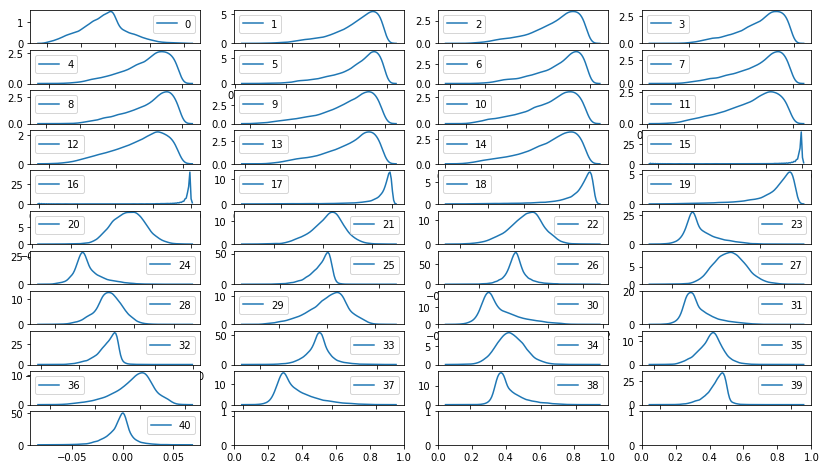

In [53]:
# Display kde plots for each attribute in the data after removal of outliers
fig, ax = plt.subplots(figsize = (14, 8), ncols = 4, nrows = 11)

r = 0
c = 0
for i in range(0, 41):
    sns.kdeplot(good_X[i], ax = ax[r][c])
    c += 1
    if c == 4:
        c = 0
        r += 1

In [17]:
from sklearn.decomposition import PCA

# Perform PCA and keep only the first 10 dimensions
pca = PCA(10)
pca.fit(good_X)

reduced_X = pca.transform(good_X)
reduced_X = pd.DataFrame(reduced_X)
reduced_X.head()

0         1         2         3         4         5         6  \
0 -0.147934 -0.183313  0.405200 -0.172654 -0.010528  0.190279 -0.003852   
1 -0.162832  0.081138  0.181512  0.095906 -0.003520  0.075172 -0.020629   
2 -0.556042  0.137163 -0.014072  0.014793 -0.075693 -0.027219 -0.000289   
3  0.267286  0.070209 -0.149738 -0.020742 -0.007466 -0.009716  0.009853   
4 -0.465054  0.410626  0.120917  0.080982 -0.059627 -0.158557  0.004423   

          7         8         9  
0  0.030466 -0.114647 -0.009165  
1 -0.022554 -0.074199 -0.020169  
2 -0.049256 -0.038924 -0.003492  
3  0.050884  0.019515 -0.044325  
4 -0.020151  0.044682  0.004302

In [18]:
# Display explained variance for each of the principal components retained
ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])

display(variance_ratios)

print("Total Variance Explained:", list(np.sum(variance_ratios))[0])

Explained Variance
0              0.5748
1              0.2337
2              0.1093
3              0.0230
4              0.0166
5              0.0143
6              0.0075
7              0.0064
8              0.0039
9              0.0028

Total Variance Explained: 0.9923


### Implementation

I have trained several classifiers on each of the original, cleaned and reduced datasets respectively. These classifiers include Gaussian Naïve Bayes, Random Forests, Support Vector Classifier, AdaBoost and a Multi-Layer Perceptron Neural Network. For each of the classifiers, I have noted the performance based on the train time, prediction time, train accuracy, test accuracy, train f-score and test f-score for different training sizes. I have also compared the accuracy and f-score with that of the Benchmark Gaussian Naïve Bayes Predictor on the original dataset. I found that the MLP Classifier and AdaBoost consistently outperformed all the other classifiers in terms of test accuracy and test f-score. Also, for training on the reduced dataset, simpler models including SVC and Naive Bayes are also found to work very well.

In [20]:
from sklearn.cross_validation import train_test_split

# Takes a dataset and corresponding label as input and splits it into train and test sets
def getCrossValidationDataSplit(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

    print("Training set has {} samples.".format(X_train.shape[0]))
    print("Testing set has {} samples.".format(X_test.shape[0]))
    
    return [X_train, X_test, y_train, y_test]

In [65]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score 

# Returns the accuracy and F-Score of the benchmark Gaussian Naive Bayes classification model
def getNaivePredictorMetrics():
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = 1)
    
    naive_clf = GaussianNB()
    naive_clf.fit(X_train, y_train)
    
    pred = naive_clf.predict(X_test)

    accuracy = accuracy_score(y_test, pred)
    fscore = f1_score(y_test, pred)

    print("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore))
    
    return [accuracy, fscore]

In [66]:
getNaivePredictorMetrics()

Naive Predictor: [Accuracy score: 0.6059, F-score: 0.6819]


[0.6058884297520661, 0.6818845111528037]

In [72]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score 
from time import time

# Returns the result metrics for a learner, sample size, dataset combination.
def trainPredict(learner, sample_size, X_train, y_train, X_test, y_test): 
    results = {}
    
    start = time()
    learner = learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time()
    
    results['train_time'] = end - start
        
    start = time()
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time()
    
    results['pred_time'] = end - start
    
    results['acc_train'] = accuracy_score(y_train[:300], predictions_train)
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    results['f_train'] = f1_score(y_train[:300], predictions_train)
    results['f_test'] = f1_score(y_test, predictions_test)
       
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    return results

In [73]:
import matplotlib.patches as mpatches

# Visualize results of learning by five classification algorithms in a graphical manner
def evaluate(results, accuracy, f1, data_label):
    
    fig, ax = plt.subplots(2, 3, figsize = (11,7))

    bar_width = 0.16
    colors = ['#A00000', '#00A0A0', '#00A000', '#A0A000', '#0000A0']

    for k, learner in enumerate(results.keys()):
        for j, metric in enumerate(['train_time', 'acc_train', 'f_train', 'pred_time', 'acc_test', 'f_test']):
            for i in np.arange(3):
                ax[j//3, j%3].bar(i + k * bar_width, results[learner][i][metric], width = bar_width, color = colors[k])
                ax[j//3, j%3].set_xticks([0.45, 1.45, 2.45])
                ax[j//3, j%3].set_xticklabels(["1%", "10%", "100%"])
                ax[j//3, j%3].set_xlabel("Training Set Size")
                ax[j//3, j%3].set_xlim((-0.1, 3.0))

    ax[0, 0].set_ylabel("Time (in seconds)")
    ax[0, 1].set_ylabel("Accuracy Score")
    ax[0, 2].set_ylabel("F-score")
    ax[1, 0].set_ylabel("Time (in seconds)")
    ax[1, 1].set_ylabel("Accuracy Score")
    ax[1, 2].set_ylabel("F-score")

    ax[0, 0].set_title("Model Training")
    ax[0, 1].set_title("Accuracy Score on Training Subset")
    ax[0, 2].set_title("F-score on Training Subset")
    ax[1, 0].set_title("Model Predicting")
    ax[1, 1].set_title("Accuracy Score on Testing Set")
    ax[1, 2].set_title("F-score on Testing Set")

    ax[0, 1].axhline(y = accuracy, linewidth = 1, color = 'k', linestyle = 'dashed')
    ax[1, 1].axhline(y = accuracy, linewidth = 1, color = 'k', linestyle = 'dashed')
    ax[0, 2].axhline(y = f1, linewidth = 1, color = 'k', linestyle = 'dashed')
    ax[1, 2].axhline(y = f1, linewidth = 1, color = 'k', linestyle = 'dashed')

    ax[0, 1].set_ylim((0, 1))
    ax[0, 2].set_ylim((0, 1))
    ax[1, 1].set_ylim((0, 1))
    ax[1, 2].set_ylim((0, 1))
    
    patches = []
    for i, learner in enumerate(results.keys()):
        patches.append(mpatches.Patch(color = colors[i], label = learner))
    plt.legend(handles = patches)

    plt.suptitle("Performance Metrics for Classification on " + data_label + " Dataset", fontsize = 16, y = 1.10)
    plt.tight_layout()
    plt.show()

In [74]:
# Display result metrics for all five classifiers in tabular form
def displayResultsTable(results):
    results_list = []
    for k, learner in enumerate(results.keys()):
        entry = [learner]
        for j, metric in enumerate(['train_time', 'acc_train', 'f_train', 'pred_time', 'acc_test', 'f_test']):
            entry.append(results[learner][2][metric])
        results_list.append(entry)
    
    result_df = pd.DataFrame(data = results_list)
    result_df.columns = ['Model', 'Train Time', 'Training Accuracy', 'Training F-Score', 'Prediction Time',\
                         'Test Accuracy', 'Test F-Score']
    display(result_df)

In [75]:
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier


# Initialize five classifiers and sample sizes and return combined results for all possible classifer-sample-size pair
def getClassificationResults(X_train, y_train, X_test, y_test):
    clf_A = GaussianNB()
    clf_B = RandomForestClassifier()
    clf_C = AdaBoostClassifier()
    clf_D = SVC()
    clf_E = MLPClassifier()

    samples_100 = len(y_train)
    samples_10 = int(0.1 * samples_100)
    samples_1 = int(0.01 * samples_100)
    
    results = {}
    for clf in [clf_A, clf_B, clf_C, clf_D, clf_E]:
        clf_name = clf.__class__.__name__
        results[clf_name] = {}
        for i, samples in enumerate([samples_1, samples_10, samples_100]):
            results[clf_name][i] = trainPredict(clf, samples, X_train, y_train, X_test, y_test)
    
    return results

Training set has 15486 samples.
Testing set has 3872 samples.
Naive Predictor: [Accuracy score: 0.6059, F-score: 0.6819]
GaussianNB trained on 154 samples.
GaussianNB trained on 1548 samples.
GaussianNB trained on 15486 samples.
RandomForestClassifier trained on 154 samples.
RandomForestClassifier trained on 1548 samples.
RandomForestClassifier trained on 15486 samples.
AdaBoostClassifier trained on 154 samples.
AdaBoostClassifier trained on 1548 samples.
AdaBoostClassifier trained on 15486 samples.
SVC trained on 154 samples.
SVC trained on 1548 samples.
SVC trained on 15486 samples.
MLPClassifier trained on 154 samples.
MLPClassifier trained on 1548 samples.
MLPClassifier trained on 15486 samples.


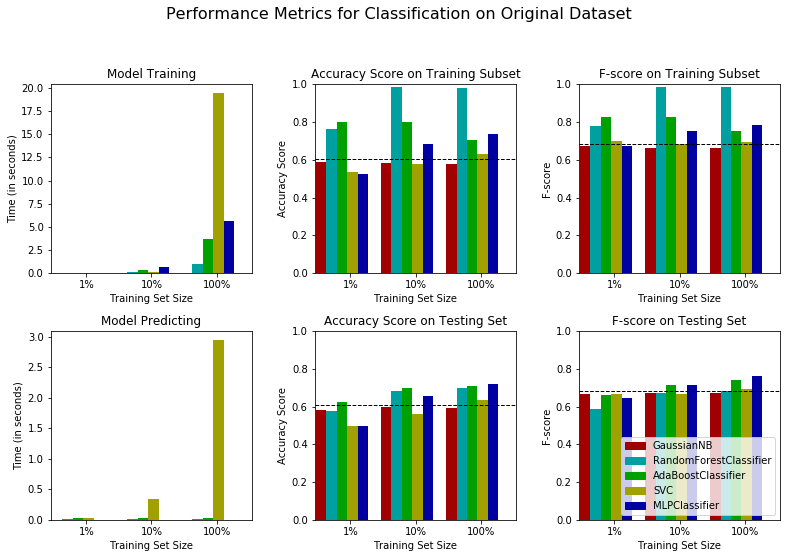

In [76]:
# Train the 5 learners on the original dataset and visualize the results

X_train, X_test, y_train, y_test = getCrossValidationDataSplit(X, y)
accuracy, fscore = getNaivePredictorMetrics()
results = getClassificationResults(X_train, y_train, X_test, y_test)

evaluate(results, accuracy, fscore, "Original")

In [77]:
displayResultsTable(results)

Model  Train Time  Training Accuracy  Training F-Score  \
0              GaussianNB    0.015673           0.580000          0.663102   
1  RandomForestClassifier    0.949791           0.983333          0.984227   
2      AdaBoostClassifier    3.733127           0.703333          0.750700   
3                     SVC   19.401956           0.630000          0.694215   
4           MLPClassifier    5.667073           0.736667          0.783562   

   Prediction Time  Test Accuracy  Test F-Score  
0         0.002817       0.592717      0.670428  
1         0.008735       0.697314      0.684607  
2         0.024033       0.707386      0.739000  
3         2.951462       0.636880      0.692341  
4         0.003764       0.720041      0.762801

Training set has 13076 samples.
Testing set has 3269 samples.
Naive Predictor: [Accuracy score: 0.6059, F-score: 0.6819]
GaussianNB trained on 130 samples.
GaussianNB trained on 1307 samples.
GaussianNB trained on 13076 samples.
RandomForestClassifier trained on 130 samples.
RandomForestClassifier trained on 1307 samples.
RandomForestClassifier trained on 13076 samples.
AdaBoostClassifier trained on 130 samples.
AdaBoostClassifier trained on 1307 samples.
AdaBoostClassifier trained on 13076 samples.
SVC trained on 130 samples.
SVC trained on 1307 samples.
SVC trained on 13076 samples.
MLPClassifier trained on 130 samples.


/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier trained on 1307 samples.
MLPClassifier trained on 13076 samples.


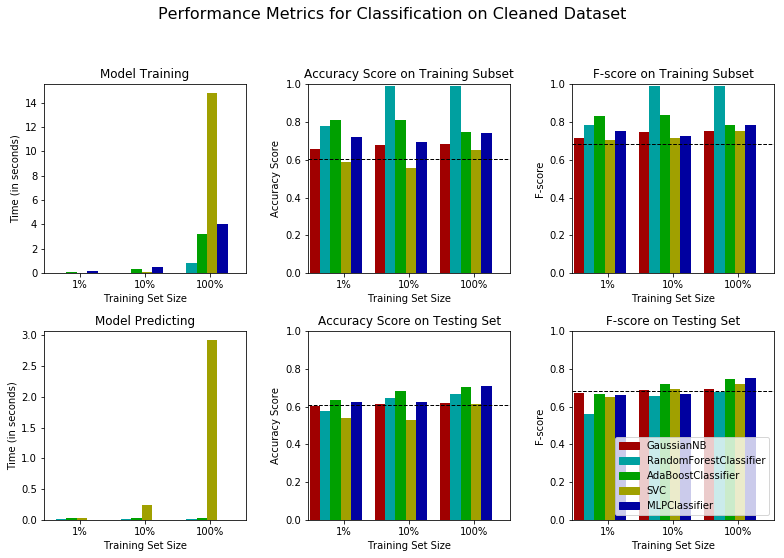

In [80]:
# Train the 5 learners on the cleaned dataset and visualize the results

good_X_train, good_X_test, good_y_train, good_y_test = getCrossValidationDataSplit(good_X, good_y)
good_accuracy, good_fscore = getNaivePredictorMetrics()
good_results = getClassificationResults(good_X_train, good_y_train, good_X_test, good_y_test)

evaluate(good_results, good_accuracy, good_fscore, "Cleaned")

In [81]:
displayResultsTable(good_results)

Model  Train Time  Training Accuracy  Training F-Score  \
0              GaussianNB    0.011276           0.686667          0.753927   
1  RandomForestClassifier    0.846864           0.993333          0.993976   
2      AdaBoostClassifier    3.252506           0.750000          0.787535   
3                     SVC   14.752341           0.650000          0.750594   
4           MLPClassifier    4.069760           0.743333          0.783099   

   Prediction Time  Test Accuracy  Test F-Score  
0         0.001947       0.616396      0.691437  
1         0.010848       0.667788      0.675045  
2         0.021602       0.702661      0.746347  
3         2.923124       0.613337      0.721831  
4         0.003252       0.706944      0.749346

Training set has 13076 samples.
Testing set has 3269 samples.
Naive Predictor: [Accuracy score: 0.6059, F-score: 0.6819]
GaussianNB trained on 130 samples.
GaussianNB trained on 1307 samples.
GaussianNB trained on 13076 samples.
RandomForestClassifier trained on 130 samples.
RandomForestClassifier trained on 1307 samples.
RandomForestClassifier trained on 13076 samples.
AdaBoostClassifier trained on 130 samples.
AdaBoostClassifier trained on 1307 samples.
AdaBoostClassifier trained on 13076 samples.
SVC trained on 130 samples.
SVC trained on 1307 samples.
SVC trained on 13076 samples.
MLPClassifier trained on 130 samples.


/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier trained on 1307 samples.
MLPClassifier trained on 13076 samples.


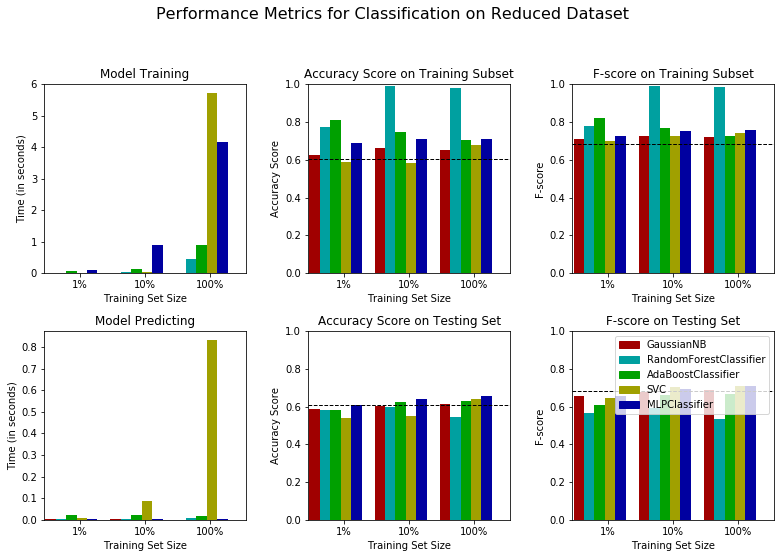

In [84]:
# Train the 5 learners on the reduced dataset and visualize the results

reduced_X_train, reduced_X_test, reduced_y_train, reduced_y_test = getCrossValidationDataSplit(reduced_X, good_y)
reduced_accuracy, reduced_fscore = getNaivePredictorMetrics()
reduced_results = getClassificationResults(reduced_X_train, reduced_y_train, reduced_X_test, reduced_y_test)

evaluate(reduced_results, reduced_accuracy, reduced_fscore, "Reduced")

In [85]:
displayResultsTable(reduced_results)

Model  Train Time  Training Accuracy  Training F-Score  \
0              GaussianNB    0.007555           0.653333          0.721925   
1  RandomForestClassifier    0.450058           0.983333          0.984894   
2      AdaBoostClassifier    0.896953           0.703333          0.727829   
3                     SVC    5.714609           0.676667          0.742706   
4           MLPClassifier    4.181487           0.710000          0.759003   

   Prediction Time  Test Accuracy  Test F-Score  
0         0.001281       0.615785      0.687251  
1         0.009030       0.542062      0.534949  
2         0.019228       0.628633      0.667215  
3         0.832273       0.640869      0.709837  
4         0.001851       0.657999      0.709157

### Refinement

Since the MLP Classifier and AdaBoost consistently outperformed all the other classifiers, I have performed hyper parameter tuning on these classifiers using grid search. The AdaBoost classifier is tuned with respect to number of estimators and learning rate whereas the MLP Classifier is tuned with respect to its optimization tolerance and hidden layer structure. The tuned models for both the classifiers boast improved performance. In the end, I exported the tuned models learned by the MLP Classifier and AdaBoost on the original and cleaned data. Thus, I had four high performing models which I used as voters in my ensemble voting based steganalysis prediction system. It is also worth mentioning that while the models trained on the reduced data were not as high performing, the comparatively smaller training time makes the reduced dataset ideal for training on larger datasets.

In [306]:
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer

# Returns a tuned classifer given a classifier, dataset and a dictionary of parameter value combinations
def getTunedClassifier(clf, parameters, X_train, X_test, y_train, y_test, learner_name):
    scorer = make_scorer(f1_score)
    grid_obj = GridSearchCV(clf, parameters, scorer)
    grid_fit = grid_obj.fit(X_train, y_train)

    best_clf = grid_fit.best_estimator_

    predictions = (clf.fit(X_train, y_train)).predict(X_test)
    best_predictions = best_clf.predict(X_test)

    print("{}\n------\n".format(learner_name))
    print("Unoptimized model\n------")
    print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
    print("F-score on testing data: {:.4f}".format(f1_score(y_test, predictions)))
    print("\nOptimized Model\n------")
    print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
    print("Final F-score on the testing data: {:.4f}\n".format(f1_score(y_test, best_predictions)))
    
    return best_clf

In [309]:
# Create dictionaries of parameter-value combinations for parameter tuning of bothe MLP Clasiifier and AdaBoost Classifier
abc_parameters = {'n_estimators': [100, 250, 500], 'learning_rate': [0.5, 0.75, 1.0]}
mlp_parameters = {'hidden_layer_sizes': [(100, ), (1000, 100), (100, 10)], 'tol': [1e-4, 1e-6]}

learners = [AdaBoostClassifier(), MLPClassifier()]
parameters = [abc_parameters, mlp_parameters]

In [310]:
# Obtain tuned MLP Classifier and AdaBoost Classifier trained on the original dataset
original_tuned_models = []
for i, learner in enumerate(learners):
    original_tuned_models.append(getTunedClassifier(learner, parameters[i], X_train, X_test, y_train, y_test, learner.__class__.__name__))

AdaBoostClassifier
------

Unoptimized model
------
Accuracy score on testing data: 0.7074
F-score on testing data: 0.7390

Optimized Model
------
Final accuracy score on the testing data: 0.7438
Final F-score on the testing data: 0.7613

MLPClassifier
------

Unoptimized model
------
Accuracy score on testing data: 0.7521
F-score on testing data: 0.7596

Optimized Model
------
Final accuracy score on the testing data: 0.7397
Final F-score on the testing data: 0.7771



In [311]:
# Obtain tuned MLP Classifier and AdaBoost Classifier trained on the cleaned dataset
good_tuned_models = []
for i, learner in enumerate(learners):
    good_tuned_models.append(getTunedClassifier(learner, parameters[i], good_X_train, good_X_test, good_y_train, good_y_test, learner.__class__.__name__))

AdaBoostClassifier
------

Unoptimized model
------
Accuracy score on testing data: 0.7027
F-score on testing data: 0.7463

Optimized Model
------
Final accuracy score on the testing data: 0.7259
Final F-score on the testing data: 0.7586

MLPClassifier
------

Unoptimized model
------
Accuracy score on testing data: 0.7033
F-score on testing data: 0.7246

Optimized Model
------
Final accuracy score on the testing data: 0.6938
Final F-score on the testing data: 0.7375



In [313]:
# Obtain tuned MLP Classifier and AdaBoost Classifier trained on the reduced dataset
reduced_tuned_models = []
for i, learner in enumerate(learners):
    reduced_tuned_models.append(getTunedClassifier(learner, parameters[i], reduced_X_train, reduced_X_test, reduced_y_train, reduced_y_test, learner.__class__.__name__))

AdaBoostClassifier
------

Unoptimized model
------
Accuracy score on testing data: 0.6286
F-score on testing data: 0.6672

Optimized Model
------
Final accuracy score on the testing data: 0.6344
Final F-score on the testing data: 0.6769

MLPClassifier
------

Unoptimized model
------
Accuracy score on testing data: 0.6608
F-score on testing data: 0.6974

Optimized Model
------
Final accuracy score on the testing data: 0.6611
Final F-score on the testing data: 0.7039



In [315]:
from sklearn.externals import joblib

# Persist the top 4 best performing hyperparameter tuned models to build voting based predictor
joblib.dump(original_tuned_models[0], 'original_abc.pkl')
joblib.dump(original_tuned_models[1], 'original_mlp.pkl')
joblib.dump(good_tuned_models[0], 'good_abc.pkl')
joblib.dump(good_tuned_models[1], 'good_mlp.pkl')

['good_mlp.pkl']